In [2]:
import argparse
import json
import math
import os
import random
from time import time
import mlflow
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from collections import defaultdict

# import pytrec_eval
import torch
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from accelerate import Accelerator
from copy import deepcopy

torch.backends.cuda.matmul.allow_tf32 = True

from watchog.dataset import (
    # collate_fn,
    TURLColTypeTablewiseDataset,
    TURLRelExtTablewiseDataset,
    SatoCVTablewiseDataset,
    ColPoplTablewiseDataset
)

from watchog.dataset import TableDataset, SupCLTableDataset, SemtableCVTablewiseDataset, GittablesColwiseDataset, GittablesTablewiseDataset
from watchog.model import BertMultiPairPooler, BertForMultiOutputClassification, BertForMultiOutputClassificationColPopl
from watchog.model import SupCLforTable, UnsupCLforTable, lm_mp
from watchog.utils import load_checkpoint, f1_score_multilabel, collate_fn, get_col_pred, ColPoplEvaluator
from watchog.utils import task_num_class_dict
from accelerate import DistributedDataParallelKwargs
import wandb

[nltk_data] Downloading package punkt to /home/zhihao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zhihao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from argparse import Namespace
import torch
import random
import pandas as pd
import numpy as np
import os
import pickle
import json
import re
import transformers
from torch.utils import data
from torch.nn.utils import rnn
from transformers import AutoTokenizer

from typing import List
from functools import reduce
import operator

from itertools import chain
import copy
class SingleColDataset(data.Dataset):
    def __init__(
            self,
            group_df,
            target_col_idx: int,
            tokenizer: AutoTokenizer,
            max_length: int = 64,
            device: torch.device = None,
            max_num_col=8,
            random_sample=False, # TODO
            train_only=True,
            context_encoding_type="v1",
            adaptive_max_length=False,
            ): # TODO: not used
        if device is None:
            device = torch.device('cpu')
        assert max_num_col >= 1, "max_num_col must be greater than 1"
        assert 512//max_num_col >= max_length  , "max_length cannot be smaller than 512//max_num_col"



        
        data_list = []
        


 
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        group_df.sort_values(by=['col_idx'], inplace=True)
        labeled_columns = group_df[group_df['class_id'] > -1]
        # if len(labeled_columns) > 1:
        #     print("Here")
        unlabeled_columns = group_df[group_df['class_id'] == -1]
        for idx in [target_col_idx]:
            token_ids_list = []
            target_column = labeled_columns.loc[idx]
            rest_columns = labeled_columns[labeled_columns.index != idx] # the rest of labeled columns
            # tokenize target column
            token_ids_list.append(tokenizer.encode(
            tokenizer.cls_token + " " + target_column["data"], add_special_tokens=False, max_length=max_length, truncation=True))
            # tokenize context
            unlabeled_columns = unlabeled_columns

            group_df = pd.concat([rest_columns, unlabeled_columns])
            group_df = group_df[: max_num_col-1] if not random_sample  else group_df.sample(min(max_num_col-1, len(group_df))) # TODO
            group_df.sort_values(by=['col_idx'], inplace=True)
            
            if adaptive_max_length and (len(group_df)+1) < max_num_col:
                cur_maxlen = 512 // (len(group_df)+1)
            else:
                cur_maxlen = max_length
                
            if context_encoding_type == "v0":
                token_ids_list += group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                )
            elif context_encoding_type == "v0.1": # only one cls token to separate context and target
                token_ids_list.append([tokenizer.cls_token_id])
                token_ids_list += group_df["data"].apply(lambda x: tokenizer.encode(
                " " + x, add_special_tokens=False, max_length=cur_maxlen-1, truncation=True)).tolist(
                )                    
            elif context_encoding_type == "v1":
                token_ids_list += group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.sep_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                )                    
            elif context_encoding_type == "v1.1": # only one cls token to separate context and target
                token_ids_list.append([tokenizer.sep_token_id])
                token_ids_list += group_df["data"].apply(lambda x: tokenizer.encode(
                " " + x, add_special_tokens=False, max_length=cur_maxlen-1, truncation=True)).tolist(
                )   
            else:
                raise ValueError("context_encoding_type {} is not supported".format(context_encoding_type))
            token_ids = torch.LongTensor(reduce(operator.add,
                                                token_ids_list)).to(device)
            cls_index_list = [0] 
            for cls_index in cls_index_list:
                assert token_ids[
                    cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
            cls_indexes = torch.LongTensor(cls_index_list).to(device)
            class_ids = torch.LongTensor([target_column["class_id"]]
                ).to(device)
            data_list.append(
                [0,
                len(group_df), token_ids, class_ids, cls_indexes])
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"]
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [4]:
    device = torch.device(2)

    parser = argparse.ArgumentParser()
    parser.add_argument("--wandb", type=bool, default=False)
    parser.add_argument("--model", type=str, default="Watchog")
    parser.add_argument("--unlabeled_train_only", type=bool, default=False)
    parser.add_argument("--context_encoding_type", type=str, default="v0")
    parser.add_argument("--pool_version", type=str, default="v0.2")
    parser.add_argument("--random_sample", type=bool, default=False)
    parser.add_argument("--comment", type=str, default="debug", help="to distinguish the runs")
    parser.add_argument(
        "--shortcut_name",
        default="bert-base-uncased",
        type=str,
        help="Huggingface model shortcut name ",
    )
    parser.add_argument(
        "--max_length",
        default=64,
        type=int,
        help=
        "The maximum total input sequence length after tokenization. Sequences longer "
        "than this will be truncated, sequences shorter will be padded.",
    )
    parser.add_argument(
        "--adaptive_max_length",
        default=False,
        type=bool,
    )    
    parser.add_argument(
        "--max_num_col",
        default=8,
        type=int,
    )   

    parser.add_argument(
        "--batch_size",
        default=16,
        type=int,
        help="Batch size",
    )
    parser.add_argument(
        "--epoch",
        default=1,
        type=int,
        help="Number of epochs for training",
    )
    parser.add_argument(
        "--random_seed",
        default=4649,
        type=int,
        help="Random seed",
    )
    
    parser.add_argument(
        "--train_n_seed_cols",
        default=-1,
        type=int,
        help="number of seeding columns in training",
    )

    parser.add_argument(
        "--num_classes",
        default=78,
        type=int,
        help="Number of classes",
    )
    parser.add_argument("--multi_gpu",
                        action="store_true",
                        default=False,
                        help="Use multiple GPU")
    parser.add_argument("--fp16",
                        action="store_true",
                        default=False,
                        help="Use FP16")
    parser.add_argument("--warmup",
                        type=float,
                        default=0.,
                        help="Warmup ratio")
    parser.add_argument("--lr", type=float, default=5e-5, help="Learning rate")
    parser.add_argument("--task",
                        type=str,
                        default='gt-semtab22-dbpedia-all0',
                        choices=[
                            "sato0", "sato1", "sato2", "sato3", "sato4",
                            "msato0", "msato1", "msato2", "msato3", "msato4",
                            "gt-dbpedia0", "gt-dbpedia1", "gt-dbpedia2", "gt-dbpedia3", "gt-dbpedia4",
                            "gt-dbpedia-all0", "gt-dbpedia-all1", "gt-dbpedia-all2", "gt-dbpedia-all3", "gt-dbpedia-all4",
                            "gt-schema-all0", "gt-schema-all1", "gt-schema-all2", "gt-schema-all3", "gt-schema-all4",
                            "gt-semtab22-dbpedia", "gt-semtab22-dbpedia0", "gt-semtab22-dbpedia1", "gt-semtab22-dbpedia2", "gt-semtab22-dbpedia3", "gt-semtab22-dbpedia4",
                            "gt-semtab22-dbpedia-all", "gt-semtab22-dbpedia-all0", "gt-semtab22-dbpedia-all1", "gt-semtab22-dbpedia-all2", "gt-semtab22-dbpedia-all3", "gt-semtab22-dbpedia-all4",
                            "gt-semtab22-schema-class-all", "gt-semtab22-schema-property-all",
                            "turl", "turl-re", "col-popl-1", "col-popl-2", "col-popl-3", "row-popl",
                            "col-popl-turl-0", "col-popl-turl-1", "col-popl-turl-2",
                            "col-popl-turl-mdonly-0", "col-popl-turl-mdonly-1", "col-popl-turl-mdonly-2"
                        ],
                        help="Task names}")
    parser.add_argument("--colpair",
                        action="store_true",
                        help="Use column pair embedding")
    parser.add_argument("--metadata",
                        action="store_true",
                        help="Use column header metadata")
    parser.add_argument("--from_scratch",
                        action="store_true",
                        help="Training from scratch")
    parser.add_argument("--cl_tag",
                        type=str,
                        default="wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt",
                        help="path to the pre-trained file")
    parser.add_argument("--dropout_prob",
                        type=float,
                        default=0.5)
    parser.add_argument("--eval_test",
                        action="store_true",
                        help="evaluate on testset and do not save the model file")
    parser.add_argument("--small_tag",
                        type=str,
                        default="semi1",
                        help="e.g., by_table_t5_v1")
    parser.add_argument("--data_path",
                        type=str,
                        default="/data/zhihao/TU/")
    parser.add_argument("--pretrained_ckpt_path",
                        type=str,
                        default="/data/zhihao/TU/Watchog/model/")    

    args = parser.parse_args([])
    task = args.task
    if args.small_tag != "":
        args.eval_test = True
    
    args.num_classes = task_num_class_dict[task]
    if args.colpair:
        assert "turl-re" == task, "colpair can be only used for Relation Extraction"
    if args.metadata:
        assert "turl-re" == task or "turl" == task, "metadata can be only used for TURL datasets"
    if "col-popl":
        # metrics = {
        #     "accuracy": CategoricalAccuracy(tie_break=True),
        # }
        if args.train_n_seed_cols != -1:
            if "col-popl" in task:
                assert args.train_n_seed_cols == int(task[-1]),  "# of seed columns must match"

    print("args={}".format(json.dumps(vars(args))))

    max_length = args.max_length
    batch_size = args.batch_size
    num_train_epochs = args.epoch

    shortcut_name = args.shortcut_name

    if args.colpair and args.metadata:
        taskname = "{}-colpair-metadata".format(task)
    elif args.colpair:
        taskname = "{}-colpair".format(task)
    elif args.metadata:
        taskname = "{}-metadata".format(task)
    elif args.train_n_seed_cols == -1 and 'popl' in task:
        taskname = "{}-mix".format(task)
    else:
        taskname = "".join(task)
    cv = int(task[-1])

    if args.from_scratch:
        if "gt" in task:
            tag_name = "{}/{}-{}-{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}-{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, 
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        
    else:
        if "gt" in task:
            tag_name = "{}/{}_{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}_{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')

    # if args.eval_test:
    #     if args.small_tag != '':
    #         tag_name = tag_name.replace('outputs', 'small_outputs')
    #         tag_name += '-' + args.small_tag
    print(tag_name)
    file_path = os.path.join(args.data_path, "Watchog", "outputs", tag_name)

    dirpath = os.path.dirname(file_path)
    if not os.path.exists(dirpath):
        print("{} not exists. Created".format(dirpath))
        os.makedirs(dirpath)
    
    if args.fp16:
        torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
        
      
        
    # accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16")   
    ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=True)
    accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16", kwargs_handlers=[ddp_kwargs])

    device = torch.device(1)
    ckpt_path = os.path.join(args.pretrained_ckpt_path, args.cl_tag)
    # ckpt_path = '/efs/checkpoints/{}.pt'.format(args.cl_tag)
    ckpt = torch.load(ckpt_path, map_location=device)
    ckpt_hp = ckpt['hp']
    print(ckpt_hp)
 
    setattr(ckpt_hp, 'batch_size', args.batch_size)
    setattr(ckpt_hp, 'hidden_dropout_prob', args.dropout_prob)
    setattr(ckpt_hp, 'shortcut_name', args.shortcut_name)
    setattr(ckpt_hp, 'num_labels', args.num_classes)
    
    
    
    tokenizer = BertTokenizer.from_pretrained(shortcut_name)
    padder = collate_fn(tokenizer.pad_token_id)
    if task == "turl-re" and args.colpair:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, col_pair='Pair')
    elif "col-popl" in task:
        model = BertForMultiOutputClassificationColPopl(ckpt_hp, device=device, lm=ckpt['hp'].lm, n_seed_cols=int(task[i][-1]), cls_for_md="md" in task)
    else:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, version="v0", use_attention_mask=True)
        


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


args={"wandb": false, "model": "Watchog", "unlabeled_train_only": false, "context_encoding_type": "v0", "pool_version": "v0.2", "random_sample": false, "comment": "debug", "shortcut_name": "bert-base-uncased", "max_length": 64, "adaptive_max_length": false, "max_num_col": 8, "batch_size": 16, "epoch": 1, "random_seed": 4649, "train_n_seed_cols": -1, "num_classes": 101, "multi_gpu": false, "fp16": false, "warmup": 0.0, "lr": 5e-05, "task": "gt-semtab22-dbpedia-all0", "colpair": false, "metadata": false, "from_scratch": false, "cl_tag": "wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt", "dropout_prob": 0.5, "eval_test": true, "small_tag": "semi1", "data_path": "/data/zhihao/TU/", "pretrained_ckpt_path": "/data/zhihao/TU/Watchog/model/"}
gt-semtab22-dbpedia-all0/wikitables-simclr-bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt_bert-base-uncased-poolsemi1-max_colsv0.2-rand8-bsFalse-ml16-ne64-do1

/tmp/ipykernel_3443309/2077486939.py:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Namespace(augment_op='sample_row4,sample_row4', batch_size=32, data_path='/data/zhihao/TU/TURL/', fp16=True, gpus='0', lm='bert', logdir='/data/zhihao/TU/Watchog/model/', lr=5e-05, max_len=256, mode='simclr', model='Watchog', n_epochs=10, pretrain_data='wikitables', pretrained_model_path='', projector=768, run_id=0, sample_meth='tfidf_entity', save_model=10, single_column=False, size=100000, table_order='column', temperature=0.05)


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [4]:
text = "BERT is a powerful language model."
tokenizer.tokenize(text)

['bert', 'is', 'a', 'powerful', 'language', 'model', '.']

In [5]:
dataset_cls = GittablesTablewiseDataset
cv = 0
src = None
# train_dataset = dataset_cls(cv=cv,
#                             split="train",
#                             src=src,
#                             tokenizer=tokenizer,
#                             max_length=max_length,
#                             gt_only='all' not in task,
#                             device=device,
#                             base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
#                             small_tag="semi1")
# valid_dataset = dataset_cls(cv=cv,
#                             split="valid", src=src,
#                             tokenizer=tokenizer,
#                             max_length=max_length,
#                             gt_only='all' not in task,
#                             device=device,
#                             base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
#                             small_tag="semi1")
test_dataset = dataset_cls(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")


test
test 750


In [279]:
# train_dataloader = DataLoader(train_dataset,
#                                 batch_size=batch_size,
#                             #   collate_fn=collate_fn)
#                             collate_fn=padder)
# valid_dataloader = DataLoader(valid_dataset,
#                                 batch_size=batch_size,
#                             #   collate_fn=collate_fn)
#                             collate_fn=padder)
test_dataloader = DataLoader(test_dataset,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [4]:
def extract_cls_tokens(hidden_states, cls_indexes, head=False):
    cls_embeddings = []
    for i, j in cls_indexes:
        sub_sentence_cls_embeddings = hidden_states[i, 0, :] if head else hidden_states[i, j, :]
        cls_embeddings.append(sub_sentence_cls_embeddings)
    cls_embeddings = torch.stack(cls_embeddings)
    return cls_embeddings
#pooled_outputs = extract_cls_tokens(hidden_states, cls_indexes)

In [28]:
batch["label"].cpu().shape

torch.Size([7])

In [30]:
embs.detach().cpu().shape

torch.Size([7, 768])

In [274]:
model.eval()
model = model.to(device)
plm_embs_train = []
labels_train = []
for batch_idx, batch in enumerate(train_dataloader):
    cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
    embs = model.bert(batch["data"].T)
    embs = extract_cls_tokens(embs[0], cls_indexes)
    label = batch["label"].cpu()
    plm_embs_train.append(embs.detach().cpu()[label>-1])
    labels_train.append(label[label>-1])
plm_embs_train = torch.cat(plm_embs_train, dim=0)
labels_train = torch.cat(labels_train, dim=0)

NameError: name 'train_dataloader' is not defined

In [32]:
plm_embs_train.shape

torch.Size([3463, 768])

In [15]:
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
def silhouette_score_per_cluster(embeddings, labels, metric="cosine"):
    sample_silhouette_values = silhouette_samples(embeddings, labels, metric=metric)
    unique_labels = np.unique(labels)
    silhouette_per_cluster = []
    for label in unique_labels:
        cluster_silhouettes = sample_silhouette_values[labels == label]
        silhouette_per_cluster.append(np.mean(cluster_silhouettes))
    return np.array(silhouette_per_cluster).reshape(-1)

In [34]:
plm_embs_train_silhouette_values = silhouette_samples(plm_embs_train, labels_train)

In [35]:
np.mean(plm_embs_train_silhouette_values)

-0.21431549

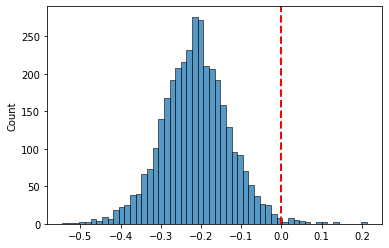

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming plm_embs_train_silhouette_values is your data
sns.histplot(plm_embs_train_silhouette_values)

# Add a red vertical line at x = 0
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Display the plot
plt.show()

In [22]:
cv

0

In [23]:
dataset_col = GittablesColwiseDataset
train_dataset_col = dataset_col(cv=cv,
                            split="train",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            train_ratio=1.0,
                            device=device,
                            small_tag="semi1",
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            max_num_col=1,
                            sampling_method=None,
                            random_seed=0,
                            context_encoding_type=args.context_encoding_type,
                            adaptive_max_length=False                                       
                            )
# dataset_cls(cv=cv,
#                                             split="train",
#                                             tokenizer=tokenizer,
#                                             max_length=max_length,
#                                             gt_only='all' not in task,
#                                             device=device,
#                                             base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
#                                             small_tag=args.small_tag,
#                                             max_num_col=args.max_num_col,
#                                             sampling_method=args.sampling_method,
#                                             random_seed=args.random_seed,
#                                             context_encoding_type=args.context_encoding_type,
#                                             adaptive_max_length=args.adaptive_max_length)

semi1_cv_{}.csv 1 64 None v0 False
train 3463


In [24]:
train_dataloader_col = DataLoader(train_dataset_col,
                                batch_size=batch_size,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [25]:
model.eval()
model = model.to(device)
plm_embs_train_col = []
labels_train_col = []
for batch_idx, batch in enumerate(train_dataloader_col):
    cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
    embs = model.bert(batch["data"].T)
    embs = extract_cls_tokens(embs[0], cls_indexes)
    plm_embs_train_col.append(embs.detach().cpu())
    labels_train_col.append(batch["label"].cpu())
plm_embs_train_col = torch.cat(plm_embs_train_col, dim=0)
labels_train_col = torch.cat(labels_train_col, dim=0)

In [26]:
plm_embs_train_col.shape

torch.Size([3463, 768])

In [33]:
plm_embs_train.shape

torch.Size([3463, 768])

In [37]:
plm_embs_train_silhouette_values_col = silhouette_samples(plm_embs_train_col, labels_train_col)

In [38]:
np.mean(plm_embs_train_silhouette_values_col)

-0.22704358

In [39]:
from sentence_transformers import SentenceTransformer

st_model = SentenceTransformer("all-mpnet-base-v2", cache_folder="/data/zhihao/TU/Watchog/sentence_transformers_cache")

In [40]:

base_dirpath = "/data/zhihao/TU/GitTables/semtab_gittables/2022/"
seperator = "semi1"
basename = seperator+"_cv_{}.csv"
df_list = []
filepath = os.path.join(base_dirpath, basename.format(cv))
df_test = pd.read_csv(filepath)

df_group_test = df_test.groupby("table_id")



df_list = []
for i in range(5):
    if i == cv:
        continue
    filepath = os.path.join(base_dirpath, basename.format(i))
    df_list.append(pd.read_csv(filepath))
df_train = pd.concat(df_list, axis=0)
df_group_train = df_train.groupby("table_id")

In [44]:
labels_cluster = []
embeddings_cluster = []
embeddings_cluster_context = []
for i, (index, group_df) in enumerate(df_group_train):
    labeled_columns = group_df[group_df['class_id'] > -1]
    labels_cluster += labeled_columns["class_id"].values.tolist()
    # if len(labeled_columns) > 1:
    #     embeddings_cluster.append(ft_model.get_sentence_vector(" ".join(labeled_columns["data"].values)))
    #     embeddings_cluster_context.append(ft_model.get_sentence_vector(" ".join(group_df["data"].values)))
    #     break
    for text in labeled_columns["data"].values:
        embeddings_cluster.append(st_model.encode(text))
        embeddings_cluster_context.append(st_model.encode(st_model.tokenizer.sep_token.join(group_df["data"].values)))

In [47]:
embeddings_cluster = np.stack(embeddings_cluster, axis=0)

In [49]:
embeddings_cluster_context = np.stack(embeddings_cluster_context, axis=0)

In [53]:
labels_cluster = np.array(labels_cluster)

In [54]:
embeddings_cluster_silhouette_values = silhouette_samples(embeddings_cluster, labels_cluster)
embeddings_cluster_context_silhouette_values = silhouette_samples(embeddings_cluster_context, labels_cluster)

In [55]:
np.mean(embeddings_cluster_silhouette_values)

-0.08592572

In [56]:
np.mean(embeddings_cluster_context_silhouette_values)

-0.15294842

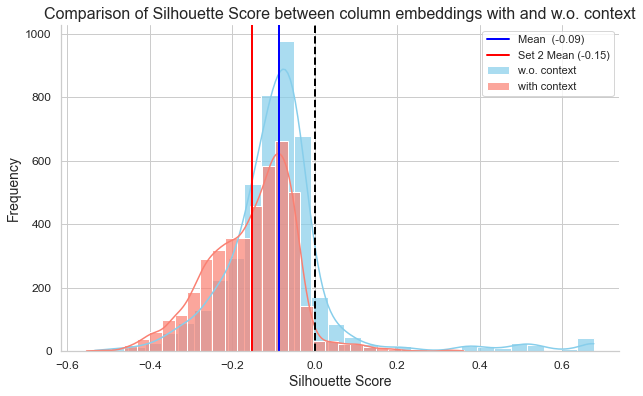

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example data: Two sets of values
values_set_1 = embeddings_cluster_silhouette_values  # Replace with your actual data
values_set_2 = embeddings_cluster_context_silhouette_values  # Replace with your second set of values

mean_set_1 = np.mean(values_set_1)
mean_set_2 = np.mean(values_set_2)
# Set the style of the visualization
sns.set(style="whitegrid")

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot the first set of values
sns.histplot(values_set_1, color='skyblue', kde=True, label='w.o. context', bins=30, alpha=0.7)

# Plot the second set of values
sns.histplot(values_set_2, color='salmon', kde=True, label='with context', bins=30, alpha=0.7)

# Add a vertical line at x=0 for reference
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)

plt.axvline(x=mean_set_1, color='blue', linestyle='-', linewidth=2, label=f'Mean  ({mean_set_1:.2f})')
plt.axvline(x=mean_set_2, color='red', linestyle='-', linewidth=2, label=f'Set 2 Mean ({mean_set_2:.2f})')

# Customize the plot
plt.title('Comparison of Silhouette Score between column embeddings with and w.o. context', fontsize=16)
plt.xlabel('Silhouette Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove the top and right spines for a cleaner look
sns.despine()

# Show the plot
plt.show()

In [7]:
with open(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-poolv0-unlabeled8-randTrue-bs16-ml64-ne50-do0.1_eval.json", 'r') as f:
    results = json.load(f)
# bert-base-uncased-fromscratch-semi1-poolv0-unlabeled8-randTrue-bs16-ml64-ne50-do0.1_best_f1_micro.pt
# labels_train = np.array(results['train']['tr_true_list'])
# preds_train = np.array(results['train']['tr_pred_list'])
# class_f1_train = np.array(results['train']['tr_class_f1'])

labels = np.array(results['f1_macro']['true_list'])
preds = np.array(results['f1_macro']['pred_list'])
class_f1 = np.array(results['f1_macro']['ts_class_f1'])

In [5]:
# best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-AttnMask-max-unlabeled@8-poolv0-unlabeled8-randFalse-bs16-ml128-ne50-do0.1_best_f1_micro.pt", map_location=device)
best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/bert-base-uncased-fromscratch-semi1-Repeat@5-AttnMask-UnlabelValid-max-unlabeled@8-poolv0-unlabeled8-randFalse-bs16-ml128-ne50-do0.1_best_f1_macro.pt", map_location=device)
model.load_state_dict(best_state_dict, strict=False)

/tmp/ipykernel_3443309/307592194.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/b

<All keys matched successfully>

In [12]:
model.eval()
model = model.to(device)
ft_embs_train = []
labels_train = []
for batch_idx, batch in enumerate(train_dataloader):
    cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
    embs = model.bert(batch["data"].T)
    embs = extract_cls_tokens(embs[0], cls_indexes)
    ft_embs_train.append(embs.detach().cpu())
    labels_train.append(batch["label"].cpu())
ft_embs_train = torch.cat(ft_embs_train, dim=0)
labels_train = torch.cat(labels_train, dim=0)

In [339]:
test_dataloader = DataLoader(test_dataset,
                                batch_size=16,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test_origin = []
logits_test_origin_16 = []
cls_indexes_all_16 = []
for batch_idx, batch in enumerate(test_dataloader):
    cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
    # embs = model.bert(batch["data"].T)
    logits = model(batch["data"].T, cls_indexes=cls_indexes,).detach().cpu()
    # embs = extract_cls_tokens(embs[0], cls_indexes)
    # ft_embs_test.append(embs.detach().cpu())
    labels_test_origin.append(batch["label"].cpu())
    if logits.dim() == 1:
        logits = logits.unsqueeze(0)
    logits_test_origin_16.append(logits)
    cls_indexes_all_16.append(cls_indexes.detach().cpu())
# ft_embs_test = torch.cat(ft_embs_test, dim=0)

labels_test_origin = torch.cat(labels_test_origin, dim=0)
logits_test_origin_16 = torch.cat(logits_test_origin_16, dim=0)
preds_test_origin_16 = torch.argmax(logits_test_origin_16, dim=1)

In [345]:
logits_test_origin_16[0]

tensor([ 1.2349e+01,  2.2623e+00,  2.0195e+00,  4.7039e-01,  1.3064e+00,
         1.2641e+00,  8.9482e-01,  2.4156e+00,  2.7143e+00, -5.1789e-01,
         1.7351e+00,  1.0563e+00,  5.2661e-01,  2.3156e+00,  3.5534e-01,
         4.9356e-03,  4.0803e-01, -1.2673e-01, -1.5701e+00,  4.4213e-01,
         1.2484e+00, -6.4937e-02, -2.9976e-01, -1.0279e+00,  4.1979e-01,
        -1.6945e+00,  1.1877e-01, -3.9443e-01, -2.4848e+00, -1.3368e+00,
        -1.0973e+00, -1.7170e-01, -1.3608e+00,  1.0209e+00,  1.2189e+00,
        -1.0656e+00, -4.0851e-01,  2.1805e+00, -1.4573e+00,  3.6495e-02,
         1.2361e+00, -1.9280e+00, -1.0239e-01, -1.9924e+00, -1.8749e+00,
         5.8734e-01, -3.8315e-01, -1.6866e+00,  8.4979e-02, -7.3993e-01,
        -3.0850e+00, -2.9878e+00, -2.6023e+00, -2.5192e+00, -2.8550e+00,
        -1.0333e+00,  1.0281e+00, -7.8085e-01, -8.5541e-01,  3.0408e-01,
         1.1371e+00, -1.7338e+00, -2.1937e+00, -6.1994e-01, -1.8035e+00,
        -3.0026e+00, -2.4853e+00, -1.7369e+00, -1.8

In [346]:
logits_test_origin_1[0]

tensor([ 1.2314e+01,  2.2582e+00,  2.0340e+00,  4.8279e-01,  1.2961e+00,
         1.2751e+00,  9.4323e-01,  2.4833e+00,  2.7057e+00, -5.0379e-01,
         1.7371e+00,  1.1412e+00,  5.4223e-01,  2.3659e+00,  3.5382e-01,
        -3.1089e-03,  4.4818e-01, -1.2872e-01, -1.5742e+00,  4.2284e-01,
         1.2316e+00, -8.0508e-02, -2.9698e-01, -1.0158e+00,  4.0950e-01,
        -1.7014e+00,  1.4729e-01, -4.0749e-01, -2.4696e+00, -1.2981e+00,
        -1.0998e+00, -1.8593e-01, -1.3521e+00,  1.0008e+00,  1.2162e+00,
        -1.0663e+00, -4.2975e-01,  2.2044e+00, -1.4563e+00,  6.6450e-02,
         1.1826e+00, -1.9540e+00, -1.3295e-01, -2.0091e+00, -1.8851e+00,
         6.2226e-01, -3.7785e-01, -1.6972e+00,  7.0330e-02, -7.5263e-01,
        -3.0694e+00, -2.9786e+00, -2.5552e+00, -2.5303e+00, -2.8545e+00,
        -1.0462e+00,  1.0155e+00, -7.7138e-01, -8.7357e-01,  3.1614e-01,
         1.0917e+00, -1.7528e+00, -2.2213e+00, -6.6158e-01, -1.8124e+00,
        -2.9912e+00, -2.5006e+00, -1.7283e+00, -1.8

In [333]:
preds_test_origin_16.shape

torch.Size([1085])

In [334]:
preds_test_origin_1.shape

torch.Size([1085])

In [328]:
cls_indexes_all_16 = torch.cat(cls_indexes_all_16, dim = 0)[:, 1]

In [332]:
cls_indexes_all_16.equal(cls_indexes_all_1)

True

In [330]:
cls_indexes_all_1  = torch.cat(cls_indexes_all_1, dim = 0)[:, 1]

In [336]:
cls_indexes

tensor([[  0,   0],
        [  1,   0],
        [  2,   0],
        [  2,  64],
        [  3,   0],
        [  4,   0],
        [  5,   0],
        [  5,  14],
        [  6,   0],
        [  7,   0],
        [  8,   0],
        [  8,  64],
        [  9,   0],
        [  9,  52],
        [ 10,   0],
        [ 11,   0],
        [ 12,   0],
        [ 12,  64],
        [ 12, 128],
        [ 12, 192],
        [ 13,   0]], device='cuda:1')

In [14]:
test_dataloader = DataLoader(test_dataset,
                                batch_size=16,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test_origin = []
logits_test_origin_1 = []
cls_indexes_all_1 = []
for batch_idx, batch in enumerate(test_dataloader):
    cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
    
    # embs = model.bert(batch["data"].T)
    logits = model(batch["data"].T, cls_indexes=cls_indexes,).detach().cpu()
    # embs = extract_cls_tokens(embs[0], cls_indexes)
    # ft_embs_test.append(embs.detach().cpu())
    labels_test_origin.append(batch["label"].cpu())
    if logits.dim() == 1:
        logits = logits.unsqueeze(0)
    logits_test_origin_1.append(logits)
    cls_indexes_all_1.append(cls_indexes.detach().cpu())
# ft_embs_test = torch.cat(ft_embs_test, dim=0)

labels_test_origin = torch.cat(labels_test_origin, dim=0)
logits_test_origin_1 = torch.cat(logits_test_origin_1, dim=0)
preds_test_origin_1 = torch.argmax(logits_test_origin_1, dim=1)

In [321]:
is_equal = []
for i in range(len(logits_test_origin_16)):
    is_equal.append(torch.equal(logits_test_origin_16[i], logits_test_origin_1[i]))

In [320]:
True in is_equal

True

In [314]:
logits_test_origin_1.shape

torch.Size([1085, 101])

In [15]:
ts_pred_list_origin = logits_test_origin_1.argmax(
                            1).cpu().detach().numpy().tolist()
from sklearn.metrics import confusion_matrix, f1_score
ts_micro_f1 = f1_score(labels_test_origin.reshape(-1).numpy().tolist(),
                    ts_pred_list_origin,
                    average="micro")
ts_macro_f1 = f1_score(labels_test_origin.reshape(-1).numpy().tolist(),
                    ts_pred_list_origin,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.4507, ts_macro_f1=0.1865


In [107]:
import torch.nn.functional as F
ood_score = F.softmax(logits_test_origin_1, dim=1).max(1).values
ood_labels = torch.tensor(preds_test_origin_1 == labels_test_origin).float()
from sklearn.metrics import roc_auc_score

roc_auc_score(ood_labels, ood_score)

/tmp/ipykernel_4054970/1939110723.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ood_labels = torch.tensor(preds_test_origin_1 == labels_test_origin).float()


0.7740097583069132

In [33]:
def compute_entropy(probs):
    # Adding a small value (1e-9) to avoid log(0)
    if probs.dim() == 1:
        return -torch.sum(probs * torch.log(probs))
    else:
        return -torch.sum(probs * torch.log(probs), dim=1)

In [34]:
import torch.nn.functional as F
ood_score = compute_entropy(F.softmax(logits_test_origin_1, dim=1))
ood_labels = torch.tensor(preds_test_origin_1 != labels_test_origin).float()
from sklearn.metrics import roc_auc_score

roc_auc_score(ood_labels, ood_score)

/tmp/ipykernel_4054970/4129975340.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ood_labels = torch.tensor(preds_test_origin_1 != labels_test_origin).float()


0.7723833738213859

<Axes: ylabel='Count'>

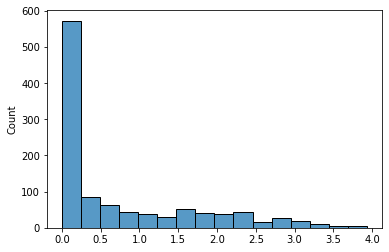

In [26]:
import seaborn as sns
sns.histplot(ood_score)

<Axes: ylabel='Count'>

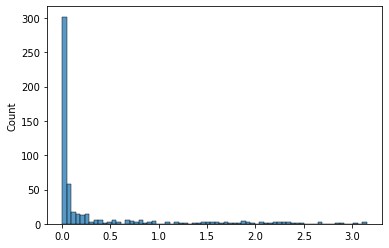

In [27]:
sns.histplot(ood_score[ood_labels==0])

<Axes: ylabel='Count'>

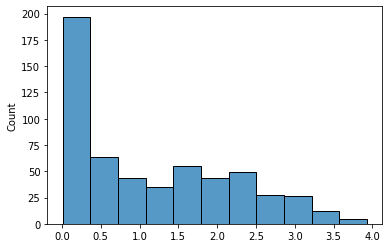

In [28]:
sns.histplot(ood_score[ood_labels==1])

In [30]:
threshold = 0.25
(ood_score[ood_labels==1] > threshold).sum()/sum(ood_score> threshold)

tensor(0.7680)

In [32]:
threshold = 0.1
(ood_score[ood_labels==1] > threshold).sum()/sum(ood_score> threshold)

tensor(0.7262)

In [108]:
(ood_score[ood_labels==0] < 0.99).sum()/len(ood_score[ood_labels==0])

tensor(0.8188)

In [26]:
(ood_score[ood_labels==1] < 0.99).sum()/len(ood_score[ood_labels==1])

tensor(0.3378)

In [27]:
(ood_score[ood_labels==1] < 0.99).sum()/len(ood_score[ood_labels==1])

tensor(0.3378)

In [ ]:
for test_dataloader

In [6]:
class GittablesTablewiseIterateDataset(data.Dataset):

    def __init__(
            self,
            cv: int,
            split: str,
            src: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            gt_only: bool = False,
            device: torch.device = None,
            base_dirpath: str = "/data/zhihao/TU/GitTables/semtab_gittables/2022",
            base_tag: str = '', # blank, comma
            small_tag: str = "",
            train_ratio: float = 1.0,
            max_unlabeled=8,
            random_sample=False, # TODO
            train_only=False): # TODO
        if device is None:
            device = torch.device('cpu')
        basename = small_tag+ "_cv_{}.csv"
    
        if split in ["train", "valid"]:
            df_list = []
            for i in range(5):
                if i == cv:
                    continue
                filepath = os.path.join(base_dirpath, basename.format(i))
                df_list.append(pd.read_csv(filepath))
                print(split, i)
            df = pd.concat(df_list, axis=0)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
            print(split)


        if gt_only:
            df = df[df["class_id"] > -1]
        if train_only and split != "train":
            df = df[df["class_id"] > -1]

        
        data_list = []
        
        df['class_id'] = df['class_id'].astype(int)
        df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
        df['col_idx'] = df['col_idx'].astype(int)
        df['data'] = df['data'].astype(str)
        
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)        
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        total_num_cols = 0
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                break
            if split == "valid" and i < valid_index:
                continue
            #     break
            labeled_columns = group_df[group_df['class_id'] > -1]
            unlabeled_columns = group_df[group_df['class_id'] == -1]
            num_unlabeled = min(max(max_unlabeled-len(labeled_columns), 0), len(unlabeled_columns))
            unlabeled_columns = unlabeled_columns.sample(num_unlabeled) if random_sample else unlabeled_columns[0:num_unlabeled]
            # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns.sample(min(10-len(labeled_columns), len(unlabeled_columns)))])
            # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns[0:min(max(10-len(labeled_columns), 0), len(unlabeled_columns))]])
            group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns]) # TODO
            group_df.sort_values(by=['col_idx'], inplace=True)

            if max_length <= 128:
                cur_maxlen = min(max_length, 512 // len(list(group_df["class_id"].values)) - 1)
            else:
                cur_maxlen = max(1, max_length // len(list(group_df["class_id"].values)) - 1)
                
            token_ids_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                )
            token_ids = torch.LongTensor(reduce(operator.add,
                                                token_ids_list)).to(device)
            for col_i in range(len(token_ids_list)):
                if group_df["class_id"].values[col_i] == -1:
                    continue
                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                for col_j in range(len(token_ids_list)):
                    if col_j == col_i:
                        target_col_mask += [0] * len(token_ids_list[col_j])
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[col_j])
                        context_id += 1
                    if col_j < col_i:
                        cls_index_value += len(token_ids_list[col_j])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [group_df["class_id"].values[col_i]]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(group_df), token_ids, class_ids, cls_indexes, target_col_mask])                
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [7]:
def collate_fn(pad_token_id, data_only=True):
    '''padder for input batch'''

    def padder(samples):    
        data = torch.nn.utils.rnn.pad_sequence(
            [sample["data"] for sample in samples], padding_value=pad_token_id)
        if not data_only:
            label = torch.nn.utils.rnn.pad_sequence(
                [sample["label"] for sample in samples], padding_value=-1)
        else:
            label = torch.cat([sample["label"] for sample in samples])
        batch = {"data": data, "label": label}
        if "idx" in samples[0]:
            batch["idx"] = [sample["idx"] for sample in samples]
        if "cls_indexes" in samples[0]:
            cls_indexes = torch.nn.utils.rnn.pad_sequence(
                [sample["cls_indexes"] for sample in samples], padding_value=0)
            batch["cls_indexes"] = cls_indexes
        if "target_col_mask" in samples[0]:
            target_col_mask = torch.nn.utils.rnn.pad_sequence(
                [sample["target_col_mask"] for sample in samples], padding_value=-1)
            batch["target_col_mask"] = target_col_mask
        if "table_embedding" in samples[0]:
            table_embeddings = [sample["table_embedding"] for sample in samples]
            batch["table_embedding"] = torch.stack(table_embeddings, dim=0)
        return batch
        
    return padder

In [8]:
src = None
test_dataset_iter = GittablesTablewiseIterateDataset(cv=cv,
                            split="test", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_iter = DataLoader(test_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

test
test 1085


In [9]:
train_dataset_iter = GittablesTablewiseIterateDataset(cv=cv,
                            split="train", src=src,
                            tokenizer=tokenizer,
                            max_length=max_length,
                            gt_only='all' not in task,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag="semi1")
padder = collate_fn(tokenizer.pad_token_id)
train_dataloader_iter = DataLoader(train_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

train 1
train 2
train 3
train 4
train 3463


In [ ]:
labels_test_origin 
logits_test_origin 
preds_test_origin 

In [272]:
logits_test_origin.equal(logits_test)

False

In [269]:
labels_test.equal(labels_test_origin )

True

In [507]:
print((num_cols==0).sum().item(), (num_cols==0).sum()/len(num_cols))

1 tensor(0.0009)


In [8]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(batch["target_col_mask"].max().item())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)
 
from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.5355, ts_macro_f1=0.2745
ts_micro_f1=0.5351, ts_macro_f1=0.2745
ts_micro_f1=1.0000, ts_macro_f1=1.0000


1085

In [10]:
import torch.nn.functional as F
ood_score = F.softmax(logits_test, dim=1).max(1).values
ood_labels = torch.tensor(preds_test == labels_test).float()

/tmp/ipykernel_3314194/1144848621.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ood_labels = torch.tensor(preds_test == labels_test).float()


In [33]:
(ood_score[ood_labels==0] < 0.99).sum()/sum(ood_labels==0)

tensor(0.8592)

In [35]:
threshold = 0.5
(ood_score[ood_labels==0] < threshold).sum()/sum(ood_score<threshold)

tensor(0.7678)

In [11]:
# Single column results
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, 0]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T[:, target_col_mask[0]==0], cls_indexes=cls_indexes,)
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
    num_cols.append(batch["target_col_mask"].max().item())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)

from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.4406, ts_macro_f1=0.1616
ts_micro_f1=0.4400, ts_macro_f1=0.1616
ts_micro_f1=1.0000, ts_macro_f1=1.0000


In [22]:
# Cheat drop one-column
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
corrected = 0
total_mistakes = 0
logits_init = []
logits_correct = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    num_cols.append(batch["target_col_mask"].max().item())
    if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
        total_mistakes += 1
        for col_i in target_col_mask.unique():
            if col_i == 0 or col_i == -1:
                continue
            new_batch_data = batch["data"].T[target_col_mask!=col_i].reshape(1, -1)
            target_col_mask_temp = target_col_mask[target_col_mask!=col_i].reshape(1, -1)
            cls_indexes = (target_col_mask_temp == 0).nonzero()[0].reshape(1, -1)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            if logits_temp.argmax().item() == batch["label"].item():
                logits_init.append(logits.detach().cpu())
                logits = logits_temp.clone()
                
                corrected += 1

            
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)




from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.4903, ts_macro_f1=0.2121
ts_micro_f1=0.4974, ts_macro_f1=0.2227
ts_micro_f1=0.4823, ts_macro_f1=0.1573


In [47]:
# Cheat drop one-column
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
corrected = 0
total_mistakes = 0
logits_init = []
logits_correct = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    num_cols.append(batch["target_col_mask"].max().item())
    if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
        total_mistakes += 1
        for col_i in target_col_mask.unique():
            if col_i == 0 or col_i == -1:
                continue
            new_batch_data = batch["data"].T[target_col_mask!=col_i].reshape(1, -1)
            target_col_mask_temp = target_col_mask[target_col_mask!=col_i].reshape(1, -1)
            cls_indexes = (target_col_mask_temp == 0).nonzero()[0].reshape(1, -1)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            if logits_temp.argmax().item() == batch["label"].item():
                logits_init.append(logits.detach().cpu())
                logits_correct.append(logits_temp.detach().cpu())
                corrected += 1
                break

In [ ]:
# Cheat brute force permutation
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
corrected = 0
total_mistakes = 0
logits_init = []
logits_correct = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    num_cols.append(batch["target_col_mask"].max().item())
    if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
        total_mistakes += 1
        for col_i in target_col_mask.unique():
            if col_i == 0 or col_i == -1:
                continue
            new_batch_data = batch["data"].T[target_col_mask!=col_i].reshape(1, -1)
            target_col_mask_temp = target_col_mask[target_col_mask!=col_i].reshape(1, -1)
            cls_indexes = (target_col_mask_temp == 0).nonzero()[0].reshape(1, -1)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            if logits_temp.argmax().item() == batch["label"].item():
                logits_init.append(logits.detach().cpu())
                logits_correct.append(logits_temp.detach().cpu())
                corrected += 1
                break

In [ ]:
# Cheat drop one-column
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
corrected = 0
total_mistakes = 0
logits_init = []
logits_correct = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    num_cols.append(batch["target_col_mask"].max().item())
    if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
        total_mistakes += 1
        for col_i in target_col_mask.unique():
            if col_i == 0 or col_i == -1:
                continue
            new_batch_data = batch["data"].T[target_col_mask!=col_i].reshape(1, -1)
            target_col_mask_temp = target_col_mask[target_col_mask!=col_i].reshape(1, -1)
            cls_indexes = (target_col_mask_temp == 0).nonzero()[0].reshape(1, -1)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            if logits_temp.argmax().item() == batch["label"].item():
                logits_init.append(logits.detach().cpu())
                logits_correct.append(logits_temp.detach().cpu())
                corrected += 1
                break

In [48]:
len(logits_init)

34

In [49]:
total_mistakes

314

In [50]:
logits_init = torch.stack(logits_init, dim=0)
logits_correct = torch.stack(logits_correct, dim=0)

In [52]:
ood_score_init = F.softmax(logits_init, dim=1).max(1).values
ood_score_correct = F.softmax(logits_correct, dim=1).max(1).values

In [54]:
((ood_score_correct - ood_score_init)>0).sum()

tensor(23)

<Axes: ylabel='Count'>

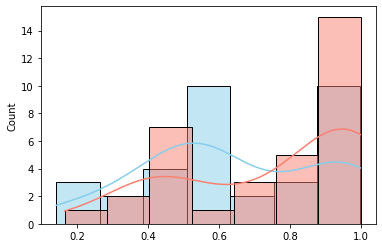

In [53]:
sns.histplot(ood_score_init, color='skyblue', kde=True)
sns.histplot(ood_score_correct, color='salmon', kde=True)

In [21]:
print(corrected, total_mistakes, corrected/total_mistakes)

34 314 0.10828025477707007


In [25]:
# Cheat add
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    num_cols.append(batch["target_col_mask"].max().item())
    if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
        total_mistakes += 1
        for col_i in target_col_mask.unique():
            if col_i == 0 or col_i == -1:
                continue
            new_batch_data = batch["data"].T[(target_col_mask==col_i) + (target_col_mask==0)].reshape(1, -1)
            target_col_mask_temp = target_col_mask[(target_col_mask==col_i) + (target_col_mask==0)].reshape(1, -1)
            cls_indexes = (target_col_mask_temp == 0).nonzero()[0].reshape(1, -1)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            if logits_temp.argmax().item() == batch["label"].item():
                logits = logits_temp.clone()
                corrected += 1
                break
            
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)




from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.4323, ts_macro_f1=0.2168
ts_micro_f1=0.4939, ts_macro_f1=0.2391
ts_micro_f1=0.3622, ts_macro_f1=0.1474


In [75]:
# Cheat add
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    num_cols.append(batch["target_col_mask"].max().item())
    if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
        total_mistakes += 1
        for col_i in target_col_mask.unique():
            if col_i == 0 or col_i == -1:
                continue
            new_batch_data = torch.cat([batch["data"].T[target_col_mask==0].reshape([1, -1]), batch["data"].T[target_col_mask==col_i].reshape([1, -1])], dim=1)
            cls_indexes = torch.tensor([[0, 0]]).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            if logits_temp.argmax().item() == batch["label"].item():
                logits = logits_temp.clone()
                corrected += 1
                break
            
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)




from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.4396, ts_macro_f1=0.2099
ts_micro_f1=0.5078, ts_macro_f1=0.2336
ts_micro_f1=0.3622, ts_macro_f1=0.1474


In [36]:
# Greedy (MSP)
model.load_state_dict(best_state_dict, strict=False)
model.eval()

threshold = 0.8
log = {}
for threshold in [0.8, 0.9, 0.99 1.0]:
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    num_cols = []
    log[threshold] = {}
    print(f"*********************Threshold: {threshold}****************************")
    
    print("Mistake constitution", (ood_score[ood_labels==0] < threshold).sum()/sum(ood_labels==0), 
          (ood_score[ood_labels==0] < threshold).sum()/sum(ood_score< threshold))
    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        num_cols.append(batch["target_col_mask"].max().item())
        if 1 in target_col_mask:
            ood_score_max = F.softmax(logits.detach()).max().item()
            if ood_score_max < threshold:
                log[threshold][batch_idx] = []
                log[threshold][batch_idx].append([ood_score_max])
                current_drop = 1
                while True:
                    improved = False
                    log[threshold][batch_idx].append([])
                    for col_i in target_col_mask.unique():
                        if col_i == 0 or col_i == -1:
                            continue
                        target_col_mask_temp = target_col_mask.clone()
                        target_col_mask_temp[target_col_mask_temp==col_i] = -1
                        new_batch_data = batch["data"].T[target_col_mask_temp!=-1].reshape(1, -1)
                        cls_indexes = (target_col_mask_temp[target_col_mask_temp!=-1].reshape(1, -1) == 0).nonzero()[0].reshape(1, -1)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                        if ood_score_temp > ood_score_max:
                            logits = logits_temp.clone()
                            temp_best_target_col_mask = target_col_mask_temp.clone()
                            # print(f"{batch_idx} col_{col_i}", ood_score_max, ood_score_temp)
                            ood_score_max = ood_score_temp
                            log[threshold][batch_idx][current_drop].append(ood_score_max)
                            improved = True
                    if not improved:
                        break
                    else:
                        target_col_mask = temp_best_target_col_mask.clone()
                        current_drop += 1
                    
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)

    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************Threshold: 0.8****************************
Mistake constitution tensor(0.5437) tensor(0.7332)


/tmp/ipykernel_2170815/3797198874.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_2170815/3797198874.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.4138, ts_macro_f1=0.1909
ts_micro_f1=0.4593, ts_macro_f1=0.2035
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 0.9****************************
Mistake constitution tensor(0.6453) tensor(0.6741)


/tmp/ipykernel_2170815/3797198874.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_2170815/3797198874.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.4129, ts_macro_f1=0.1887
ts_micro_f1=0.4575, ts_macro_f1=0.2009
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 0.95****************************
Mistake constitution tensor(0.7308) tensor(0.6721)


/tmp/ipykernel_2170815/3797198874.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_2170815/3797198874.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.4147, ts_macro_f1=0.1843
ts_micro_f1=0.4610, ts_macro_f1=0.1966
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 0.99****************************
Mistake constitution tensor(0.8592) tensor(0.6309)


/tmp/ipykernel_2170815/3797198874.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_2170815/3797198874.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.4138, ts_macro_f1=0.1839
ts_micro_f1=0.4593, ts_macro_f1=0.1959
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 0.999****************************
Mistake constitution tensor(0.9982) tensor(0.5437)


/tmp/ipykernel_2170815/3797198874.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_2170815/3797198874.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.4129, ts_macro_f1=0.1838
ts_micro_f1=0.4575, ts_macro_f1=0.1960
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 1.0****************************
Mistake constitution tensor(1.) tensor(0.5171)


/tmp/ipykernel_2170815/3797198874.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_2170815/3797198874.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.4129, ts_macro_f1=0.1838
ts_micro_f1=0.4575, ts_macro_f1=0.1960
ts_micro_f1=0.3622, ts_macro_f1=0.1474


In [111]:
for threshold in [0.8, 0.85, 0.9, 0.95, 0.99, 1.0]:
    print(f"*********************Threshold: {threshold}****************************")
    print((ood_score[ood_labels==0] < threshold).sum()/sum(ood_score< threshold), (ood_score[ood_labels==0] < threshold).sum()/sum(ood_labels==0))

*********************Threshold: 0.8****************************
tensor(0.8111) tensor(0.5621)
*********************Threshold: 0.85****************************
tensor(0.7956) tensor(0.6007)
*********************Threshold: 0.9****************************
tensor(0.7850) tensor(0.6493)
*********************Threshold: 0.95****************************
tensor(0.7614) tensor(0.7013)
*********************Threshold: 0.99****************************
tensor(0.6604) tensor(0.8188)
*********************Threshold: 1.0****************************
tensor(0.5493) tensor(1.)


In [30]:
threshold = 0.1
for threshold in [0.01, 0.1, 0.2, 0.5, 1.0, 1.5, 2.0]:
    print(f"*********************Threshold: {threshold}****************************")
    print((ood_score[ood_labels==1] > threshold).sum()/sum(ood_score> threshold), (ood_score[ood_labels==1] > threshold).sum()/sum(ood_labels==1))



*********************Threshold: 0.01****************************
tensor(0.6113) tensor(0.9984)
*********************Threshold: 0.1****************************
tensor(0.7398) tensor(0.8777)
*********************Threshold: 0.2****************************
tensor(0.7771) tensor(0.8307)
*********************Threshold: 0.5****************************
tensor(0.8098) tensor(0.7006)
*********************Threshold: 1.0****************************
tensor(0.8594) tensor(0.5940)
*********************Threshold: 1.5****************************
tensor(0.8734) tensor(0.4216)
*********************Threshold: 2.0****************************
tensor(0.9053) tensor(0.2696)


In [42]:
# Greedy (Entropy)
model.load_state_dict(best_state_dict, strict=False)
model.eval()

threshold = 0.8
log = {}
for threshold in [0.01, 0.1, 0.2, 0.5, 1.0]:
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    num_cols = []
    log[threshold] = {}
    print(f"*********************Threshold: {threshold}****************************")
    
    print("Mistake constitution", (ood_score[ood_labels==1] > threshold).sum()/sum(ood_score> threshold), (ood_score[ood_labels==1] > threshold).sum()/sum(ood_labels==1))
    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        num_cols.append(batch["target_col_mask"].max().item())
        if 1 in target_col_mask:
            ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
            if ood_score_min > threshold:
                log[threshold][batch_idx] = []
                log[threshold][batch_idx].append([ood_score_min])
                current_drop = 1
                while True:
                    improved = False
                    log[threshold][batch_idx].append([])
                    for col_i in target_col_mask.unique():
                        if col_i == 0 or col_i == -1:
                            continue
                        target_col_mask_temp = target_col_mask.clone()
                        target_col_mask_temp[target_col_mask_temp==col_i] = -1
                        new_batch_data = batch["data"].T[target_col_mask_temp!=-1].reshape(1, -1)
                        cls_indexes = (target_col_mask_temp[target_col_mask_temp!=-1].reshape(1, -1) == 0).nonzero()[0].reshape(1, -1)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()
                        if ood_score_temp < ood_score_min:
                            logits = logits_temp.clone()
                            temp_best_target_col_mask = target_col_mask_temp.clone()
                            ood_score_min = ood_score_temp
                            log[threshold][batch_idx][current_drop].append(ood_score_min)
                            improved = True
                    if not improved:
                        break
                    else:
                        target_col_mask = temp_best_target_col_mask.clone()
                        current_drop += 1
                    
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)

    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************Threshold: 0.01****************************
Mistake constitution tensor(0.5412) tensor(0.9892)


/tmp/ipykernel_3005789/154180484.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3005789/154180484.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4101, ts_macro_f1=0.1833
ts_micro_f1=0.4523, ts_macro_f1=0.1965
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 0.1****************************
Mistake constitution tensor(0.7262) tensor(0.7939)


/tmp/ipykernel_3005789/154180484.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3005789/154180484.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4111, ts_macro_f1=0.1834
ts_micro_f1=0.4541, ts_macro_f1=0.1963
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 0.2****************************
Mistake constitution tensor(0.7555) tensor(0.7366)


/tmp/ipykernel_3005789/154180484.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3005789/154180484.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4101, ts_macro_f1=0.1834
ts_micro_f1=0.4523, ts_macro_f1=0.1962
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 0.5****************************
Mistake constitution tensor(0.7845) tensor(0.6004)


/tmp/ipykernel_3005789/154180484.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3005789/154180484.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4092, ts_macro_f1=0.1882
ts_micro_f1=0.4506, ts_macro_f1=0.2012
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 1.0****************************
Mistake constitution tensor(0.8297) tensor(0.4803)


/tmp/ipykernel_3005789/154180484.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3005789/154180484.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4111, ts_macro_f1=0.1908
ts_micro_f1=0.4541, ts_macro_f1=0.2044
ts_micro_f1=0.3622, ts_macro_f1=0.1474


In [43]:
# Drop 1 (Entropy)
model.load_state_dict(best_state_dict, strict=False)
model.eval()

threshold = 0.8
log = {}
for threshold in [0.01, 0.1, 0.2, 0.5, 1.0]:
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    num_cols = []
    log[threshold] = {}
    print(f"*********************Threshold: {threshold}****************************")
    
    print("Mistake constitution", (ood_score[ood_labels==1] > threshold).sum()/sum(ood_score> threshold), (ood_score[ood_labels==1] > threshold).sum()/sum(ood_labels==1))
    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        num_cols.append(batch["target_col_mask"].max().item())
        if 1 in target_col_mask:
            ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
            if ood_score_min > threshold:
                log[threshold][batch_idx] = []
                log[threshold][batch_idx].append([ood_score_min])
                current_drop = 1

                log[threshold][batch_idx].append([])
                for col_i in target_col_mask.unique():
                    if col_i == 0 or col_i == -1:
                        continue
                    target_col_mask_temp = target_col_mask.clone()
                    target_col_mask_temp[target_col_mask_temp==col_i] = -1
                    new_batch_data = batch["data"].T[target_col_mask_temp!=-1].reshape(1, -1)
                    cls_indexes = (target_col_mask_temp[target_col_mask_temp!=-1].reshape(1, -1) == 0).nonzero()[0].reshape(1, -1)
                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                    ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()
                    if ood_score_temp < ood_score_min:
                        logits = logits_temp.clone()
                        temp_best_target_col_mask = target_col_mask_temp.clone()
                        ood_score_min = ood_score_temp
                        log[threshold][batch_idx][current_drop].append(ood_score_min)
                    
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)

    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************Threshold: 0.01****************************
Mistake constitution tensor(0.5412) tensor(0.9892)


/tmp/ipykernel_3005789/2503683824.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3005789/2503683824.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4120, ts_macro_f1=0.1838
ts_micro_f1=0.4558, ts_macro_f1=0.1950
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 0.1****************************
Mistake constitution tensor(0.7262) tensor(0.7939)


/tmp/ipykernel_3005789/2503683824.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3005789/2503683824.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4129, ts_macro_f1=0.1838
ts_micro_f1=0.4575, ts_macro_f1=0.1948
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 0.2****************************
Mistake constitution tensor(0.7555) tensor(0.7366)


/tmp/ipykernel_3005789/2503683824.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3005789/2503683824.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4120, ts_macro_f1=0.1838
ts_micro_f1=0.4558, ts_macro_f1=0.1947
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 0.5****************************
Mistake constitution tensor(0.7845) tensor(0.6004)


/tmp/ipykernel_3005789/2503683824.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3005789/2503683824.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4111, ts_macro_f1=0.1886
ts_micro_f1=0.4541, ts_macro_f1=0.1997
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 1.0****************************
Mistake constitution tensor(0.8297) tensor(0.4803)


/tmp/ipykernel_3005789/2503683824.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3005789/2503683824.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4120, ts_macro_f1=0.1910
ts_micro_f1=0.4558, ts_macro_f1=0.2026
ts_micro_f1=0.3622, ts_macro_f1=0.1474


In [39]:
logits.shape

torch.Size([101])

In [54]:
# One column
model.load_state_dict(best_state_dict, strict=False)
model.eval()

threshold = 0.8
log = {}
changed_log = {}
for threshold in [0.8, 0.9, 0.95, 0.99, 0.999, 1.0]:
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    num_cols = []
    log[threshold] = {}
    changed = [0, 0, 0]
    print(f"*********************Threshold: {threshold}****************************")
    print("Mistake constitution", (ood_score[ood_labels==0] < threshold).sum()/sum(ood_labels==0), 
          (ood_score[ood_labels==0] < threshold).sum()/sum(ood_score< threshold))
    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        num_cols.append(batch["target_col_mask"].max().item())
        pred_init = logits.argmax().item()
        changed_batch = False
        if 1 in target_col_mask:
            ood_score_max = ood_score_init = F.softmax(logits.detach()).max().item()
            if ood_score_max < threshold:
                log[threshold][batch_idx] = []
                log[threshold][batch_idx].append([ood_score_max])
                current_drop = 1
                log[threshold][batch_idx].append([])
                for col_i in target_col_mask.unique():
                    if col_i == 0 or col_i == -1:
                        continue
                    target_col_mask_temp = target_col_mask.clone()
                    target_col_mask_temp[target_col_mask_temp==col_i] = -1
                    new_batch_data = batch["data"].T[target_col_mask_temp!=-1].reshape(1, -1)
                    cls_indexes = (target_col_mask_temp[target_col_mask_temp!=-1].reshape(1, -1) == 0).nonzero()[0].reshape(1, -1)
                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                    ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                    if ood_score_temp > ood_score_max:
                        logits = logits_temp.clone()
                        temp_best_target_col_mask = target_col_mask_temp.clone()
                        # print(f"{batch_idx} col_{col_i}", ood_score_max, ood_score_temp)
                        ood_score_max = ood_score_temp
                        log[threshold][batch_idx][current_drop].append(ood_score_max)
                        improved = True
                        changed_batch = True
        if changed_batch:
            pred_current = logits.argmax().item()
            if pred_current == pred_init:
                changed[0] += 1
            elif pred_current == batch["label"].item():
                changed[1] += 1
            else:
                changed[2] += 1
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)
    changed_log[threshold] = changed
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************Threshold: 0.8****************************
Mistake constitution tensor(0.5437) tensor(0.7332)


/tmp/ipykernel_2170815/920578023.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = ood_score_init = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_2170815/920578023.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.4157, ts_macro_f1=0.1926
ts_micro_f1=0.4627, ts_macro_f1=0.2052
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 0.9****************************
Mistake constitution tensor(0.6453) tensor(0.6741)


/tmp/ipykernel_2170815/920578023.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = ood_score_init = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_2170815/920578023.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.4147, ts_macro_f1=0.1904
ts_micro_f1=0.4610, ts_macro_f1=0.2026
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 0.95****************************
Mistake constitution tensor(0.7308) tensor(0.6721)


/tmp/ipykernel_2170815/920578023.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = ood_score_init = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_2170815/920578023.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.4166, ts_macro_f1=0.1861
ts_micro_f1=0.4645, ts_macro_f1=0.1983
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 0.99****************************
Mistake constitution tensor(0.8592) tensor(0.6309)


/tmp/ipykernel_2170815/920578023.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = ood_score_init = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_2170815/920578023.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.4157, ts_macro_f1=0.1856
ts_micro_f1=0.4627, ts_macro_f1=0.1975
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 0.999****************************
Mistake constitution tensor(0.9982) tensor(0.5437)


/tmp/ipykernel_2170815/920578023.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = ood_score_init = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_2170815/920578023.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.4147, ts_macro_f1=0.1855
ts_micro_f1=0.4610, ts_macro_f1=0.1976
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 1.0****************************
Mistake constitution tensor(1.) tensor(0.5171)


/tmp/ipykernel_2170815/920578023.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = ood_score_init = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_2170815/920578023.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.4147, ts_macro_f1=0.1855
ts_micro_f1=0.4610, ts_macro_f1=0.1976
ts_micro_f1=0.3622, ts_macro_f1=0.1474


In [44]:
# One column
model.load_state_dict(best_state_dict, strict=False)
model.eval()

threshold = 0.8
log = {}
changed_log = {}
state = []
for threshold in [1.0]:
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    ood_scores_init = []
    num_cols = []
    log[threshold] = {}
    changed = [0, 0, 0]
    print(f"*********************Threshold: {threshold}****************************")
    
    print("Mistake constitution", (ood_score[ood_labels==0] < threshold).sum()/sum(ood_labels==0), 
          (ood_score[ood_labels==0] < threshold).sum()/sum(ood_score< threshold))
    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        num_cols.append(batch["target_col_mask"].max().item())
        pred_init = logits.argmax().item()
        changed_batch = False
        ood_score_max = ood_score_init = F.softmax(logits.detach()).max().item()
        ood_scores_init.append(ood_score_init)
        if 1 in target_col_mask:
            if ood_score_max < threshold:
                log[threshold][batch_idx] = []
                log[threshold][batch_idx].append([ood_score_max])
                current_drop = 1
                while True:
                    improved = False
                    log[threshold][batch_idx].append([])
                    for col_i in target_col_mask.unique():
                        if col_i == 0 or col_i == -1:
                            continue
                        target_col_mask_temp = target_col_mask.clone()
                        target_col_mask_temp[target_col_mask_temp==col_i] = -1
                        new_batch_data = batch["data"].T[target_col_mask_temp!=-1].reshape(1, -1)
                        cls_indexes = (target_col_mask_temp[target_col_mask_temp!=-1].reshape(1, -1) == 0).nonzero()[0].reshape(1, -1)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                        if ood_score_temp > ood_score_max:
                            logits = logits_temp.clone()
                            temp_best_target_col_mask = target_col_mask_temp.clone()
                            # print(f"{batch_idx} col_{col_i}", ood_score_max, ood_score_temp)
                            ood_score_max = ood_score_temp
                            log[threshold][batch_idx][current_drop].append(ood_score_max)
                            improved = True
                            changed_batch = True
                    if not improved:
                        break
                    else:
                        target_col_mask = temp_best_target_col_mask.clone()
                        current_drop += 1
        if changed_batch:
            pred_current = logits.argmax().item()
            if pred_current == pred_init:
                state.append(1)
            elif pred_current == batch["label"].item():
                state.append(2)
            else:
                state.append(3)
        else:
            state.append(0)
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    ood_scores_init = torch.tensor(ood_scores_init)
    states = torch.tensor(state)
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)
    changed_log[threshold] = changed
    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************Threshold: 1.0****************************
Mistake constitution tensor(1.) tensor(0.5171)


/tmp/ipykernel_2170815/3279817322.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = ood_score_init = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_2170815/3279817322.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.4129, ts_macro_f1=0.1838
ts_micro_f1=0.4575, ts_macro_f1=0.1960
ts_micro_f1=0.3622, ts_macro_f1=0.1474


In [42]:
states.shape

torch.Size([1085])

In [45]:
ood_scores_init.shape

torch.Size([1085])

In [46]:
ood_scores_new = logits_test.softmax(1).max(1).values

<Axes: ylabel='Count'>

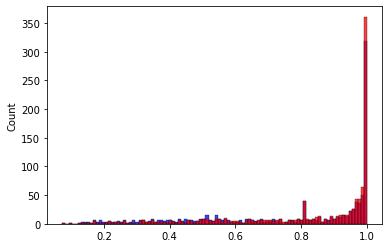

In [51]:
import seaborn as sns
sns.histplot(ood_scores_init, bins=100, color='blue')
sns.histplot(ood_scores_new, bins=100, color='red')

<Axes: ylabel='Count'>

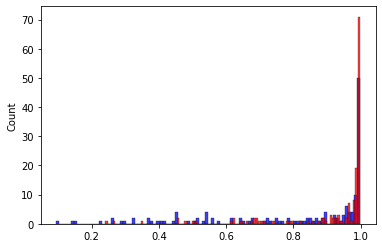

In [50]:
import seaborn as sns
sns.histplot(ood_scores_init[states==1], bins=100, color='blue')
sns.histplot(ood_scores_new[states==1], bins=100, color='red')

In [59]:
print(ood_scores_init[states==1].mean(), ood_scores_new[states==1].mean(), ood_scores_init[states==1].mean()-ood_scores_new[states==1].mean())

tensor(0.8104) tensor(0.9154) tensor(-0.1050)


<Axes: ylabel='Count'>

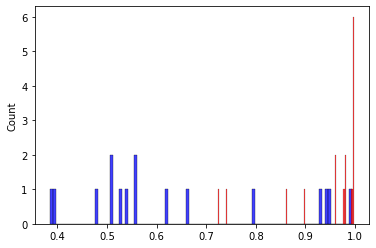

In [52]:
import seaborn as sns
sns.histplot(ood_scores_init[states==2], bins=100, color='blue')
sns.histplot(ood_scores_new[states==2], bins=100, color='red')

In [57]:
print(ood_scores_init[states==2].mean(), ood_scores_new[states==2].mean(), ood_scores_init[states==2].mean()-ood_scores_new[states==2].mean())

tensor(0.6469) tensor(0.9412) tensor(-0.2943)


<Axes: ylabel='Count'>

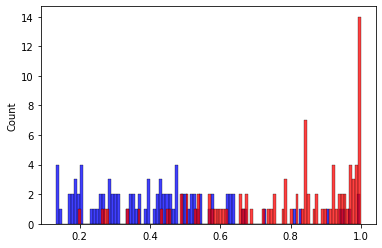

In [53]:
import seaborn as sns
sns.histplot(ood_scores_init[states==3], bins=100, color='blue')
sns.histplot(ood_scores_new[states==3], bins=100, color='red')

In [58]:
print(ood_scores_init[states==3].mean(), ood_scores_new[states==3].mean(), ood_scores_init[states==3].mean()-ood_scores_new[states==3].mean())

tensor(0.4290) tensor(0.7837) tensor(-0.3547)


In [115]:
# Cheat perumate
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    num_cols.append(batch["target_col_mask"].max().item())
    if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
        total_mistakes += 1
        col_idx_set = target_col_mask.unique().tolist()
        assert -1 not in col_idx_set
        for x in itertools.permutations(col_idx_set):
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            if logits_temp.argmax().item() == batch["label"].item():
                logits = logits_temp.clone()
                corrected += 1
                break
            
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)




from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.5078, ts_macro_f1=0.2298
ts_micro_f1=0.5303, ts_macro_f1=0.2481
ts_micro_f1=0.4823, ts_macro_f1=0.1573


In [39]:
torch.tensor([2,5,1,0]).unique(sorted=False)

tensor([0, 1, 2, 5])

In [41]:
t = torch.tensor([2,5,1,0])

In [42]:
new = []
for k in t:
    if k not in new:
        new.append(k)

In [43]:
new

[tensor(2), tensor(5), tensor(1), tensor(0)]

In [24]:
total_mistakes

333

In [11]:
def get_permutation(x):
    new = []
    for k in x.tolist()[0]:
        if k not in new:
            new.append(k)
    return new

In [96]:
# Cheat brute force perumate
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
init_logits = []
init_msp = []
init_entropy = []
msp_log = []
entropy_log = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    logits_init = logits.clone()
    num_cols.append(batch["target_col_mask"].max().item())
    if 1 in target_col_mask:
        cls_indexes = torch.tensor([0, 0]).reshape(1, -1).to(device)
        logits_temp = model(batch["data"].T[target_col_mask==0].reshape(1, -1), cls_indexes=cls_indexes,)    
        init_msp.append(F.softmax(logits_temp).max().item())
        init_entropy.append(compute_entropy(F.softmax(logits_temp)).item())
        init_logits.append(logits_temp.clone().detach().cpu())
        if F.softmax(logits_temp).argmax().item() != batch["label"].item() and batch_idx in MSP_corrected_ids:
            msp_log.append(0)
        elif F.softmax(logits_temp).argmax().item() != batch["label"].item() and batch_idx not in MSP_corrected_ids:
            msp_log.append(1)
        elif F.softmax(logits_temp).argmax().item() == batch["label"].item() and batch_idx not in MSP_corrected_ids:
            msp_log.append(2)
        elif F.softmax(logits_temp).argmax().item() == batch["label"].item() and batch_idx in MSP_corrected_ids:
            msp_log.append(3)
        else:
            raise ValueError()
        # if compute_entropy(F.softmax(logits_temp)).argmax().item() != batch["label"].item() and batch_idx in Entropy_corrected_ids:
        #     entropy_log.append(0)
        # elif compute_entropy(F.softmax(logits_temp)).argmax().item() != batch["label"].item() and batch_idx not in Entropy_corrected_ids:
        #     entropy_log.append(1)
        # elif compute_entropy(F.softmax(logits_temp)).argmax().item() == batch["label"].item() and batch_idx not in Entropy_corrected_ids:
        #     entropy_log.append(2)
        # elif compute_entropy(F.softmax(logits_temp)).argmax().item() == batch["label"].item() and batch_idx in Entropy_corrected_ids:
        #     entropy_log.append(3)
        # else:
        #     raise ValueError()

/tmp/ipykernel_4054970/4068173671.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp.append(F.softmax(logits_temp).max().item())
/tmp/ipykernel_4054970/4068173671.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_entropy.append(compute_entropy(F.softmax(logits_temp)).item())
/tmp/ipykernel_4054970/4068173671.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if F.softmax(logits_temp).argmax().item() != batch["label"].item() and batch_idx in MSP_corrected_ids:
/tmp/ipykernel_4054970/4068173671.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  elif F.softmax(logits_temp).argmax().item() != batch["label"].item() and batch_idx not in MSP_corrected_ids:
/tmp/ipyker

In [75]:
num_cols = torch.tensor(num_cols)
print(len(num_cols), (num_cols>0).sum())

1085 tensor(577)


In [43]:
total_mistakes = 333
origin_correct = 244
best_corrected = 78

In [45]:
print(len(entropy_log) - total_mistakes, (len(entropy_log) - total_mistakes)/len(entropy_log))

244 0.42287694974003465


In [46]:
print(len(entropy_log) - total_mistakes +best_corrected, (len(entropy_log) - total_mistakes +best_corrected)/len(entropy_log))

322 0.5580589254766031


In [76]:
num_cols

tensor([1, 1, 0,  ..., 3, 3, 0])

In [97]:
init_msp = torch.tensor(init_msp)
init_entropy = torch.tensor(init_entropy)
msp_log = torch.tensor(msp_log)
entropy_log = torch.tensor(entropy_log)

In [48]:
# 2 indicates single column能划分正确
print(len(msp_log), len(entropy_log))
for i in range(4):
    print(i, (msp_log==i).sum(), (entropy_log==i).sum())


577 577
0 tensor(152) tensor(155)
1 tensor(196) tensor(311)
2 tensor(215) tensor(99)
3 tensor(14) tensor(12)


In [99]:
# permuation starting with 0
print(len(msp_log), len(entropy_log))
for i in range(4):
    print(i, (msp_log==i).sum())

577 0
0 tensor(164)
1 tensor(184)
2 tensor(214)
3 tensor(15)


tensor(0.8917)

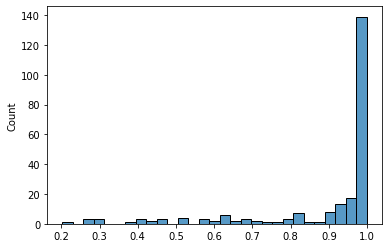

In [60]:
import seaborn as sns
sns.histplot(init_msp[(msp_log==2) + (msp_log==3)])
init_msp[(msp_log==2) + (msp_log==3)].mean()

In [100]:
# permutation starting with 0
for threshold in [0.8, 0.9, 0.95, 0.99, 0.999, 1.0]:
    print(threshold, (init_msp[(msp_log==2) + (msp_log==3)] > threshold).sum() + (init_msp[(msp_log==0)] < threshold).sum())

0.8 tensor(251)
0.9 tensor(255)
0.95 tensor(240)
0.99 tensor(196)
0.999 tensor(163)
1.0 tensor(164)


In [104]:
# permutation starting with 0
for threshold in range(8950, 8970):
    threshold = threshold/10000
    print(threshold, (init_msp[(msp_log==2) + (msp_log==3)] > threshold).sum() + (init_msp[(msp_log==0)] < threshold).sum())

0.895 tensor(256)
0.8951 tensor(256)
0.8952 tensor(256)
0.8953 tensor(256)
0.8954 tensor(256)
0.8955 tensor(256)
0.8956 tensor(256)
0.8957 tensor(256)
0.8958 tensor(257)
0.8959 tensor(257)
0.896 tensor(257)
0.8961 tensor(257)
0.8962 tensor(256)
0.8963 tensor(256)
0.8964 tensor(256)
0.8965 tensor(256)
0.8966 tensor(256)
0.8967 tensor(256)
0.8968 tensor(256)
0.8969 tensor(256)


In [80]:
for threshold in [0.8, 0.9, 0.95, 0.99, 0.999, 1.0]:
    print(threshold, (init_msp[(msp_log==2) + (msp_log==3)] > threshold).sum() + (init_msp[(msp_log==0)] < threshold).sum())

0.8 tensor(242)
0.9 tensor(245)
0.95 tensor(230)
0.99 tensor(185)
0.999 tensor(151)
1.0 tensor(152)


In [84]:
for threshold in range(8950, 8970):
    threshold = threshold/10000
    print(threshold, (init_msp[(msp_log==2) + (msp_log==3)] > threshold).sum() + (init_msp[(msp_log==0)] < threshold).sum())

0.895 tensor(246)
0.8951 tensor(246)
0.8952 tensor(246)
0.8953 tensor(246)
0.8954 tensor(246)
0.8955 tensor(246)
0.8956 tensor(246)
0.8957 tensor(246)
0.8958 tensor(247)
0.8959 tensor(247)
0.896 tensor(247)
0.8961 tensor(247)
0.8962 tensor(246)
0.8963 tensor(246)
0.8964 tensor(246)
0.8965 tensor(246)
0.8966 tensor(246)
0.8967 tensor(246)
0.8968 tensor(246)
0.8969 tensor(246)


tensor(0.6848)

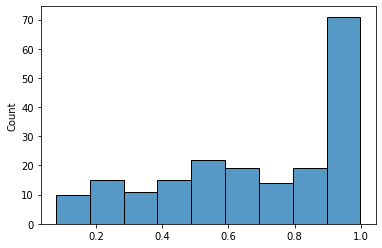

In [61]:
import seaborn as sns
sns.histplot(init_msp[msp_log==1])
init_msp[(msp_log==1)].mean()

tensor(0.8144)

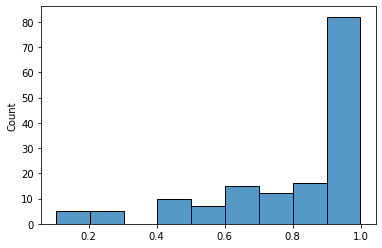

In [62]:
import seaborn as sns
sns.histplot(init_msp[msp_log==0])
init_msp[(msp_log==0)].mean()

In [49]:
print(((msp_log==2).sum()+(msp_log==3).sum())/len(msp_log), ((entropy_log==2).sum()+ (entropy_log==3).sum())/len(msp_log))

tensor(0.3969) tensor(0.1924)


In [249]:
total_mistakes

0

In [88]:
torch.save(MSP_permutation, "/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/MSP_full_permutation.pt")
torch.save(MSP_logits, "/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all0/MSP_full_logits.pt")


In [11]:
# Cheat brute force perumate

import itertools
import torch.nn.functional as F

    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)
MSP_permutation = defaultdict(list)
MSP_logits = defaultdict(list)
MSP_corrected = 0
Entropy_permutation = defaultdict(list)
Entropy_logits = defaultdict(list)
Entropy_corrected = 0

max_col_length = 3
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    logits_init = logits.clone()
    num_cols.append(batch["target_col_mask"].max().item())
    if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
        total_mistakes += 1
        col_idx_set = target_col_mask.unique().tolist()
        successs = False
        init_permutation[batch_idx].append(get_permutation(target_col_mask))
        init_logits[batch_idx].append(logits_init.detach().cpu())        
        max_msp = F.softmax(logits_init).detach().cpu().max().item()
        msp_logits = logits_init.clone().detach().cpu()
        msp_perm = get_permutation(target_col_mask)[0]
        assert -1 not in col_idx_set
        for r in range(1, min(len(col_idx_set), max_col_length) + 1):
            for subset in itertools.combinations(col_idx_set, r):
                if 0 not in subset:
                    continue
                for x in itertools.permutations(subset):
                    # if 0 not in x:
                    #     continue
                    # if x[0] != 0:
                    #     continue
                    new_batch_data = []
                    for col_i in x:
                        if col_i == 0:
                            if len(new_batch_data) == 0:
                                cls_indexes_value = 0
                            else:
                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                    if logits_temp.argmax().item() == batch["label"].item():
                        logits = logits_temp.clone()
                        successs = True
                        corrected_permutation[batch_idx].append(x)
                        corrected_logits[batch_idx].append(logits_temp.clone().detach().cpu())
                    
                    temp_msp = F.softmax(logits_temp).max().item()
                    if max_msp < temp_msp:
                        max_msp = temp_msp
                        msp_logits = logits_temp.clone().detach().cpu()
                        msp_perm = x
        MSP_logits[batch_idx].append(msp_logits)
        MSP_permutation[batch_idx].append(msp_perm)
        if msp_logits.argmax().item() == batch["label"].item():
            MSP_corrected += 1
            # print(f"MSP correct {batch_idx}")
        if successs:
            corrected += 1
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)




from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

/tmp/ipykernel_3122311/130419269.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  max_msp = F.softmax(logits_init).detach().cpu().max().item()
/tmp/ipykernel_3122311/130419269.py:72: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  temp_msp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.7272, ts_macro_f1=0.4835
ts_micro_f1=0.7269, ts_macro_f1=0.4835
ts_micro_f1=1.0000, ts_macro_f1=1.0000


In [16]:
list(init_permutation.keys())[:10]

[2, 4, 6, 8, 12, 14, 15, 16, 18, 19]

In [13]:
def is_sublist(A, B):
    it = iter(B)
    return all(x in it for x in A)

In [17]:
init_permutation[2]

[[1, 2, 3, 4, 5, 6, 0, 7]]

In [19]:
list(corrected_permutation.keys())[:10]

[4, 8, 12, 15, 16, 18, 19, 23, 27, 33]

In [21]:
 corrected_permutation[4][0]

(1, 0)

In [24]:
num_sublist = 0
for idx in corrected_permutation:
    for sublist in corrected_permutation[idx]:
        if is_sublist(sublist, init_permutation[idx][0]):
            num_sublist += 1
            break

In [27]:
len(corrected_permutation)

251

In [28]:
num_sublist

194

In [26]:
num_sublist/len(corrected_permutation)

0.7729083665338645

In [12]:
# Cheat brute force perumate

import itertools
import torch.nn.functional as F
import time
for max_col_length in [2,3,4]:
    start = time.time()
    print(f"*********************Max Column Length: {max_col_length}****************************")
    model.load_state_dict(best_state_dict, strict=False)
    model.eval()
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    threshold = 0.8
    corrected = 0
    total_mistakes = 0
    init_permutation = defaultdict(list)
    corrected_permutation = defaultdict(list)
    init_logits = defaultdict(list)
    corrected_logits = defaultdict(list)
    MSP_permutation = defaultdict(list)
    MSP_logits = defaultdict(list)
    MSP_corrected = 0
    Entropy_permutation = defaultdict(list)
    Entropy_logits = defaultdict(list)
    Entropy_corrected = 0
    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        num_cols.append(batch["target_col_mask"].max().item())
        if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
            total_mistakes += 1
            col_idx_set = target_col_mask.unique().tolist()
            successs = False
            assert -1 not in col_idx_set
            for r in range(1, min(len(col_idx_set), max_col_length) + 1):
                for subset in itertools.combinations(col_idx_set, r):
                    if 0 not in subset:
                        continue
                    for x in itertools.permutations(subset):
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        if logits_temp.argmax().item() == batch["label"].item():
                            logits = logits_temp.clone()
                            successs = True
                            corrected_permutation[batch_idx].append(x)
                            corrected_logits[batch_idx].append(logits_temp.clone().detach().cpu())
                            break
                if successs:
                    break          
            if successs:
                corrected += 1
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)




    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    print(f"Time: {time.time()-start}")

*********************Max Column Length: 2****************************
ts_micro_f1=0.6783, ts_macro_f1=0.3947
ts_micro_f1=0.6780, ts_macro_f1=0.3947
ts_micro_f1=1.0000, ts_macro_f1=1.0000
Time: 53.744505167007446
*********************Max Column Length: 3****************************
ts_micro_f1=0.7475, ts_macro_f1=0.4875
ts_micro_f1=0.7472, ts_macro_f1=0.4875
ts_micro_f1=1.0000, ts_macro_f1=1.0000
Time: 315.4276714324951
*********************Max Column Length: 4****************************
ts_micro_f1=0.7880, ts_macro_f1=0.5643
ts_micro_f1=0.7878, ts_macro_f1=0.5643
ts_micro_f1=1.0000, ts_macro_f1=1.0000
Time: 1577.7969288825989


In [36]:
total_mistakes

333

In [37]:
corrected

78

In [95]:
MSP_corrected_ids = []
MSP_failed_ids = []
for k, v in MSP_logits.items():
    msp_logits = v[0]
    if msp_logits.argmax().item() == batch["label"].item():
        MSP_corrected_ids.append(k)
    else:
        MSP_failed_ids.append(k)

In [40]:
Entropy_corrected_ids = []
Entropy_failed_ids = []
for k, v in Entropy_logits.items():
    Entropy_logits = v[0]
    if Entropy_logits.argmax().item() == batch["label"].item():
        Entropy_corrected_ids.append(k)
    else:
        Entropy_failed_ids.append(k)

In [ ]:
        MSP_logits[batch_idx].append(msp_logits)
        MSP_permutation[batch_idx].append(msp_perm)
        if msp_logits.argmax().item() == batch["label"].item():
            MSP_corrected += 1
            # print(f"MSP correct {batch_idx}")
        Entropy_logits[batch_idx].append(entropy_logits)
        Entropy_permutation[batch_idx].append(entropy_perm)

In [211]:
Entropy_corrected

27

In [86]:
MSP_corrected

35

In [213]:
corrected

59

In [214]:
total_mistakes

314

In [166]:
# Cheat brute force perumate
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)

for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    logits_init = logits.clone()
    num_cols.append(batch["target_col_mask"].max().item())
    if batch_idx == 18:
        break

col_idx_set = target_col_mask.unique().tolist()
successs = False
init_permutation[batch_idx].append(get_permutation(target_col_mask))
init_logits[batch_idx].append(logits_init.detach().cpu())        
assert -1 not in col_idx_set
for r in range(1, len(col_idx_set) + 1):
    for subset in itertools.combinations(col_idx_set, r):
        for x in itertools.permutations(subset):
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())

(0,) tensor(0.2383, device='cuda:1', grad_fn=<MaxBackward1>) tensor(37, device='cuda:1')
(1,) tensor(0.5257, device='cuda:1', grad_fn=<MaxBackward1>) tensor(10, device='cuda:1')
(0, 1) tensor(0.2742, device='cuda:1', grad_fn=<MaxBackward1>) tensor(3, device='cuda:1')
(1, 0) tensor(0.4955, device='cuda:1', grad_fn=<MaxBackward1>) tensor(0, device='cuda:1')


/tmp/ipykernel_3359783/3294044442.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())


In [222]:
# use target as head, the MSP context
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)

for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    logits_init = logits.clone()
    num_cols.append(batch["target_col_mask"].max().item())
    if batch_idx == 154:
        break

col_idx_set = target_col_mask.unique().tolist()
successs = False
init_permutation[batch_idx].append(get_permutation(target_col_mask))
init_logits[batch_idx].append(logits_init.detach().cpu())     

print(get_permutation(target_col_mask), batch["label"].item())   
print("********************************************************")
assert -1 not in col_idx_set
max_msp = 0 
for r in range(1, len(col_idx_set) + 1):
    for subset in itertools.combinations(col_idx_set, r):
        for x in itertools.permutations(subset):
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            msp_temp = F.softmax(logits_temp).max().item()
            predict_temp = F.softmax(logits_temp).argmax().item()
            print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
print("********************************************************")
print(best_msp_perm, msp_temp, msp_predict)

[1, 0, 2] 1
********************************************************
(0,) tensor(0.2444, device='cuda:1', grad_fn=<MaxBackward1>) tensor(67, device='cuda:1')
(1,) tensor(0.5232, device='cuda:1', grad_fn=<MaxBackward1>) tensor(0, device='cuda:1')
(2,) tensor(0.7384, device='cuda:1', grad_fn=<MaxBackward1>) tensor(3, device='cuda:1')
(0, 1) tensor(0.2680, device='cuda:1', grad_fn=<MaxBackward1>) tensor(56, device='cuda:1')
(1, 0) tensor(0.8958, device='cuda:1', grad_fn=<MaxBackward1>) tensor(67, device='cuda:1')
(0, 2) tensor(0.5103, device='cuda:1', grad_fn=<MaxBackward1>) tensor(1, device='cuda:1')
(2, 0) tensor(0.2122, device='cuda:1', grad_fn=<MaxBackward1>) tensor(67, device='cuda:1')
(1, 2) tensor(0.9971, device='cuda:1', grad_fn=<MaxBackward1>) tensor(3, device='cuda:1')
(2, 1) tensor(0.9902, device='cuda:1', grad_fn=<MaxBackward1>) tensor(10, device='cuda:1')
(0, 1, 2) tensor(0.2955, device='cuda:1', grad_fn=<MaxBackward1>) tensor(37, device='cuda:1')
(0, 2, 1) tensor(0.5985, dev

/tmp/ipykernel_3359783/952217777.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()
/tmp/ipykernel_3359783/952217777.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict_temp = F.softmax(logits_temp).argmax().item()
/tmp/ipykernel_3359783/952217777.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())


In [229]:
# use target as head, the MSP context
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)

for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    logits_init = logits.clone()
    num_cols.append(batch["target_col_mask"].max().item())
    if batch_idx == 247:
        break

col_idx_set = target_col_mask.unique().tolist()
successs = False
init_permutation[batch_idx].append(get_permutation(target_col_mask))
init_logits[batch_idx].append(logits_init.detach().cpu())     
init_msp = F.softmax(logits_init).max().item()
print(get_permutation(target_col_mask), init_msp, batch["label"].item())   
print("********************************************************")
assert -1 not in col_idx_set
max_msp = 0 
for r in range(1, len(col_idx_set) + 1):
    for subset in itertools.combinations(col_idx_set, r):
        for x in itertools.permutations(subset):
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            msp_temp = F.softmax(logits_temp).max().item()
            predict_temp = F.softmax(logits_temp).argmax().item()
            print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
print("********************************************************")
print(best_msp_perm, max_msp, msp_predict)

[0, 1] 0.9975814819335938 4
********************************************************
(0,) tensor(0.9927, device='cuda:1', grad_fn=<MaxBackward1>) tensor(1, device='cuda:1')
(1,) tensor(0.7488, device='cuda:1', grad_fn=<MaxBackward1>) tensor(1, device='cuda:1')
(0, 1) tensor(0.9976, device='cuda:1', grad_fn=<MaxBackward1>) tensor(1, device='cuda:1')
(1, 0) tensor(0.9895, device='cuda:1', grad_fn=<MaxBackward1>) tensor(4, device='cuda:1')
********************************************************
(0, 1) 0.9975814819335938 1


/tmp/ipykernel_3359783/687120700.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits_init).max().item()
/tmp/ipykernel_3359783/687120700.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()
/tmp/ipykernel_3359783/687120700.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict_temp = F.softmax(logits_temp).argmax().item()
/tmp/ipykernel_3359783/687120700.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())


In [230]:
# use target as head, the MSP context
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)

for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    logits_init = logits.clone()
    num_cols.append(batch["target_col_mask"].max().item())
    if batch_idx == 355:
        break

col_idx_set = target_col_mask.unique().tolist()
successs = False
init_permutation[batch_idx].append(get_permutation(target_col_mask))
init_logits[batch_idx].append(logits_init.detach().cpu())     
init_msp = F.softmax(logits_init).max().item()
print(get_permutation(target_col_mask), init_msp, batch["label"].item())   
print("********************************************************")
assert -1 not in col_idx_set
max_msp = 0 
for r in range(1, len(col_idx_set) + 1):
    for subset in itertools.combinations(col_idx_set, r):
        for x in itertools.permutations(subset):
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            msp_temp = F.softmax(logits_temp).max().item()
            predict_temp = F.softmax(logits_temp).argmax().item()
            print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
print("********************************************************")
print(best_msp_perm, max_msp, msp_predict)

[1, 0, 2] 0.4322320818901062 24
********************************************************
(0,) tensor(0.3846, device='cuda:1', grad_fn=<MaxBackward1>) tensor(13, device='cuda:1')
(1,) tensor(0.6272, device='cuda:1', grad_fn=<MaxBackward1>) tensor(26, device='cuda:1')
(2,) tensor(0.8308, device='cuda:1', grad_fn=<MaxBackward1>) tensor(2, device='cuda:1')
(0, 1) tensor(0.4106, device='cuda:1', grad_fn=<MaxBackward1>) tensor(34, device='cuda:1')
(1, 0) tensor(0.4616, device='cuda:1', grad_fn=<MaxBackward1>) tensor(34, device='cuda:1')
(0, 2) tensor(0.6058, device='cuda:1', grad_fn=<MaxBackward1>) tensor(0, device='cuda:1')
(2, 0) tensor(0.8639, device='cuda:1', grad_fn=<MaxBackward1>) tensor(24, device='cuda:1')
(1, 2) tensor(0.8671, device='cuda:1', grad_fn=<MaxBackward1>) tensor(7, device='cuda:1')
(2, 1) tensor(0.9611, device='cuda:1', grad_fn=<MaxBackward1>) tensor(26, device='cuda:1')
(0, 1, 2) tensor(0.9930, device='cuda:1', grad_fn=<MaxBackward1>) tensor(0, device='cuda:1')
(0, 2, 1

/tmp/ipykernel_3359783/1050205004.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits_init).max().item()
/tmp/ipykernel_3359783/1050205004.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()
/tmp/ipykernel_3359783/1050205004.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict_temp = F.softmax(logits_temp).argmax().item()
/tmp/ipykernel_3359783/1050205004.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())


In [232]:
# use target as head, the MSP context
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)

for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    logits_init = logits.clone()
    num_cols.append(batch["target_col_mask"].max().item())
    if batch_idx == 392:
        break

col_idx_set = target_col_mask.unique().tolist()
successs = False
init_permutation[batch_idx].append(get_permutation(target_col_mask))
init_logits[batch_idx].append(logits_init.detach().cpu())     
init_msp = F.softmax(logits_init).max().item()
print(get_permutation(target_col_mask), init_msp, batch["label"].item())   
print("********************************************************")
assert -1 not in col_idx_set
max_msp = 0 
for r in range(1, len(col_idx_set) + 1):
    for subset in itertools.combinations(col_idx_set, r):
        for x in itertools.permutations(subset):
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            msp_temp = F.softmax(logits_temp).max().item()
            predict_temp = F.softmax(logits_temp).argmax().item()
            print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
print("********************************************************")
print(best_msp_perm, max_msp, msp_predict)

[1, 0] 0.9007524251937866 1
********************************************************
(0,) tensor(0.8422, device='cuda:1', grad_fn=<MaxBackward1>) tensor(1, device='cuda:1')
(1,) tensor(0.8806, device='cuda:1', grad_fn=<MaxBackward1>) tensor(8, device='cuda:1')
(0, 1) tensor(0.1787, device='cuda:1', grad_fn=<MaxBackward1>) tensor(1, device='cuda:1')
(1, 0) tensor(0.9008, device='cuda:1', grad_fn=<MaxBackward1>) tensor(2, device='cuda:1')
********************************************************
(1, 0) 0.9007524251937866 2


/tmp/ipykernel_3359783/3796749687.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits_init).max().item()
/tmp/ipykernel_3359783/3796749687.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()
/tmp/ipykernel_3359783/3796749687.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict_temp = F.softmax(logits_temp).argmax().item()
/tmp/ipykernel_3359783/3796749687.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())


In [231]:
# use target as head, the MSP context
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)

for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    logits_init = logits.clone()
    num_cols.append(batch["target_col_mask"].max().item())
    if batch_idx == 433:
        break

col_idx_set = target_col_mask.unique().tolist()
successs = False
init_permutation[batch_idx].append(get_permutation(target_col_mask))
init_logits[batch_idx].append(logits_init.detach().cpu())     
init_msp = F.softmax(logits_init).max().item()
print(get_permutation(target_col_mask), init_msp, batch["label"].item())   
print("********************************************************")
assert -1 not in col_idx_set
max_msp = 0 
for r in range(1, len(col_idx_set) + 1):
    for subset in itertools.combinations(col_idx_set, r):
        for x in itertools.permutations(subset):
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            msp_temp = F.softmax(logits_temp).max().item()
            predict_temp = F.softmax(logits_temp).argmax().item()
            print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
print("********************************************************")
print(best_msp_perm, max_msp, msp_predict)

/tmp/ipykernel_3359783/413784755.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits_init).max().item()
/tmp/ipykernel_3359783/413784755.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()
/tmp/ipykernel_3359783/413784755.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict_temp = F.softmax(logits_temp).argmax().item()
/tmp/ipykernel_3359783/413784755.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())


[1, 0, 2, 3] 0.9957796335220337 4
********************************************************
(0,) tensor(0.9934, device='cuda:1', grad_fn=<MaxBackward1>) tensor(1, device='cuda:1')
(1,) tensor(0.4030, device='cuda:1', grad_fn=<MaxBackward1>) tensor(0, device='cuda:1')
(2,) tensor(0.9896, device='cuda:1', grad_fn=<MaxBackward1>) tensor(1, device='cuda:1')
(3,) tensor(0.9720, device='cuda:1', grad_fn=<MaxBackward1>) tensor(8, device='cuda:1')
(0, 1) tensor(0.9948, device='cuda:1', grad_fn=<MaxBackward1>) tensor(1, device='cuda:1')
(1, 0) tensor(0.9617, device='cuda:1', grad_fn=<MaxBackward1>) tensor(2, device='cuda:1')
(0, 2) tensor(0.9964, device='cuda:1', grad_fn=<MaxBackward1>) tensor(1, device='cuda:1')
(2, 0) tensor(0.8613, device='cuda:1', grad_fn=<MaxBackward1>) tensor(1, device='cuda:1')
(0, 3) tensor(0.8364, device='cuda:1', grad_fn=<MaxBackward1>) tensor(1, device='cuda:1')
(3, 0) tensor(0.8831, device='cuda:1', grad_fn=<MaxBackward1>) tensor(2, device='cuda:1')
(1, 2) tensor(0.3

In [184]:
permutation_logits_dict.keys()

dict_keys([1, 2, 4])

In [198]:
res_all = {}
for k, v in permutation_logits_dict.items():
    temp = 0 
    for res in v:
        temp += F.softmax(res)
    temp = F.softmax(temp)
    print(k, temp.max(), temp.argmax(), compute_entropy(temp))

1 tensor(1., device='cuda:1', grad_fn=<MaxBackward1>) tensor(1, device='cuda:1') tensor(2.6728e-11, device='cuda:1', grad_fn=<NegBackward0>)
2 tensor(0.9007, device='cuda:1', grad_fn=<MaxBackward1>) tensor(2, device='cuda:1') tensor(0.7803, device='cuda:1', grad_fn=<NegBackward0>)
4 tensor(0.0985, device='cuda:1', grad_fn=<MaxBackward1>) tensor(4, device='cuda:1') tensor(4.4671, device='cuda:1', grad_fn=<NegBackward0>)


/tmp/ipykernel_3359783/2545117251.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  temp += F.softmax(res)
/tmp/ipykernel_3359783/2545117251.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  temp = F.softmax(temp)


In [104]:
num_choices = []
num_cols = []
for k, v in corrected_permutation.items():
    num_choices.append(len(v))
    num_cols.append(len(init_permutation[k][0]))

In [98]:
corrected_permutation.keys()

dict_keys([14, 18, 81, 107, 125, 154, 172, 247, 279, 283, 297, 302, 345, 355, 374, 392, 400, 433, 434, 437, 470, 473, 482, 522, 545, 561, 570, 587, 597, 624, 627, 630, 652, 694, 698, 711, 723, 727, 729, 730, 747, 827, 833, 835, 880, 886, 894, 914, 949, 950, 952, 975, 978, 980, 981, 993, 1014, 1081, 1083, 0, 8])

In [125]:
target = 18
print(init_permutation[target])
print(F.softmax(init_logits[target][0]).max(), F.softmax(init_logits[target][0]).argmax())
print("************************Corrected*************************")
for i, v in enumerate(corrected_permutation[target]):
    print(v, F.softmax(corrected_logits[target][i]).max(), F.softmax(corrected_logits[target][i]).argmax())

[[0, 1]]
tensor(0.2742) tensor(3)
************************Corrected*************************
(1, 0) tensor(0.4955) tensor(0)


/tmp/ipykernel_3359783/960455000.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(init_logits[target][0]).max(), F.softmax(init_logits[target][0]).argmax())
/tmp/ipykernel_3359783/960455000.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(v, F.softmax(corrected_logits[target][i]).max(), F.softmax(corrected_logits[target][i]).argmax())


In [127]:
corrected_permutation.keys()

dict_keys([14, 18, 81, 107, 125, 154, 172, 247, 279, 283, 297, 302, 345, 355, 374, 392, 400, 433, 434, 437, 470, 473, 482, 522, 545, 561, 570, 587, 597, 624, 627, 630, 652, 694, 698, 711, 723, 727, 729, 730, 747, 827, 833, 835, 880, 886, 894, 914, 949, 950, 952, 975, 978, 980, 981, 993, 1014, 1081, 1083])

In [130]:
# TODO: 0 only results
target = 154
print(init_permutation[target])
print(F.softmax(init_logits[target][0]).max(), F.softmax(init_logits[target][0]).argmax())
print("************************Corrected*************************")
for i, v in enumerate(corrected_permutation[target]):
    print(v, F.softmax(corrected_logits[target][i]).max(), F.softmax(corrected_logits[target][i]).argmax())


[[1, 0, 2]]
tensor(0.4347) tensor(59)
************************Corrected*************************
(0, 2) tensor(0.5103) tensor(1)
(0, 2, 1) tensor(0.5985) tensor(1)
(1, 2, 0) tensor(0.9305) tensor(1)
(2, 1, 0) tensor(0.9894) tensor(1)


/tmp/ipykernel_3359783/1376675092.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(init_logits[target][0]).max(), F.softmax(init_logits[target][0]).argmax())
/tmp/ipykernel_3359783/1376675092.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(v, F.softmax(corrected_logits[target][i]).max(), F.softmax(corrected_logits[target][i]).argmax())


In [132]:
# TODO: 0 only results
target = 247
print(init_permutation[target])
print(F.softmax(init_logits[target][0]).max(), F.softmax(init_logits[target][0]).argmax())
print("************************Corrected*************************")
for i, v in enumerate(corrected_permutation[target]):
    print(v, F.softmax(corrected_logits[target][i]).max(), F.softmax(corrected_logits[target][i]).argmax())

[[0, 1]]
tensor(0.9976) tensor(1)
************************Corrected*************************
(1, 0) tensor(0.9895) tensor(4)


/tmp/ipykernel_3359783/3230554120.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(init_logits[target][0]).max(), F.softmax(init_logits[target][0]).argmax())
/tmp/ipykernel_3359783/3230554120.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(v, F.softmax(corrected_logits[target][i]).max(), F.softmax(corrected_logits[target][i]).argmax())


In [134]:
# TODO: (0,1)
target = 302
print(init_permutation[target])
print(F.softmax(init_logits[target][0]).max(), F.softmax(init_logits[target][0]).argmax())
print("************************Corrected*************************")
for i, v in enumerate(corrected_permutation[target]):
    print(v, F.softmax(corrected_logits[target][i]).max(), F.softmax(corrected_logits[target][i]).argmax())

[[1, 0]]
tensor(0.5605) tensor(57)
************************Corrected*************************
(0,) tensor(0.9603) tensor(33)


/tmp/ipykernel_3359783/2999824171.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(init_logits[target][0]).max(), F.softmax(init_logits[target][0]).argmax())
/tmp/ipykernel_3359783/2999824171.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(v, F.softmax(corrected_logits[target][i]).max(), F.softmax(corrected_logits[target][i]).argmax())


In [136]:
# TODO: ????
target = 355
print(init_permutation[target])
print(F.softmax(init_logits[target][0]).max(), F.softmax(init_logits[target][0]).argmax())
print("************************Corrected*************************")
for i, v in enumerate(corrected_permutation[target]):
    print(v, F.softmax(corrected_logits[target][i]).max(), F.softmax(corrected_logits[target][i]).argmax())

[[1, 0, 2]]
tensor(0.4322) tensor(34)
************************Corrected*************************
(2, 0) tensor(0.8639) tensor(24)
(2, 0, 1) tensor(0.4788) tensor(24)
(2, 1, 0) tensor(0.6521) tensor(24)


/tmp/ipykernel_3359783/2962954506.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(init_logits[target][0]).max(), F.softmax(init_logits[target][0]).argmax())
/tmp/ipykernel_3359783/2962954506.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(v, F.softmax(corrected_logits[target][i]).max(), F.softmax(corrected_logits[target][i]).argmax())


In [138]:
# TODO: 1
target = 392
print(init_permutation[target])
print(F.softmax(init_logits[target][0]).max(), F.softmax(init_logits[target][0]).argmax())
print("************************Corrected*************************")
for i, v in enumerate(corrected_permutation[target]):
    print(v, F.softmax(corrected_logits[target][i]).max(), F.softmax(corrected_logits[target][i]).argmax())

[[1, 0]]
tensor(0.9008) tensor(2)
************************Corrected*************************
(0,) tensor(0.8422) tensor(1)
(0, 1) tensor(0.1787) tensor(1)


/tmp/ipykernel_3359783/917667902.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(init_logits[target][0]).max(), F.softmax(init_logits[target][0]).argmax())
/tmp/ipykernel_3359783/917667902.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(v, F.softmax(corrected_logits[target][i]).max(), F.softmax(corrected_logits[target][i]).argmax())


In [139]:
target = 400
print(init_permutation[target])
print(F.softmax(init_logits[target][0]).max(), F.softmax(init_logits[target][0]).argmax())
print("************************Corrected*************************")
for i, v in enumerate(corrected_permutation[target]):
    print(v, F.softmax(corrected_logits[target][i]).max(), F.softmax(corrected_logits[target][i]).argmax())

[[0, 1]]
tensor(0.5274) tensor(24)
************************Corrected*************************
(0,) tensor(0.9763) tensor(2)
(1, 0) tensor(0.9977) tensor(2)


/tmp/ipykernel_3359783/1852677904.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(init_logits[target][0]).max(), F.softmax(init_logits[target][0]).argmax())
/tmp/ipykernel_3359783/1852677904.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(v, F.softmax(corrected_logits[target][i]).max(), F.softmax(corrected_logits[target][i]).argmax())


In [140]:
# TODO
target = 433
print(init_permutation[target])
print(F.softmax(init_logits[target][0]).max(), F.softmax(init_logits[target][0]).argmax())
print("************************Corrected*************************")
for i, v in enumerate(corrected_permutation[target]):
    print(v, F.softmax(corrected_logits[target][i]).max(), F.softmax(corrected_logits[target][i]).argmax())

[[1, 0, 2, 3]]
tensor(0.9958) tensor(1)
************************Corrected*************************
(1, 3, 0) tensor(0.7732) tensor(4)
(3, 0, 1) tensor(0.3869) tensor(4)
(1, 3, 0, 2) tensor(0.5012) tensor(4)
(3, 1, 0, 2) tensor(0.7509) tensor(4)


/tmp/ipykernel_3359783/1068805807.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(init_logits[target][0]).max(), F.softmax(init_logits[target][0]).argmax())
/tmp/ipykernel_3359783/1068805807.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(v, F.softmax(corrected_logits[target][i]).max(), F.softmax(corrected_logits[target][i]).argmax())


In [144]:
corrected_permutation.keys()

dict_keys([14, 18, 81, 107, 125, 154, 172, 247, 279, 283, 297, 302, 345, 355, 374, 392, 400, 433, 434, 437, 470, 473, 482, 522, 545, 561, 570, 587, 597, 624, 627, 630, 652, 694, 698, 711, 723, 727, 729, 730, 747, 827, 833, 835, 880, 886, 894, 914, 949, 950, 952, 975, 978, 980, 981, 993, 1014, 1081, 1083])

In [152]:
num_choices = []
num_cols = []
min_choices = []
for k, v in corrected_permutation.items():
    num_choices.append(len(v))
    if len(init_permutation[k][0])>=4:
        num_cols.append(len(init_permutation[k][0]))
        len_choices_i = []
        for choice in v:
            len_choices_i.append(len(choice))
        min_choices.append(min(len_choices_i))

In [153]:
min_choices

[2, 1, 3, 2, 1, 1, 1, 1, 3, 1, 4, 4, 5, 4, 5, 6, 1, 1, 2, 2, 3]

In [154]:
num_cols

[4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 5, 7, 7, 7, 7, 4, 4, 4]

In [155]:
num_choices = []
num_cols = []
min_choices = []
for k, v in corrected_permutation.items():
    num_choices.append(len(v))
    num_cols.append(len(init_permutation[k][0]))
    len_choices_i = []
    for choice in v:
        len_choices_i.append(len(choice))
    min_choices.append(min(len_choices_i))

In [157]:
from scipy.stats import pearsonr
pearsonr(num_cols, min_choices)

PearsonRResult(statistic=0.5184125822601837, pvalue=2.600736799525952e-05)

<Axes: ylabel='Count'>

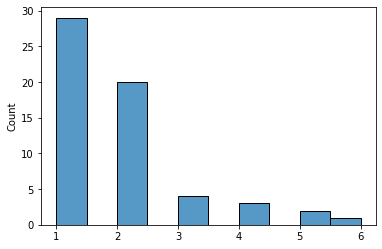

In [156]:
sns.histplot(min_choices)

In [158]:
num_choices = []
num_cols = []
min_choices = []
start_with_target = 0
for k, v in corrected_permutation.items():
    num_choices.append(len(v))
    num_cols.append(len(init_permutation[k][0]))
    len_choices_i = []
    for choice in v:
        if choice[0] == 0:
            start_with_target += 1
            break

In [160]:
start_with_target/len(corrected_permutation)

0.7457627118644068

In [32]:
# brute force perumate
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
for threshold in [0.5, 1.0, 1.5, 2.0]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        num_cols.append(batch["target_col_mask"].max().item())
        ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
        predict_init = logits.argmax().item()
        if 1 in target_col_mask and ood_score_min > threshold:
            total_mistakes += 1
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, len(col_idx_set) + 1):
                for subset in itertools.combinations(col_idx_set, r):
                    for x in itertools.permutations(subset):
                        if 0 not in x:
                            continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()
                        predict_temp = logits_temp.argmax().item()
                        if ood_score_temp < ood_score_min and predict_init != predict_temp:
                            ood_score_min = ood_score_temp 
                            logits = logits_temp.clone()
                
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)




    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************Threshold: 0.5****************************


/tmp/ipykernel_3359783/4127766715.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3359783/4127766715.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4083, ts_macro_f1=0.1855
ts_micro_f1=0.4489, ts_macro_f1=0.1968
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 1.0****************************


/tmp/ipykernel_3359783/4127766715.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3359783/4127766715.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4129, ts_macro_f1=0.1904
ts_micro_f1=0.4575, ts_macro_f1=0.2042
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 1.5****************************


/tmp/ipykernel_3359783/4127766715.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3359783/4127766715.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4138, ts_macro_f1=0.1938
ts_micro_f1=0.4593, ts_macro_f1=0.2125
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 2.0****************************


/tmp/ipykernel_3359783/4127766715.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3359783/4127766715.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4111, ts_macro_f1=0.1947
ts_micro_f1=0.4541, ts_macro_f1=0.2084
ts_micro_f1=0.3622, ts_macro_f1=0.1474


In [66]:
# brute force perumate, target column
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
for threshold in [0.9]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        num_cols.append(batch["target_col_mask"].max().item())

        cls_indexes = torch.tensor([0, 0]).reshape(1, -1).to(device)
        logits_temp = model(batch["data"].T[target_col_mask==0].reshape(1, -1), cls_indexes=cls_indexes,)    
        init_msp = F.softmax(logits_temp).max().item()
        logits = logits_temp.clone().detach().cpu()      

        if 1 in target_col_mask and init_msp < threshold:
            max_msp = init_msp
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, len(col_idx_set) + 1):
                for subset in itertools.combinations(col_idx_set, r):
                    for x in itertools.permutations(subset):
                        if 0 not in x:
                            continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        msp_temp = F.softmax(logits_temp).max().item()
                        # predict_temp = logits_temp.argmax().item()
                        if msp_temp > max_msp:
                            max_msp = msp_temp
                            logits = logits_temp.clone()
                
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)




    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************Threshold: 0.9****************************


/tmp/ipykernel_4054970/1658014317.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits_temp).max().item()
/tmp/ipykernel_4054970/1658014317.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4442, ts_macro_f1=0.1641
ts_micro_f1=0.4107, ts_macro_f1=0.1462
ts_micro_f1=0.4823, ts_macro_f1=0.1573


In [114]:
# brute force perumate, original answer
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
for threshold in [0.5, 0.6, 0.7, 0.8]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        num_cols.append(batch["target_col_mask"].max().item())
        init_msp = F.softmax(logits).max().item()

        if 1 in target_col_mask and init_msp < threshold:
            max_msp = init_msp
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, len(col_idx_set) + 1):
                for subset in itertools.combinations(col_idx_set, r):
                    for x in itertools.permutations(subset):
                        if 0 not in x:
                            continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        msp_temp = F.softmax(logits_temp).max().item()
                        # predict_temp = logits_temp.argmax().item()
                        if msp_temp > max_msp:
                            max_msp = msp_temp
                            logits = logits_temp.clone()
                
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)




    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************Threshold: 0.5****************************


/tmp/ipykernel_4054970/3892576816.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits).max().item()
/tmp/ipykernel_4054970/3892576816.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4498, ts_macro_f1=0.1765
ts_micro_f1=0.4211, ts_macro_f1=0.1604
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************Threshold: 0.6****************************


/tmp/ipykernel_4054970/3892576816.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits).max().item()
/tmp/ipykernel_4054970/3892576816.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4479, ts_macro_f1=0.1734
ts_micro_f1=0.4177, ts_macro_f1=0.1560
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************Threshold: 0.7****************************


/tmp/ipykernel_4054970/3892576816.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits).max().item()
/tmp/ipykernel_4054970/3892576816.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4507, ts_macro_f1=0.1720
ts_micro_f1=0.4229, ts_macro_f1=0.1554
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************Threshold: 0.8****************************


/tmp/ipykernel_4054970/3892576816.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits).max().item()
/tmp/ipykernel_4054970/3892576816.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4535, ts_macro_f1=0.1741
ts_micro_f1=0.4281, ts_macro_f1=0.1598
ts_micro_f1=0.4823, ts_macro_f1=0.1573


In [113]:
# brute force perumate, original answer, skip permuation not starting with 0
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
for threshold in [0.8, 0.85, 0.9, 0.95, 0.99]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        num_cols.append(batch["target_col_mask"].max().item())
        init_msp = F.softmax(logits).max().item()

        if 1 in target_col_mask and init_msp < threshold:
            max_msp = init_msp
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, len(col_idx_set) + 1):
                for subset in itertools.combinations(col_idx_set, r):
                    for x in itertools.permutations(subset):
                        if 0 not in x:
                            continue
                        if x[0] != 0:
                            continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        msp_temp = F.softmax(logits_temp).max().item()
                        # predict_temp = logits_temp.argmax().item()
                        if msp_temp > max_msp:
                            max_msp = msp_temp
                            logits = logits_temp.clone()
                
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)




    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************Threshold: 0.8****************************


/tmp/ipykernel_4054970/4188673808.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits).max().item()
/tmp/ipykernel_4054970/4188673808.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4498, ts_macro_f1=0.1714
ts_micro_f1=0.4211, ts_macro_f1=0.1564
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************Threshold: 0.85****************************


/tmp/ipykernel_4054970/4188673808.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits).max().item()
/tmp/ipykernel_4054970/4188673808.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4479, ts_macro_f1=0.1660
ts_micro_f1=0.4177, ts_macro_f1=0.1492
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************Threshold: 0.9****************************


/tmp/ipykernel_4054970/4188673808.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits).max().item()
/tmp/ipykernel_4054970/4188673808.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4461, ts_macro_f1=0.1661
ts_micro_f1=0.4142, ts_macro_f1=0.1494
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************Threshold: 0.95****************************


/tmp/ipykernel_4054970/4188673808.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits).max().item()
/tmp/ipykernel_4054970/4188673808.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4442, ts_macro_f1=0.1613
ts_micro_f1=0.4107, ts_macro_f1=0.1427
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************Threshold: 0.99****************************


/tmp/ipykernel_4054970/4188673808.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits).max().item()
/tmp/ipykernel_4054970/4188673808.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4387, ts_macro_f1=0.1594
ts_micro_f1=0.4003, ts_macro_f1=0.1393
ts_micro_f1=0.4823, ts_macro_f1=0.1573


In [106]:
# brute force perumate
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
for threshold in [0.8, 0.9]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        num_cols.append(batch["target_col_mask"].max().item())

        cls_indexes = torch.tensor([0, 0]).reshape(1, -1).to(device)
        logits_temp = model(batch["data"].T[target_col_mask==0].reshape(1, -1), cls_indexes=cls_indexes,)    
        init_msp = F.softmax(logits_temp).max().item()
        logits = logits_temp.clone().detach().cpu()      

        if 1 in target_col_mask and init_msp < threshold:
            max_msp = init_msp
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, len(col_idx_set) + 1):
                for subset in itertools.combinations(col_idx_set, r):
                    for x in itertools.permutations(subset):
                        if 0 not in x:
                            continue
                        # if x[0] != 0:
                        #     continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        msp_temp = F.softmax(logits_temp).max().item()
                        # predict_temp = logits_temp.argmax().item()
                        if msp_temp > max_msp:
                            max_msp = msp_temp
                            logits = logits_temp.clone()
                
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)




    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************Threshold: 0.8****************************


/tmp/ipykernel_4054970/3393821501.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits_temp).max().item()
/tmp/ipykernel_4054970/3393821501.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4442, ts_macro_f1=0.1663
ts_micro_f1=0.4107, ts_macro_f1=0.1525
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************Threshold: 0.9****************************


/tmp/ipykernel_4054970/3393821501.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits_temp).max().item()
/tmp/ipykernel_4054970/3393821501.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4415, ts_macro_f1=0.1657
ts_micro_f1=0.4055, ts_macro_f1=0.1513
ts_micro_f1=0.4823, ts_macro_f1=0.1573


In [33]:
# brute force perumate
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
for threshold in [0.5, 1.0, 1.5, 2.0]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        num_cols.append(batch["target_col_mask"].max().item())
        ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
        predict_init = logits.argmax().item()
        if 1 in target_col_mask and ood_score_min > threshold:
            total_mistakes += 1
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, len(col_idx_set) + 1):
                for subset in itertools.combinations(col_idx_set, r):
                    for x in itertools.permutations(subset):
                        if 0 not in x:
                            continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()
                        predict_temp = logits_temp.argmax().item()
                        if ood_score_temp < ood_score_min:
                            ood_score_min = ood_score_temp 
                            logits = logits_temp.clone()
                
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)




    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************Threshold: 0.5****************************


/tmp/ipykernel_3359783/3432584509.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3359783/3432584509.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4138, ts_macro_f1=0.1897
ts_micro_f1=0.4593, ts_macro_f1=0.2045
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 1.0****************************


/tmp/ipykernel_3359783/3432584509.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3359783/3432584509.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4184, ts_macro_f1=0.1936
ts_micro_f1=0.4679, ts_macro_f1=0.2097
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 1.5****************************


/tmp/ipykernel_3359783/3432584509.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3359783/3432584509.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4166, ts_macro_f1=0.1959
ts_micro_f1=0.4645, ts_macro_f1=0.2159
ts_micro_f1=0.3622, ts_macro_f1=0.1474
*********************Threshold: 2.0****************************


/tmp/ipykernel_3359783/3432584509.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_min = compute_entropy(F.softmax(logits.detach())).item()
/tmp/ipykernel_3359783/3432584509.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = compute_entropy(F.softmax(logits_temp.detach())).item()


ts_micro_f1=0.4120, ts_macro_f1=0.1950
ts_micro_f1=0.4558, ts_macro_f1=0.2090
ts_micro_f1=0.3622, ts_macro_f1=0.1474


In [32]:
labels_train = []
for batch_idx, batch in enumerate(train_dataloader_iter):
    labels_train.append(batch["label"].item())

In [23]:
# brute force perumate in training TODO: restrict mamimus length of permutation
import itertools
import torch.nn.functional as F

    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
max_col_length = 3
for threshold in [1.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0
    num_permutations = {}
    init_correctness = {}
    score_init = {}
    score_permutation = defaultdict(list)
    permutation_correctness = defaultdict(list)
    psermutation = defaultdict(list)
    init_permutation = {}
    labels_train = []
    for batch_idx, batch in enumerate(train_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        score_init[batch_idx] = F.softmax(logits.detach()).max().item()
        label_i = batch["label"].item()
        predict_init = logits.argmax().item()
        if predict_init == label_i:
            init_correctness[batch_idx] = True
        else:
            init_correctness[batch_idx] = False
        num_permutations[batch_idx] = 0
        init_permutation[batch_idx] = get_permutation(target_col_mask)
        if 1 in target_col_mask:
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, min(len(col_idx_set), max_col_length) + 1):
                for subset in itertools.combinations(col_idx_set, r):
                    if 0 not in subset:
                        continue
                    for x in itertools.permutations(subset):
                        num_permutations[batch_idx] += 1
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                        score_permutation[batch_idx].append(ood_score_temp)
                        psermutation[batch_idx].append(x)
                        predict_temp = logits_temp.argmax().item()
                        permutation_correctness[batch_idx].append(predict_temp == label_i)

*********************Threshold: 1.5****************************


/tmp/ipykernel_3443309/4234449694.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  score_init[batch_idx] = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_3443309/4234449694.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


In [25]:
len(num_permutations)

3463

In [16]:
list(psermutation.keys())[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [31]:
labels_train

[]

In [30]:
labels_train[0]

IndexError: list index out of range

In [33]:
print(len(num_permutations), len(score_init), len(init_correctness), len(init_permutation), len(labels_train))
for i in range(5):
    print(f"*********************{i}****************************")
    print(num_permutations[i],  score_init[i], init_correctness[i], init_permutation[i], labels_train[i])
    for j in range(num_permutations[i]):
        print(psermutation[i][j], score_permutation[i][j], permutation_correctness[i][j], )


3463 3463 3463 3463 3463
*********************0****************************
71 0.9998397827148438 True [0, 1, 2, 3, 4, 5] 0
(0,) 0.9997237324714661 True
(0, 1) 0.9998242259025574 True
(1, 0) 0.9702703356742859 True
(0, 2) 0.9998288154602051 True
(2, 0) 0.9412208199501038 True
(0, 3) 0.9998071789741516 True
(3, 0) 0.984877347946167 True
(0, 4) 0.999819815158844 True
(4, 0) 0.5845035314559937 False
(0, 5) 0.9998140931129456 True
(5, 0) 0.8895981311798096 True
(0, 1, 2) 0.9998341798782349 True
(0, 2, 1) 0.9998235106468201 True
(1, 0, 2) 0.996242880821228 True
(1, 2, 0) 0.999014139175415 True
(2, 0, 1) 0.9546687006950378 True
(2, 1, 0) 0.9930658340454102 True
(0, 1, 3) 0.9998353719711304 True
(0, 3, 1) 0.9998235106468201 True
(1, 0, 3) 0.9983983635902405 True
(1, 3, 0) 0.9993031024932861 True
(3, 0, 1) 0.988847017288208 True
(3, 1, 0) 0.9984265565872192 True
(0, 1, 4) 0.999829888343811 True
(0, 4, 1) 0.9997915625572205 True
(1, 0, 4) 0.9956591129302979 True
(1, 4, 0) 0.9916541576385498 Tru

In [15]:
len(psermutation)

3463

In [13]:
len(init_permutation)

3463

In [203]:
len(idx_list[(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)))])

484

In [250]:
for alpha in [0.25, 0.5, 1.0]:
    class_weights = (1.0 / class_freq) ** alpha

    # Normalize the weights
    class_weights /= class_weights.sum()
    
    
    print(f"*********************alpha: {alpha}****************************")
    msp_predict_mask_weighted = []
    for batch_idx, batch in enumerate(test_dataloader_iter):
        if batch_idx in idx_list[(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)))]:
            target_col_mask = batch["target_col_mask"].T
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            max_msp = 0
            for r in range(1, len(col_idx_set) + 1):
                for subset in itertools.combinations(col_idx_set, r):
                    if 0 not in subset:
                        continue
                    for x in itertools.permutations(subset):
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                        msp_temp = logits_temp.max().item()
                        predict_temp = logits_temp.argmax().item()
                        # print(x, msp_temp, predict_temp)
                        if msp_temp > max_msp and 0 in x:
                            max_msp = msp_temp
                            best_msp_perm = x
                            msp_predict = predict_temp
                            logits = logits_temp.clone()
            msp_predict_mask_weighted.append(msp_predict==batch["label"].item())
    print(sum(msp_predict_mask_weighted))
                    

*********************alpha: 0.25****************************
165
*********************alpha: 0.5****************************
166
*********************alpha: 1.0****************************
169


In [218]:
len(idx_list[(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)))& correct_msp_mask])

168

In [219]:
rest_idx = []
for idx in idx_list[(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)))& correct_msp_mask]:
    if idx not in idx_list[(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)))][msp_predict_mask_weighted]:
        rest_idx.append(idx)

In [220]:
len(rest_idx)

17

In [217]:
len(idx_list[(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)))][msp_predict_mask_weighted])

169

In [212]:
msp_predict_mask_weighted = torch.tensor(msp_predict_mask_weighted)

In [211]:
sum(msp_predict_mask_weighted)

169

In [411]:
len(idx_list[~condition_mask])

428

In [417]:
threshold

0.9

In [419]:

# brute force perumate
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
alpha = 0.5
class_weights = (1.0 / class_freq) ** alpha
msp_threshold = 0.9
# Normalize the weights
class_weights /= class_weights.sum()
for msp_threshold in [0.8,  0.95, 0.99]:
    for debias_threshold in [0.9]:
        print(f"*********************debias: {debias_threshold}; msp: {msp_threshold}****************************")
        ft_embs_test = []
        labels_test = []
        logits_test = []
        log = defaultdict(list)
        num_cols = []
        corrected = 0
        total_mistakes = 0

        for batch_idx, batch in enumerate(test_dataloader_iter):
            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            target_col_mask = batch["target_col_mask"].T
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            num_cols.append(batch["target_col_mask"].max().item())
            predict_init = logits.argmax().item()
            max_msp = 0
            if batch_idx in idx_list[~condition_mask]:
                col_idx_set = target_col_mask.unique().tolist()
                debias_classes = []
                assert -1 not in col_idx_set
                for r in range(1, len(col_idx_set) + 1):
                    for subset in itertools.combinations(col_idx_set, r):
                        # if 0 not in subset:
                        #     continue
                        for x in itertools.permutations(subset):
                            new_batch_data = []
                            for col_i in x:
                                if col_i == 0:
                                    if len(new_batch_data) == 0:
                                        cls_indexes_value = 0
                                    else:
                                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                            if 0 not in x:
                                cls_indexes_value = 0
                            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                            logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                            msp_temp = logits_temp.max().item()
                            predict_temp = logits_temp.argmax().item()
                            if len(x) == 1 and 0 in x:
                                predict_target = predict_temp
                                msp_target = msp_temp
                            # print(x, msp_temp, predict_temp)
                            if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                debias_classes.append(predict_temp)
                                continue
                            if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                max_msp = msp_temp
                                best_msp_perm = x
                                msp_predict = predict_temp
                                logits_msp = logits_temp.clone()
            if max_msp > msp_threshold:
                logits = logits_msp.clone()
            labels_test.append(batch["label"].cpu())
            logits_test.append(logits.detach().cpu())
        labels_test = torch.cat(labels_test, dim=0)
        logits_test = torch.stack(logits_test, dim=0)
        preds_test = torch.argmax(logits_test, dim=1)
        num_cols = torch.tensor(num_cols)




        from sklearn.metrics import confusion_matrix, f1_score
        mask = num_cols > 0
        ts_pred_list = logits_test.argmax(
                                    1).cpu().detach().numpy().tolist()
        ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                            ts_pred_list,
                            average="micro")
        ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                            ts_pred_list,
                            average="macro")
        print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
        ts_pred_list = logits_test.argmax(
                                    1).cpu().detach()[mask].numpy().tolist()
        ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                            ts_pred_list,
                            average="micro")
        ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                            ts_pred_list,
                            average="macro")
        print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
        ts_pred_list = logits_test.argmax(
                                    1).cpu().detach()[~mask].numpy().tolist()
        ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                            ts_pred_list,
                            average="micro")
        ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                            ts_pred_list,
                            average="macro")
        print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************debias: 0.9; msp: 0.8****************************
ts_micro_f1=0.4525, ts_macro_f1=0.1804
ts_micro_f1=0.4263, ts_macro_f1=0.1747
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************debias: 0.9; msp: 0.95****************************
ts_micro_f1=0.4571, ts_macro_f1=0.1903
ts_micro_f1=0.4350, ts_macro_f1=0.1862
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************debias: 0.9; msp: 0.99****************************
ts_micro_f1=0.4525, ts_macro_f1=0.1865
ts_micro_f1=0.4263, ts_macro_f1=0.1784
ts_micro_f1=0.4823, ts_macro_f1=0.1573


In [20]:

# brute force perumate
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
alpha = 0.25
class_weights = (1.0 / class_freq) ** alpha
msp_threshold = 0.9
# Normalize the weights
class_weights /= class_weights.sum()
for global_threshold in [ 0.7, 0.8, 0.9, 0.99]:
    for uncertainty_threshold in [global_threshold]:
        for msp_threshold in [global_threshold]:
            for debias_threshold in [global_threshold]:
                print(f"*********************uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        assert -1 not in col_idx_set
                        for r in range(1, len(col_idx_set) + 1):
                            for subset in itertools.combinations(col_idx_set, r):
                                # if 0 not in subset:
                                #     continue
                                for x in itertools.permutations(subset):
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    if len(x) == 1 and 0 in x:
                                        predict_target = predict_temp
                                        msp_target = msp_temp
                                    # print(x, msp_temp, predict_temp)
                                    if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                        debias_classes.append(predict_temp)
                                        continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************uncertain: 0.7; debias: 0.7; msp: 0.7****************************


In [423]:

# brute force perumate weighted
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
alpha = 0.5
class_weights = (1.0 / class_freq) ** alpha
msp_threshold = 0.9
# Normalize the weights
class_weights /= class_weights.sum()
for uncertainty_threshold in [0.9, 0.8, 0.95, 0.99]:
    for msp_threshold in [ 0.95, 0.9, 0.99]:
        for debias_threshold in [1.0]:
            print(f"*********************uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
            ft_embs_test = []
            labels_test = []
            logits_test = []
            log = defaultdict(list)
            num_cols = []
            corrected = 0
            total_mistakes = 0

            for batch_idx, batch in enumerate(test_dataloader_iter):
                cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                target_col_mask = batch["target_col_mask"].T
                logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                msp_init = F.softmax(logits).max().item()
                # logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                num_cols.append(batch["target_col_mask"].max().item())
                predict_init = logits.argmax().item()
                max_msp = 0
                if 1 in target_col_mask and msp_init < uncertainty_threshold:
                    col_idx_set = target_col_mask.unique().tolist()
                    debias_classes = []
                    assert -1 not in col_idx_set
                    for r in range(1, len(col_idx_set) + 1):
                        for subset in itertools.combinations(col_idx_set, r):
                            # if 0 not in subset:
                            #     continue
                            for x in itertools.permutations(subset):
                                new_batch_data = []
                                for col_i in x:
                                    if col_i == 0:
                                        if len(new_batch_data) == 0:
                                            cls_indexes_value = 0
                                        else:
                                            cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                    new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                if 0 not in x:
                                    cls_indexes_value = 0
                                new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                # logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                logits_temp = F.softmax(logits_temp)
                                msp_temp = logits_temp.max().item()
                                predict_temp = logits_temp.argmax().item()
                                if len(x) == 1 and 0 in x:
                                    predict_target = predict_temp
                                    msp_target = msp_temp
                                # print(x, msp_temp, predict_temp)
                                if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    debias_classes.append(predict_temp)
                                    continue
                                if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                    max_msp = msp_temp
                                    best_msp_perm = x
                                    msp_predict = predict_temp
                                    logits_msp = logits_temp.clone()
                if max_msp > msp_threshold:
                    logits = logits_msp.clone()
                labels_test.append(batch["label"].cpu())
                logits_test.append(logits.detach().cpu())
            labels_test = torch.cat(labels_test, dim=0)
            logits_test = torch.stack(logits_test, dim=0)
            preds_test = torch.argmax(logits_test, dim=1)
            num_cols = torch.tensor(num_cols)




            from sklearn.metrics import confusion_matrix, f1_score
            mask = num_cols > 0
            ts_pred_list = logits_test.argmax(
                                        1).cpu().detach().numpy().tolist()
            ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                ts_pred_list,
                                average="micro")
            ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                ts_pred_list,
                                average="macro")
            print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
            ts_pred_list = logits_test.argmax(
                                        1).cpu().detach()[mask].numpy().tolist()
            ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                ts_pred_list,
                                average="micro")
            ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                ts_pred_list,
                                average="macro")
            print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
            ts_pred_list = logits_test.argmax(
                                        1).cpu().detach()[~mask].numpy().tolist()
            ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                ts_pred_list,
                                average="micro")
            ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                ts_pred_list,
                                average="macro")
            print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************uncertain: 0.9; debias: 1.0; msp: 0.95****************************


/tmp/ipykernel_955267/2474143246.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = F.softmax(logits).max().item()
/tmp/ipykernel_955267/2474143246.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.4525, ts_macro_f1=0.1810
ts_micro_f1=0.4263, ts_macro_f1=0.1742
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************uncertain: 0.9; debias: 1.0; msp: 0.9****************************


/tmp/ipykernel_955267/2474143246.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = F.softmax(logits).max().item()
/tmp/ipykernel_955267/2474143246.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.4535, ts_macro_f1=0.1840
ts_micro_f1=0.4281, ts_macro_f1=0.1790
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************uncertain: 0.9; debias: 1.0; msp: 0.99****************************


/tmp/ipykernel_955267/2474143246.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = F.softmax(logits).max().item()
/tmp/ipykernel_955267/2474143246.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.4553, ts_macro_f1=0.1895
ts_micro_f1=0.4315, ts_macro_f1=0.1826
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************uncertain: 0.8; debias: 1.0; msp: 0.95****************************


/tmp/ipykernel_955267/2474143246.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = F.softmax(logits).max().item()
/tmp/ipykernel_955267/2474143246.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.4553, ts_macro_f1=0.1863
ts_micro_f1=0.4315, ts_macro_f1=0.1813
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************uncertain: 0.8; debias: 1.0; msp: 0.9****************************


/tmp/ipykernel_955267/2474143246.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = F.softmax(logits).max().item()
/tmp/ipykernel_955267/2474143246.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.4571, ts_macro_f1=0.1894
ts_micro_f1=0.4350, ts_macro_f1=0.1861
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************uncertain: 0.8; debias: 1.0; msp: 0.99****************************


/tmp/ipykernel_955267/2474143246.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = F.softmax(logits).max().item()
/tmp/ipykernel_955267/2474143246.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.4562, ts_macro_f1=0.1914
ts_micro_f1=0.4333, ts_macro_f1=0.1849
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************uncertain: 0.95; debias: 1.0; msp: 0.95****************************


/tmp/ipykernel_955267/2474143246.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = F.softmax(logits).max().item()
/tmp/ipykernel_955267/2474143246.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.4507, ts_macro_f1=0.1762
ts_micro_f1=0.4229, ts_macro_f1=0.1675
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************uncertain: 0.95; debias: 1.0; msp: 0.9****************************


/tmp/ipykernel_955267/2474143246.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = F.softmax(logits).max().item()
/tmp/ipykernel_955267/2474143246.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.4525, ts_macro_f1=0.1801
ts_micro_f1=0.4263, ts_macro_f1=0.1738
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************uncertain: 0.95; debias: 1.0; msp: 0.99****************************


/tmp/ipykernel_955267/2474143246.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = F.softmax(logits).max().item()
/tmp/ipykernel_955267/2474143246.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.4544, ts_macro_f1=0.1868
ts_micro_f1=0.4298, ts_macro_f1=0.1788
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************uncertain: 0.99; debias: 1.0; msp: 0.95****************************


/tmp/ipykernel_955267/2474143246.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = F.softmax(logits).max().item()
/tmp/ipykernel_955267/2474143246.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.4488, ts_macro_f1=0.1748
ts_micro_f1=0.4194, ts_macro_f1=0.1650
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************uncertain: 0.99; debias: 1.0; msp: 0.9****************************


/tmp/ipykernel_955267/2474143246.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = F.softmax(logits).max().item()
/tmp/ipykernel_955267/2474143246.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.4507, ts_macro_f1=0.1786
ts_micro_f1=0.4229, ts_macro_f1=0.1710
ts_micro_f1=0.4823, ts_macro_f1=0.1573
*********************uncertain: 0.99; debias: 1.0; msp: 0.99****************************


/tmp/ipykernel_955267/2474143246.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = F.softmax(logits).max().item()
/tmp/ipykernel_955267/2474143246.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.4535, ts_macro_f1=0.1856
ts_micro_f1=0.4281, ts_macro_f1=0.1765
ts_micro_f1=0.4823, ts_macro_f1=0.1573


In [11]:

# brute force perumate
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
# class_weights = (1.0 / class_freq) ** alpha
# msp_threshold = 0.9
# # Normalize the weights
# class_weights /= class_weights.sum()
max_col_length = 3
alpha = 0.0
# for global_threshold in [ 0.7, 0.8, 0.9, 0.99]:
for uncertainty_threshold in [0.8]:
    for msp_threshold in [0.9,0.99]:
        for debias_threshold in [0.8, 0.9, 1.0]:
            print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
            ft_embs_test = []
            labels_test = []
            logits_test = []
            log = defaultdict(list)
            num_cols = []
            corrected = 0
            total_mistakes = 0

            for batch_idx, batch in enumerate(test_dataloader_iter):
                cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                target_col_mask = batch["target_col_mask"].T
                logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                # logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                logits = F.softmax(logits)
                msp_init = logits.max().item()
                num_cols.append(batch["target_col_mask"].max().item())
                predict_init = logits.argmax().item()
                max_msp = 0
                if 1 in target_col_mask and msp_init < uncertainty_threshold:
                    col_idx_set = target_col_mask.unique().tolist()
                    debias_classes = []
                    assert -1 not in col_idx_set
                    for r in range(1, min(len(col_idx_set), max_col_length) + 1):
                        for subset in itertools.combinations(col_idx_set, r):
                            # if 0 not in subset:
                            #     continue
                            for x in itertools.permutations(subset):
                                new_batch_data = []
                                for col_i in x:
                                    if col_i == 0:
                                        if len(new_batch_data) == 0:
                                            cls_indexes_value = 0
                                        else:
                                            cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                    new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                if 0 not in x:
                                    cls_indexes_value = 0
                                new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                logits_temp = F.softmax(logits_temp)
                                # logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                msp_temp = logits_temp.max().item()
                                predict_temp = logits_temp.argmax().item()
                                if len(x) == 1 and 0 in x:
                                    predict_target = predict_temp
                                    msp_target = msp_temp
                                # print(x, msp_temp, predict_temp)
                                if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                    debias_classes.append(predict_temp)
                                    continue
                                if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                    max_msp = msp_temp
                                    best_msp_perm = x
                                    msp_predict = predict_temp
                                    logits_msp = logits_temp.clone()
                if max_msp > msp_threshold:
                    logits = logits_msp.clone()
                labels_test.append(batch["label"].cpu())
                logits_test.append(logits.detach().cpu())
            labels_test = torch.cat(labels_test, dim=0)
            logits_test = torch.stack(logits_test, dim=0)
            preds_test = torch.argmax(logits_test, dim=1)
            num_cols = torch.tensor(num_cols)




            from sklearn.metrics import confusion_matrix, f1_score
            mask = num_cols > 0
            ts_pred_list = logits_test.argmax(
                                        1).cpu().detach().numpy().tolist()
            ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                ts_pred_list,
                                average="micro")
            ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                ts_pred_list,
                                average="macro")
            print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
            ts_pred_list = logits_test.argmax(
                                        1).cpu().detach()[mask].numpy().tolist()
            ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                ts_pred_list,
                                average="micro")
            ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                ts_pred_list,
                                average="macro")
            print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
            ts_pred_list = logits_test.argmax(
                                        1).cpu().detach()[~mask].numpy().tolist()
            ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                ts_pred_list,
                                average="micro")
            ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                ts_pred_list,
                                average="macro")
            print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************alpha: 0.0; uncertain: 0.8; debias: 0.8; msp: 0.9****************************


/tmp/ipykernel_3329248/3394787178.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)
/tmp/ipykernel_3329248/3394787178.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.5401, ts_macro_f1=0.2688
ts_micro_f1=0.5397, ts_macro_f1=0.2688
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.0; uncertain: 0.8; debias: 0.9; msp: 0.9****************************


/tmp/ipykernel_3329248/3394787178.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)
/tmp/ipykernel_3329248/3394787178.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.5392, ts_macro_f1=0.2638
ts_micro_f1=0.5387, ts_macro_f1=0.2638
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.0; uncertain: 0.8; debias: 1.0; msp: 0.9****************************


/tmp/ipykernel_3329248/3394787178.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)
/tmp/ipykernel_3329248/3394787178.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.5373, ts_macro_f1=0.2664
ts_micro_f1=0.5369, ts_macro_f1=0.2664
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.0; uncertain: 0.8; debias: 0.8; msp: 0.99****************************


/tmp/ipykernel_3329248/3394787178.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)
/tmp/ipykernel_3329248/3394787178.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.5392, ts_macro_f1=0.2642
ts_micro_f1=0.5387, ts_macro_f1=0.2642
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.0; uncertain: 0.8; debias: 0.9; msp: 0.99****************************


/tmp/ipykernel_3329248/3394787178.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)
/tmp/ipykernel_3329248/3394787178.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.5392, ts_macro_f1=0.2642
ts_micro_f1=0.5387, ts_macro_f1=0.2642
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.0; uncertain: 0.8; debias: 1.0; msp: 0.99****************************


/tmp/ipykernel_3329248/3394787178.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(logits)
/tmp/ipykernel_3329248/3394787178.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits_temp = F.softmax(logits_temp)


ts_micro_f1=0.5392, ts_macro_f1=0.2669
ts_micro_f1=0.5387, ts_macro_f1=0.2669
ts_micro_f1=1.0000, ts_macro_f1=1.0000


In [ ]:
# *********************alpha: 0.0; uncertain: 0.8; debias: 0.8; msp: 0.8****************************
# /tmp/ipykernel_3329248/2673466228.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
#   logits = F.softmax(logits)
# /tmp/ipykernel_3329248/2673466228.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
#   logits_temp = F.softmax(logits_temp)
# ts_micro_f1=0.5401, ts_macro_f1=0.2692
# ts_micro_f1=0.5397, ts_macro_f1=0.2692
# ts_micro_f1=1.0000, ts_macro_f1=1.0000
# *********************alpha: 0.0; uncertai

In [430]:
alpha = 0.125
class_weights = (1.0 / class_freq) ** alpha
msp_threshold = 0.9
# Normalize the weights
class_weights /= class_weights.sum()
class_weights

tensor([0.0060, 0.0065, 0.0071, 0.0073, 0.0079, 0.0081, 0.0083, 0.0082, 0.0082,
        0.0086, 0.0083, 0.0084, 0.0085, 0.0086, 0.0086, 0.0086, 0.0090, 0.0088,
        0.0087, 0.0086, 0.0087, 0.0087, 0.0089, 0.0090, 0.0090, 0.0091, 0.0092,
        0.0093, 0.0094, 0.0095, 0.0096, 0.0092, 0.0100, 0.0094, 0.0095, 0.0096,
        0.0098, 0.0094, 0.0098, 0.0097, 0.0096, 0.0097, 0.0101, 0.0101, 0.0103,
        0.0098, 0.0100, 0.0100, 0.0107, 0.0100, 0.0105, 0.0104, 0.0105, 0.0103,
        0.0104, 0.0105, 0.0105, 0.0103, 0.0100, 0.0109, 0.0101, 0.0103, 0.0111,
        0.0103, 0.0111, 0.0104, 0.0109, 0.0109, 0.0103, 0.0101, 0.0107, 0.0104,
        0.0105, 0.0109, 0.0105, 0.0104, 0.0107, 0.0111, 0.0105, 0.0109, 0.0105,
        0.0105, 0.0111, 0.0116, 0.0109, 0.0107, 0.0109, 0.0116, 0.0105, 0.0116,
        0.0113, 0.0107, 0.0113, 0.0111, 0.0109, 0.0116, 0.0121, 0.0121, 0.0113,
        0.0111, 0.0113])

In [432]:
alpha = 1.0
class_weights = (1.0 / class_freq) ** alpha
msp_threshold = 0.9
# Normalize the weights
class_weights /= class_weights.sum()
class_weights

tensor([0.0001, 0.0002, 0.0005, 0.0006, 0.0012, 0.0015, 0.0017, 0.0015, 0.0017,
        0.0023, 0.0017, 0.0020, 0.0022, 0.0023, 0.0024, 0.0023, 0.0035, 0.0029,
        0.0025, 0.0025, 0.0026, 0.0027, 0.0031, 0.0035, 0.0033, 0.0037, 0.0039,
        0.0042, 0.0046, 0.0053, 0.0056, 0.0041, 0.0076, 0.0046, 0.0050, 0.0059,
        0.0066, 0.0048, 0.0066, 0.0062, 0.0056, 0.0062, 0.0088, 0.0088, 0.0096,
        0.0066, 0.0082, 0.0082, 0.0133, 0.0082, 0.0118, 0.0106, 0.0118, 0.0096,
        0.0106, 0.0118, 0.0118, 0.0096, 0.0082, 0.0151, 0.0088, 0.0096, 0.0177,
        0.0096, 0.0177, 0.0106, 0.0151, 0.0151, 0.0096, 0.0088, 0.0133, 0.0106,
        0.0118, 0.0151, 0.0118, 0.0106, 0.0133, 0.0177, 0.0118, 0.0151, 0.0118,
        0.0118, 0.0177, 0.0265, 0.0151, 0.0133, 0.0151, 0.0265, 0.0118, 0.0265,
        0.0212, 0.0133, 0.0212, 0.0177, 0.0151, 0.0265, 0.0353, 0.0353, 0.0212,
        0.0177, 0.0212])

In [433]:
epsilon = 1e-6  # Small constant to prevent division by zero
class_weights = (1.0 / torch.log(class_freq))
class_weights /= class_weights.sum()
class_weights

tensor([0.0036, 0.0039, 0.0045, 0.0047, 0.0054, 0.0056, 0.0058, 0.0057, 0.0058,
        0.0063, 0.0058, 0.0060, 0.0062, 0.0063, 0.0063, 0.0063, 0.0071, 0.0067,
        0.0064, 0.0064, 0.0065, 0.0065, 0.0068, 0.0071, 0.0069, 0.0071, 0.0073,
        0.0075, 0.0077, 0.0080, 0.0081, 0.0074, 0.0091, 0.0077, 0.0079, 0.0083,
        0.0087, 0.0078, 0.0087, 0.0085, 0.0081, 0.0085, 0.0097, 0.0097, 0.0100,
        0.0087, 0.0094, 0.0094, 0.0115, 0.0094, 0.0109, 0.0104, 0.0109, 0.0100,
        0.0104, 0.0109, 0.0109, 0.0100, 0.0094, 0.0123, 0.0097, 0.0100, 0.0134,
        0.0100, 0.0134, 0.0104, 0.0123, 0.0123, 0.0100, 0.0097, 0.0115, 0.0104,
        0.0109, 0.0123, 0.0109, 0.0104, 0.0115, 0.0134, 0.0109, 0.0123, 0.0109,
        0.0109, 0.0134, 0.0173, 0.0123, 0.0115, 0.0123, 0.0173, 0.0109, 0.0173,
        0.0149, 0.0115, 0.0149, 0.0134, 0.0123, 0.0173, 0.0218, 0.0218, 0.0149,
        0.0134, 0.0149])

In [520]:

# brute force perumate
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
alpha = 0.125
class_weights = (1.0 / class_freq) ** alpha
msp_threshold = 0.9
# Normalize the weights
class_weights /= class_weights.sum()
max_col_length = 3
for alpha in [0.125, 0.5]:
    for uncertainty_threshold in [0.9, 0.8]:
        for msp_threshold in [ 0.8, 0.9, 0.99]:
            for debias_threshold in [1.0, 0.9, 0.8]:
                print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                corrected = 0
                total_mistakes = 0

                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
                    logits = reweight_logits(logits.detach().cpu(), class_weights) # Here !!!!!!!!!!
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    predict_init = logits.argmax().item()
                    max_msp = 0
                    if 1 in target_col_mask and msp_init < uncertainty_threshold:
                        col_idx_set = target_col_mask.unique().tolist()
                        debias_classes = []
                        assert -1 not in col_idx_set
                        for r in range(1, min(len(col_idx_set), max_col_length) + 1):
                            for subset in itertools.combinations(col_idx_set, r):
                                # if 0 not in subset:
                                #     continue
                                for x in itertools.permutations(subset):
                                    new_batch_data = []
                                    for col_i in x:
                                        if col_i == 0:
                                            if len(new_batch_data) == 0:
                                                cls_indexes_value = 0
                                            else:
                                                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                                    if 0 not in x:
                                        cls_indexes_value = 0
                                    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                    logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                    logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                    msp_temp = logits_temp.max().item()
                                    predict_temp = logits_temp.argmax().item()
                                    if len(x) == 1 and 0 in x:
                                        predict_target = predict_temp
                                        msp_target = msp_temp
                                    # print(x, msp_temp, predict_temp)
                                    if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                        debias_classes.append(predict_temp)
                                        continue
                                    if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                        max_msp = msp_temp
                                        best_msp_perm = x
                                        msp_predict = predict_temp
                                        logits_msp = logits_temp.clone()
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)




                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************alpha: 0.125; uncertain: 0.9; debias: 1.0; msp: 0.8****************************
ts_micro_f1=0.4903, ts_macro_f1=0.2054
ts_micro_f1=0.4899, ts_macro_f1=0.2054
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.125; uncertain: 0.9; debias: 0.9; msp: 0.8****************************
ts_micro_f1=0.4995, ts_macro_f1=0.2089
ts_micro_f1=0.4991, ts_macro_f1=0.2089
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.125; uncertain: 0.9; debias: 0.8; msp: 0.8****************************
ts_micro_f1=0.5005, ts_macro_f1=0.2091
ts_micro_f1=0.5000, ts_macro_f1=0.2091
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.125; uncertain: 0.9; debias: 1.0; msp: 0.9****************************
ts_micro_f1=0.4903, ts_macro_f1=0.2032
ts_micro_f1=0.4899, ts_macro_f1=0.2032
ts_micro_f1=1.0000, ts_macro_f1=1.0000
*********************alpha: 0.125; uncertain: 0.9; debias: 0.9; msp: 0.9****************************
ts_micro_f1=0.5005, ts_macr

In [ ]:
# *********************alpha: 0.125; uncertain: 0.8; debias: 0.8; msp: 0.9****************************
# ts_micro_f1=0.5023, ts_macro_f1=0.2253
# ts_micro_f1=0.5018, ts_macro_f1=0.2253
# ts_micro_f1=1.0000, ts_macro_f1=1.0000

In [518]:

# brute force perumate
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
alpha = 0.125
class_weights = (1.0 / class_freq) ** alpha
msp_threshold = 0.9
# Normalize the weights
class_weights /= class_weights.sum()

print(f"*********************alpha: {alpha}; uncertain: {uncertainty_threshold}; debias: {debias_threshold}; msp: {msp_threshold}****************************")
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
corrected = 0
total_mistakes = 0

for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test_init_origin = torch.stack(logits_test, dim=0)
num_cols = torch.tensor(num_cols)



*********************alpha: 0.125; uncertain: 0.8; debias: 1.0; msp: 0.9****************************


In [442]:
    logits = reweight_logits(logits_test_init_origin.detach().cpu(), class_weights) # Here !!!!!!!!!!
    ood_score = logits.max(1)[0]
    preds_test = torch.argmax(logits, dim=1)

In [443]:
preds_test.shape

torch.Size([1085])

In [444]:
import torch.nn.functional as F
for alpha in [0.125, 0.25, 0.5, 1.0, 1.1, 0.00001]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    logits = reweight_logits(logits_test_init_origin.detach().cpu(), class_weights) # Here !!!!!!!!!!
    ood_score = logits.max(1)[0]
    preds_test = torch.argmax(logits, dim=1)
    ood_labels = torch.tensor(preds_test == labels_test).float()
    from sklearn.metrics import roc_auc_score

    print(alpha, roc_auc_score(ood_labels, ood_score))

torch.Size([1085])

In [519]:
import torch.nn.functional as F
for alpha in [0.125, 0.25, 0.5, 1.0, 1.1]:
    class_weights = (1.0 / class_freq) ** alpha
    # Normalize the weights
    class_weights /= class_weights.sum()
    logits = reweight_logits(logits_test_init_origin.detach().cpu(), class_weights) # Here !!!!!!!!!!
    ood_score = logits.max(1)[0]
    preds_test = torch.argmax(logits, dim=1)
    ood_labels = torch.tensor(preds_test == labels_test).float()
    from sklearn.metrics import roc_auc_score

    print(alpha, roc_auc_score(ood_labels, ood_score))

/tmp/ipykernel_955267/324254938.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ood_labels = torch.tensor(preds_test == labels_test).float()
/tmp/ipykernel_955267/324254938.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ood_labels = torch.tensor(preds_test == labels_test).float()
/tmp/ipykernel_955267/324254938.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ood_labels = torch.tensor(preds_test == labels_test).float()
/tmp/ipykernel_955267/324254938.py:9: UserWarning: To copy construct from a tensor, it is recommended to use 

0.125 0.8552294444670989
0.25 0.8552643204741319
0.5 0.8713294825216694
1.0 0.8697046905697448
1.1 0.8617813386815106


/tmp/ipykernel_955267/324254938.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ood_labels = torch.tensor(preds_test == labels_test).float()


In [ ]:
# *********************uncertain: 0.8; debias: 0.8; msp: 0.99****************************
# /tmp/ipykernel_955267/1017438977.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
#   msp_init = F.softmax(logits).max().item()
# /tmp/ipykernel_955267/1017438977.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
#   logits_temp = F.softmax(logits_temp)
# ts_micro_f1=0.4571, ts_macro_f1=0.1923
# ts_micro_f1=0.4350, ts_macro_f1=0.1870
# ts_micro_f1=0.4823, ts_macro_f1=0.1573

# *********************uncertain: 0.8; debias: 1.0; msp: 0.99****************************
# /tmp/ipykernel_955267/2474143246.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
#   msp_init = F.softmax(logits).max().item()
# /tmp/ipykernel_955267/2474143246.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
#   logits_temp = F.softmax(logits_temp)
# ts_micro_f1=0.4562, ts_macro_f1=0.1914
# ts_micro_f1=0.4333, ts_macro_f1=0.1849
# ts_micro_f1=0.4823, ts_macro_f1=0.1573


# *********************alpha: 0.125; uncertain: 0.8; debias: 0.9; msp: 0.99****************************
# ts_micro_f1=0.4590, ts_macro_f1=0.1915
# ts_micro_f1=0.4350, ts_macro_f1=0.1807
# ts_micro_f1=0.4862, ts_macro_f1=0.1626

In [ ]:
# uncertain init (0.9)
# *********************debias: 0.9; msp: 0.95****************************
# ts_micro_f1=0.4571, ts_macro_f1=0.1903
# ts_micro_f1=0.4350, ts_macro_f1=0.1862
# ts_micro_f1=0.4823, ts_macro_f1=0.1573

In [15]:

# brute force perumate, find uncertain init prediction
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
idx_list = []
uncertain_init_mask = []
uncertain_target_mask = []
correct_init_mask = []
correct_target_mask = []
correct_permutation_mask = []
correct_msp_mask = []
init_target_mask = []
ood_score_init_list = []
ood_score_target_list = []


alpha = 1.0
class_weights = (1.0 / class_freq) ** alpha

# Normalize the weights
class_weights /= class_weights.sum()
for threshold in [0.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        if 1 in target_col_mask:
            idx_list.append(batch_idx)

            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            num_cols.append(batch["target_col_mask"].max().item())
            ood_score_init = F.softmax(logits.detach()).max().item()
            ood_score_init_list.append(ood_score_init)
            uncertain_init_mask.append(ood_score_init < threshold)
            predict_init = logits.argmax().item()
            correct_init_mask.append(predict_init == batch["label"].item())
            
            cls_indexes = torch.tensor([0, 0]).reshape(1, -1).to(device)
            logits_temp = model(batch["data"].T[target_col_mask==0].reshape(1, -1), cls_indexes=cls_indexes,)    
            ood_score_target = F.softmax(logits_temp.detach()).max().item()
            ood_score_target_list.append(ood_score_target)
            uncertain_target_mask.append(ood_score_target < threshold)
            predict_target = logits_temp.argmax().item()
            correct_target_mask.append(predict_target == batch["label"].item())
            
            init_target_mask.append(predict_target == predict_init)
            
            correct_permutation = False
            ood_score_max = 0
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, len(col_idx_set) + 1):
                for subset in itertools.combinations(col_idx_set, r):
                    for x in itertools.permutations(subset):
                        if 0 not in x:
                            continue
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        ood_score_temp =F.softmax(logits_temp.detach()).max().item()
                        predict_temp = logits_temp.argmax().item()
                        if ood_score_temp > ood_score_max:
                            ood_score_max = ood_score_temp 
                            predict_ood = logits_temp.argmax().item()
                        if predict_temp == batch["label"].item():
                            correct_permutation = True
            correct_permutation_mask.append(correct_permutation)
            correct_msp_mask.append(predict_ood == batch["label"].item())
            

*********************Threshold: 0.5****************************


/tmp/ipykernel_955267/2547658102.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_init = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_955267/2547658102.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_target = F.softmax(logits_temp.detach()).max().item()
/tmp/ipykernel_955267/2547658102.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp =F.softmax(logits_temp.detach()).max().item()


In [316]:

# brute force perumate, find uncertain init prediction, weighted msp
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
change_log = []
score_init = []
score_best = [] 
idx_list = []
uncertain_init_mask = []
uncertain_target_mask = []
correct_init_mask = []
correct_target_mask = []
correct_permutation_mask = []
correct_msp_mask = []
init_target_mask = []
ood_score_init_list = []
ood_score_target_list = []
ood_score_final_list = []

alpha = 1.0
class_weights = (1.0 / class_freq) ** alpha
debias_threshold = 0.9
# Normalize the weights
class_weights /= class_weights.sum()
for threshold in [0.5]:
    print(f"*********************Threshold: {threshold}****************************")
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    corrected = 0
    total_mistakes = 0

    for batch_idx, batch in enumerate(test_dataloader_iter):
        target_col_mask = batch["target_col_mask"].T
        if 1 in target_col_mask:
            idx_list.append(batch_idx)

            cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
            logits = model(batch["data"].T, cls_indexes=cls_indexes,)
            logits = reweight_logits(logits.detach().cpu(), class_weights)
            num_cols.append(batch["target_col_mask"].max().item())         
            ood_score_init = logits.max().item()
            ood_score_init_list.append(ood_score_init)
            uncertain_init_mask.append(ood_score_init < threshold)
            predict_init = logits.argmax().item()
            correct_init_mask.append(predict_init == batch["label"].item())
            
            cls_indexes = torch.tensor([0, 0]).reshape(1, -1).to(device)
            logits_temp = model(batch["data"].T[target_col_mask==0].reshape(1, -1), cls_indexes=cls_indexes,)  
            logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
            ood_score_target = logits_temp.max().item()
            ood_score_target_list.append(ood_score_target)
            uncertain_target_mask.append(ood_score_target < threshold)
            predict_target = logits_temp.argmax().item()
            correct_target_mask.append(predict_target == batch["label"].item())
            

            init_target_mask.append(predict_target == predict_init)
            
            correct_permutation = False
            ood_score_max = max_msp = 0
            max_msp_debiased = 0
            debias_class = []
            col_idx_set = target_col_mask.unique().tolist()
            assert -1 not in col_idx_set
            for r in range(1, len(col_idx_set) + 1):
                for subset in itertools.combinations(col_idx_set, r):
                    # if 0 not in subset:
                    #     continue
                    for x in itertools.permutations(subset):
                        new_batch_data = []
                        for col_i in x:
                            if col_i == 0:
                                if len(new_batch_data) == 0:
                                    cls_indexes_value = 0
                                else:
                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                            new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                        msp_temp = logits_temp.max().item()
                        predict_temp = logits_temp.argmax().item()
                        if 0 not in x and msp_temp > debias_threshold and (predict_temp!=predict_target or predict_temp!=predict_init):
                            debias_class.append(predict_temp)
                            continue
                        # print(x, msp_temp, predict_temp)
                        if msp_temp > max_msp and 0 in x and predict_temp not in debias_class:
                            max_msp = msp_temp
                            msp_predict = predict_temp
                        if predict_temp == batch["label"].item():
                            correct_permutation = True
            ood_score_final_list.append(max_msp)
            correct_permutation_mask.append(correct_permutation)
            correct_msp_mask.append(msp_predict == batch["label"].item())

*********************Threshold: 0.5****************************


In [318]:

idx_list = torch.tensor(idx_list)
uncertain_init_mask = torch.tensor(uncertain_init_mask)
uncertain_target_mask = torch.tensor(uncertain_target_mask)
correct_init_mask = torch.tensor(correct_init_mask)
correct_target_mask = torch.tensor(correct_target_mask)
correct_permutation_mask = torch.tensor(correct_permutation_mask)
correct_msp_mask = torch.tensor(correct_msp_mask)
init_target_mask = torch.tensor(init_target_mask)
ood_score_init_list = torch.tensor(ood_score_init_list)
ood_score_target_list = torch.tensor(ood_score_target_list)
ood_score_final_list = torch.tensor(ood_score_final_list)
print(len(idx_list), len(uncertain_init_mask), len(uncertain_target_mask), len(init_target_mask), len(correct_init_mask), len(correct_target_mask), len(correct_permutation_mask), len(correct_msp_mask))


# torch.save({"idx_list": idx_list, "uncertain_init_mask": uncertain_init_mask, "uncertain_target_mask": uncertain_target_mask, "correct_init_mask": correct_init_mask, "correct_target_mask": correct_target_mask, "correct_permutation_mask": correct_permutation_mask, "correct_msp_mask": correct_msp_mask, "init_target_mask": init_target_mask, "ood_score_init_list": ood_score_init_list, "ood_score_target_list": ood_score_target_list}, "./results/brute_force_permutation.pth")

577 577 577 577 577 577 577 577


/tmp/ipykernel_955267/1309743969.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx_list = torch.tensor(idx_list)
/tmp/ipykernel_955267/1309743969.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  uncertain_init_mask = torch.tensor(uncertain_init_mask)
/tmp/ipykernel_955267/1309743969.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  uncertain_target_mask = torch.tensor(uncertain_target_mask)
/tmp/ipykernel_955267/1309743969.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach()

In [319]:
len(ood_score_final_list)

577

In [328]:
prefix_mask = (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)))

In [335]:
print(sum(prefix_mask), correct_msp_mask[prefix_mask].sum()/sum(prefix_mask))

tensor(484) tensor(0.3326)


In [393]:
threshold = 0.95
print(sum(prefix_mask&(ood_score_final_list>threshold)), correct_msp_mask[prefix_mask&(ood_score_final_list>threshold)].sum(), correct_msp_mask[prefix_mask&(ood_score_final_list>threshold)].sum()/sum(prefix_mask&(ood_score_final_list>threshold)))

tensor(76) tensor(31) tensor(0.4079)


In [392]:
threshold = 0.95
print(sum(prefix_mask&(ood_score_final_list>threshold)), correct_init_mask[prefix_mask&(ood_score_final_list>threshold)].sum(), correct_init_mask[prefix_mask&(ood_score_final_list>threshold)].sum()/sum(prefix_mask&(ood_score_final_list>threshold)))

tensor(76) tensor(34) tensor(0.4474)


In [355]:
(correct_init_mask[prefix_mask&(ood_score_final_list>threshold)]&correct_init_mask[prefix_mask&(ood_score_final_list>threshold)]).sum()

tensor(88)

In [357]:
(correct_init_mask[prefix_mask&(ood_score_final_list>threshold)]&correct_msp_mask[prefix_mask&(ood_score_final_list>threshold)]).sum()

tensor(68)

In [358]:
(correct_init_mask[prefix_mask&(ood_score_final_list>threshold)]|correct_msp_mask[prefix_mask&(ood_score_final_list>threshold)]).sum()

tensor(108)

In [366]:
msp_new_idx = []
for i in idx_list[correct_msp_mask&prefix_mask&(ood_score_final_list>threshold)]:
    if i not in idx_list[correct_init_mask&prefix_mask&(ood_score_final_list>threshold)]:
        msp_new_idx.append(i)
msp_new_idx = torch.tensor(msp_new_idx)
init_new_idx = []
for i in idx_list[correct_init_mask&prefix_mask&(ood_score_final_list>threshold)]:
    if i not in idx_list[correct_msp_mask&prefix_mask&(ood_score_final_list>threshold)]:
        init_new_idx.append(i)
init_new_idx = torch.tensor(init_new_idx)

In [ ]:
init_target_mask

In [90]:
target_id_list_pos = idx_list[(uncertain_init_mask & uncertain_target_mask) & correct_permutation_mask & correct_msp_mask ]
print(len(target_id_list_pos))

5


In [91]:
target_id_list_neg = idx_list[(uncertain_init_mask & uncertain_target_mask) & correct_permutation_mask & ~correct_msp_mask ]
print(len(target_id_list_neg))

9


In [53]:
print(len(uncertain_init_mask), len(idx_list[(uncertain_init_mask | uncertain_target_mask)]), correct_permutation_mask.sum().item())

577 203 322


In [107]:
print(correct_msp_mask.sum().item(), correct_msp_mask.sum().item()/len(correct_msp_mask), 
      correct_init_mask.sum().item(), correct_init_mask.sum().item()/len(correct_init_mask), 
      correct_target_mask.sum().item(), correct_target_mask.sum().item()/len(correct_target_mask))

239 0.41421143847487 244 0.42287694974003465 229 0.3968804159445407


In [81]:
print(correct_msp_mask.sum().item()/len(correct_msp_mask), correct_init_mask.sum().item()/len(correct_msp_mask), correct_target_mask.sum().item()/len(correct_msp_mask))

0.41421143847487 0.42287694974003465 0.3968804159445407


In [86]:
print((init_target_mask&correct_init_mask).sum().item(), init_target_mask.sum().item(), (init_target_mask&correct_init_mask).sum().item()/init_target_mask.sum().item())

193 338 0.5710059171597633


In [123]:
print("Init")
# init prediction
print((init_target_mask&((~uncertain_init_mask & ~uncertain_target_mask)&correct_init_mask)).sum().item(), 
      (init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item(), 
      (init_target_mask&correct_init_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item()/(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item())
# init prediction
print((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask).sum().item(), (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item(), 
      (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask).sum().item()/(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item())
print("MSP")
# msp prediction
print((init_target_mask&((~uncertain_init_mask & ~uncertain_target_mask)&correct_msp_mask)).sum().item(), 
      (init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item(), 
      (init_target_mask&correct_msp_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item()/(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item())
# msp prediction
print((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask).sum().item(), (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item(), 
      (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask).sum().item()/(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item())

Init
175 282 0.6205673758865248
69 295 0.23389830508474577
MSP
180 282 0.6382978723404256
59 295 0.2


In [256]:
print(len(uncertain_init_mask), len(uncertain_target_mask), len(correct_init_mask), len(init_target_mask))

577 577 577 319


In [263]:
(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum()

tensor(93)

In [300]:
# Weighted
for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((init_target_mask&((~uncertain_init_mask & ~uncertain_target_mask)&correct_init_mask)).sum().item(), 
        (init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item(), 
        (init_target_mask&correct_init_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item()/(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item())
    # init prediction
    print((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask).sum().item(), (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item(), 
        (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask).sum().item()/(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item())
    print("MSP")
    # msp prediction
    print((init_target_mask&((~uncertain_init_mask & ~uncertain_target_mask)&correct_msp_mask)).sum().item(), 
        (init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item(), 
        (init_target_mask&correct_msp_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item()/(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item())
    # msp prediction
    print((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask).sum().item(), (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item(), 
        (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask).sum().item()/(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item())

*********************Threshold: 0.5****************************
Init
140 209 0.6698564593301436
94 368 0.2554347826086957
MSP
136 209 0.6507177033492823
100 368 0.2717391304347826
*********************Threshold: 0.6****************************
Init
127 182 0.6978021978021978
107 395 0.2708860759493671
MSP
123 182 0.6758241758241759
113 395 0.28607594936708863
*********************Threshold: 0.7****************************
Init
120 167 0.718562874251497
114 410 0.2780487804878049
MSP
117 167 0.7005988023952096
119 410 0.29024390243902437
*********************Threshold: 0.8****************************
Init
103 139 0.7410071942446043
131 438 0.2990867579908676
MSP
101 139 0.7266187050359713
135 438 0.3082191780821918
*********************Threshold: 0.9****************************
Init
76 93 0.8172043010752689
158 484 0.32644628099173556
MSP
75 93 0.8064516129032258
161 484 0.33264462809917356


In [124]:
for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((init_target_mask&((~uncertain_init_mask & ~uncertain_target_mask)&correct_init_mask)).sum().item(), 
        (init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item(), 
        (init_target_mask&correct_init_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item()/(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item())
    # init prediction
    print((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask).sum().item(), (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item(), 
        (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask).sum().item()/(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item())
    print("MSP")
    # msp prediction
    print((init_target_mask&((~uncertain_init_mask & ~uncertain_target_mask)&correct_msp_mask)).sum().item(), 
        (init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item(), 
        (init_target_mask&correct_msp_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item()/(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item())
    # msp prediction
    print((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask).sum().item(), (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item(), 
        (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask).sum().item()/(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item())

*********************Threshold: 0.5****************************
Init
175 282 0.6205673758865248
69 295 0.23389830508474577
MSP
180 282 0.6382978723404256
59 295 0.2
*********************Threshold: 0.6****************************
Init
169 266 0.6353383458646616
75 311 0.24115755627009647
MSP
173 266 0.650375939849624
66 311 0.21221864951768488
*********************Threshold: 0.7****************************
Init
156 236 0.6610169491525424
88 341 0.25806451612903225
MSP
159 236 0.673728813559322
80 341 0.23460410557184752
*********************Threshold: 0.8****************************
Init
152 219 0.6940639269406392
92 358 0.2569832402234637
MSP
153 219 0.6986301369863014
86 358 0.24022346368715083
*********************Threshold: 0.9****************************
Init
139 191 0.7277486910994765
105 386 0.27202072538860106
MSP
140 191 0.7329842931937173
99 386 0.25647668393782386


In [134]:
for threshold in [0.5, 0.8, 0.9, 0.95, 0.99]:
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((init_target_mask&((~uncertain_init_mask & ~uncertain_target_mask)&correct_init_mask)).sum().item(), 
        (init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item(), 
        (init_target_mask&correct_init_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item()/(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item())
    # init prediction
    print((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask).sum().item(), 
          (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item(), 
        (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask).sum().item()/(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item())
    print("MSP")
    # msp prediction
    print((init_target_mask&((~uncertain_init_mask & ~uncertain_target_mask)&correct_msp_mask)).sum().item(), 
        (init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item(), 
        (init_target_mask&correct_msp_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item()/(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item())
    # msp prediction
    print((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask).sum().item(), 
          (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item(), 
        (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask).sum().item()/(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item())
    print("MSP & Init")
    print(((init_target_mask&((~uncertain_init_mask & ~uncertain_target_mask)&correct_init_mask))&(init_target_mask&((~uncertain_init_mask & ~uncertain_target_mask)&correct_msp_mask))).sum().item())
    print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)|(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item(),
          ((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)|(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item()/(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item())
    print("Permutation")
    print((init_target_mask&((~uncertain_init_mask & ~uncertain_target_mask)&correct_permutation_mask)).sum().item(), 
        (init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item(), 
        (init_target_mask&correct_permutation_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item()/(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item())
    # msp prediction
    print((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_permutation_mask).sum().item(), 
          (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item(), 
        (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_permutation_mask).sum().item()/(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item())

*********************Threshold: 0.5****************************
Init
175 282 0.6205673758865248
69 295 0.23389830508474577
MSP
180 282 0.6382978723404256
59 295 0.2
MSP & Init
175
29
99 0.33559322033898303
Permutation
194 282 0.6879432624113475
128 295 0.43389830508474575
*********************Threshold: 0.8****************************
Init
152 219 0.6940639269406392
92 358 0.2569832402234637
MSP
153 219 0.6986301369863014
86 358 0.24022346368715083
MSP & Init
152
52
126 0.35195530726256985
Permutation
162 219 0.7397260273972602
160 358 0.44692737430167595
*********************Threshold: 0.9****************************
Init
139 191 0.7277486910994765
105 386 0.27202072538860106
MSP
140 191 0.7329842931937173
99 386 0.25647668393782386
MSP & Init
139
65
139 0.3601036269430052
Permutation
147 191 0.7696335078534031
175 386 0.4533678756476684
*********************Threshold: 0.95****************************
Init
118 159 0.7421383647798742
126 418 0.3014354066985646
MSP
119 159 0.74842767295

In [325]:
# weighted
for threshold in [0.5, 0.8, 0.9]:
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((init_target_mask&((~uncertain_init_mask & ~uncertain_target_mask)&correct_init_mask)).sum().item(), 
        (init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item(), 
        (init_target_mask&correct_init_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item()/(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item())
    # init prediction
    print((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask).sum().item(), 
          (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item(), 
        (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask).sum().item()/(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item())
    print("MSP")
    # msp prediction
    print((init_target_mask&((~uncertain_init_mask & ~uncertain_target_mask)&correct_msp_mask)).sum().item(), 
        (init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item(), 
        (init_target_mask&correct_msp_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item()/(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item())
    # msp prediction
    print((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask).sum().item(), 
          (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item(), 
        (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask).sum().item()/(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item())
    print("MSP & Init")
    print(((init_target_mask&((~uncertain_init_mask & ~uncertain_target_mask)&correct_init_mask))&(init_target_mask&((~uncertain_init_mask & ~uncertain_target_mask)&correct_msp_mask))).sum().item())
    print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)|(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item(),
          ((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)|(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item()/(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item())
    print("Permutation")
    print((init_target_mask&((~uncertain_init_mask & ~uncertain_target_mask)&correct_permutation_mask)).sum().item(), 
        (init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item(), 
        (init_target_mask&correct_permutation_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item()/(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item())
    # msp prediction
    print((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_permutation_mask).sum().item(), 
          (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item(), 
        (~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_permutation_mask).sum().item()/(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))).sum().item())

*********************Threshold: 0.5****************************
Init
140 209 0.6698564593301436
94 368 0.2554347826086957
MSP
136 209 0.6507177033492823
100 368 0.2717391304347826
MSP & Init
135
62
132 0.358695652173913
Permutation
150 209 0.7177033492822966
161 368 0.4375
*********************Threshold: 0.8****************************
Init
103 139 0.7410071942446043
131 438 0.2990867579908676
MSP
101 139 0.7266187050359713
135 438 0.3082191780821918
MSP & Init
101
96
170 0.3881278538812785
Permutation
108 139 0.7769784172661871
203 438 0.4634703196347032
*********************Threshold: 0.9****************************
Init
76 93 0.8172043010752689
158 484 0.32644628099173556
MSP
75 93 0.8064516129032258
161 484 0.33264462809917356
MSP & Init
75
122
197 0.40702479338842973
Permutation
77 93 0.8279569892473119
234 484 0.4834710743801653


In [407]:
(condition_mask).sum().item()

149

In [409]:
# weighted, only uncertain init

for threshold in [0.5, 0.8, 0.9]:
    uncertain_init_mask = ood_score_init_list < threshold
    uncertain_target_mask = ood_score_target_list < threshold
    condition_mask = ~uncertain_init_mask
    print(f"*********************Threshold: {threshold}****************************")
    print("Init")
    # init prediction
    print((condition_mask&correct_init_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_init_mask).sum().item()/(condition_mask).sum().item())
    # init prediction
    print((~condition_mask&correct_init_mask).sum().item(), 
        (~condition_mask).sum().item(), 
       (~condition_mask&correct_init_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP")
    # msp prediction
    print((condition_mask&correct_msp_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_msp_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_msp_mask).sum().item(), 
        (~condition_mask).sum().item(), 
        (~condition_mask&correct_msp_mask).sum().item()/(~condition_mask).sum().item())
    print("MSP & Init")
    print(((condition_mask&correct_init_mask)&(condition_mask&correct_msp_mask)).sum().item())
    # print(((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask)).sum().item())
    print(((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item(),
          (condition_mask).sum().item(), 
          ((condition_mask&correct_init_mask)|(condition_mask&correct_msp_mask)).sum().item()/(condition_mask).sum().item())
    print(((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item(),
        (~condition_mask).sum().item(), 
        ((~condition_mask&correct_init_mask)|(~condition_mask&correct_msp_mask)).sum().item()/(~condition_mask).sum().item())
    print("Permutation")
    print((condition_mask&correct_permutation_mask).sum().item(), 
        (condition_mask).sum().item(), 
        (condition_mask&correct_permutation_mask).sum().item()/(condition_mask).sum().item())
    # msp prediction
    print((~condition_mask&correct_permutation_mask).sum().item(), 
         (~condition_mask).sum().item(), 
        (~condition_mask&correct_permutation_mask).sum().item()/(~condition_mask).sum().item())

*********************Threshold: 0.5****************************
Init
189 317 0.5962145110410094
45 260 0.17307692307692307
MSP
185 317 0.583596214511041
51 260 0.19615384615384615
MSP & Init
173
201 317 0.6340694006309149
Permutation
222 317 0.7003154574132492
89 260 0.3423076923076923
*********************Threshold: 0.8****************************
Init
148 213 0.6948356807511737
86 364 0.23626373626373626
MSP
143 213 0.6713615023474179
93 364 0.2554945054945055
MSP & Init
140
151 213 0.7089201877934272
Permutation
164 213 0.7699530516431925
147 364 0.40384615384615385
*********************Threshold: 0.9****************************
Init
115 149 0.7718120805369127
119 428 0.2780373831775701
MSP
111 149 0.7449664429530202
125 428 0.29205607476635514
MSP & Init
110
116 149 0.7785234899328859
Permutation
122 149 0.8187919463087249
189 428 0.441588785046729


In [282]:
# MSP is wrong, but init is correct
target_col_idx_msp = idx_list[((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& ~correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_init_mask))]
print(len(target_col_idx_msp))

36


In [283]:
# MSP is wrong, but init is correct
target_col_idx_init = idx_list[((~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& correct_msp_mask)&(~(init_target_mask&(~uncertain_init_mask & ~uncertain_target_mask))& ~correct_init_mask))]
print(len(target_col_idx_init))

39


In [139]:
target_col_idx

tensor([  45,  119,  124,  125,  128,  200,  218,  239,  260,  302,  321,  346,
         355,  358,  392,  401,  415,  419,  439,  460,  569,  602,  622,  698,
         718,  723,  772,  809,  867,  890,  922,  937,  949,  976,  989,  994,
         995,  997, 1037, 1049])

In [84]:
print((init_target_mask&correct_init_mask&(~uncertain_init_mask | ~uncertain_target_mask)).sum().item(), (init_target_mask&correct_init_mask&(~uncertain_init_mask & ~uncertain_target_mask)).sum().item()/(init_target_mask&(~uncertain_init_mask | ~uncertain_target_mask)).sum().item())

191 0.546875


In [69]:
print(uncertain_init_mask.sum().item(), uncertain_init_mask.sum().item()/len(uncertain_init_mask), (correct_init_mask&uncertain_init_mask).sum().item(), uncertain_init_mask.sum().item()-(correct_init_mask&uncertain_init_mask).sum().item(), (correct_init_mask&uncertain_init_mask).sum().item()/uncertain_init_mask.sum().item(), (correct_init_mask&uncertain_init_mask).sum().item()/correct_init_mask.sum().item())

164 0.28422876949740034 26 138 0.15853658536585366 0.10655737704918032


In [67]:
print((~uncertain_init_mask).sum().item(), (correct_init_mask&(~uncertain_init_mask)).sum().item()/(~uncertain_init_mask).sum().item(), (correct_init_mask&(~uncertain_init_mask)).sum().item()-(~uncertain_init_mask).sum().item(), )

413 0.5278450363196125 -195


In [68]:
print(uncertain_target_mask.sum().item(), uncertain_target_mask.sum().item()/len(uncertain_target_mask), (correct_target_mask&uncertain_target_mask).sum().item(), (correct_target_mask&uncertain_target_mask).sum().item()/uncertain_target_mask.sum().item(), (correct_target_mask&uncertain_target_mask).sum().item()/correct_target_mask.sum().item())

90 0.1559792027729636 16 0.17777777777777778 0.06986899563318777


In [ ]:
print()

In [40]:
print(len(idx_list[(uncertain_init_mask | uncertain_target_mask) & correct_permutation_mask]))

72


In [38]:
print(len(idx_list[(uncertain_init_mask | uncertain_target_mask) & correct_permutation_mask & ~correct_msp_mask ]))

33


In [39]:
print(len(idx_list[(uncertain_init_mask | uncertain_target_mask) & correct_permutation_mask & correct_msp_mask ]))

39


In [44]:
change_log = torch.tensor(change_log)
score_init = torch.tensor(score_init)
score_best = torch.tensor(score_best)

In [93]:
target_id_list_neg

tensor([ 178,  260,  321,  346,  460,  767,  772,  836, 1037])

tensor([ 12, 115, 172, 217, 259, 339, 452, 470, 473, 481, 519, 522, 532, 545,
        630, 647, 652, 711, 838, 874])

In [273]:
target_col_idx

tensor([  45,   52,   93,   97,  107,  194,  239,  248,  258,  358,  373,  392,
         419,  439,  444,  454,  465,  547,  595,  622,  637,  683,  718,  723,
         727,  842,  867,  935,  942,  949,  960,  976,  980,  995,  997, 1071])

In [368]:
msp_new_idx

tensor([ 12, 115, 172, 217, 259, 339, 452, 470, 473, 481, 519, 522, 532, 545,
        630, 647, 652, 711, 838, 874])

In [370]:
# use target as head, the MSP context
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)

for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    logits_init = logits.clone()
    num_cols.append(batch["target_col_mask"].max().item())
    if batch_idx == 12:
        break

col_idx_set = target_col_mask.unique().tolist()
successs = False
init_permutation[batch_idx].append(get_permutation(target_col_mask))
init_logits[batch_idx].append(logits_init.detach().cpu())     
init_msp = F.softmax(logits_init).max().item()
print(batch["label"].item())
print(get_permutation(target_col_mask), init_msp, init_logits[batch_idx][0].argmax().item())   
print("********************************************************")
assert -1 not in col_idx_set
max_msp = 0 
for r in range(1, len(col_idx_set) + 1):
    for subset in itertools.combinations(col_idx_set, r):
        for x in itertools.permutations(subset):
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            msp_temp = F.softmax(logits_temp).max().item()
            predict_temp = F.softmax(logits_temp).argmax().item()
            print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
print("********************************************************")
print(best_msp_perm, max_msp, msp_predict)

0
[1, 0] 0.0169745534658432 35
********************************************************
(0,) tensor(0.9979, device='cuda:1', grad_fn=<MaxBackward1>) tensor(0, device='cuda:1')
(1,) tensor(0.5204, device='cuda:1', grad_fn=<MaxBackward1>) tensor(35, device='cuda:1')
(0, 1) tensor(0.9986, device='cuda:1', grad_fn=<MaxBackward1>) tensor(0, device='cuda:1')
(1, 0) tensor(0.7587, device='cuda:1', grad_fn=<MaxBackward1>) tensor(0, device='cuda:1')
********************************************************
(0, 1) 0.9985560774803162 0


/tmp/ipykernel_955267/3464288220.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits_init).max().item()
/tmp/ipykernel_955267/3464288220.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()
/tmp/ipykernel_955267/3464288220.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict_temp = F.softmax(logits_temp).argmax().item()
/tmp/ipykernel_955267/3464288220.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())


tensor([  45,  119,  124,  125,  128,  200,  218,  239,  260,  302,  321,  346,
         355,  358,  392,  401,  415,  419,  439,  460,  569,  602,  622,  698,
         718,  723,  772,  809,  867,  890,  922,  937,  949,  976,  989,  994,
         995,  997, 1037, 1049])

In [16]:
class_freq = torch.zeros(args.num_classes)
for batch_idx, batch in enumerate(train_dataloader_iter):
    class_freq[batch["label"].item()] += 1

In [157]:
class_freq

tensor([790., 439., 198., 164.,  86.,  70.,  61.,  69.,  64.,  46.,  61.,  53.,
         49.,  46.,  45.,  46.,  30.,  36.,  42.,  43.,  41.,  40.,  34.,  30.,
         32.,  29.,  27.,  25.,  23.,  20.,  19.,  26.,  14.,  23.,  21.,  18.,
         16.,  22.,  16.,  17.,  19.,  17.,  12.,  12.,  11.,  16.,  13.,  13.,
          8.,  13.,   9.,  10.,   9.,  11.,  10.,   9.,   9.,  11.,  13.,   7.,
         12.,  11.,   6.,  11.,   6.,  10.,   7.,   7.,  11.,  12.,   8.,  10.,
          9.,   7.,   9.,  10.,   8.,   6.,   9.,   7.,   9.,   9.,   6.,   4.,
          7.,   8.,   7.,   4.,   9.,   4.,   5.,   8.,   5.,   6.,   7.,   4.,
          3.,   3.,   5.,   6.,   5.])

In [228]:
alpha = 0.25
class_weights = (1.0 / class_freq) ** alpha

# Normalize the weights
class_weights /= class_weights.sum()

In [155]:
batch["label"].item()

0

In [17]:
# def reweight_logits(logits, class_weights):
#     # Reweight the logits by multiplying with class weights
#     reweighted_logits = logits * torch.sqrt(class_weights)
    
#     # Apply softmax to the reweighted logits
#     reweighted_probs = F.softmax(reweighted_logits, dim=-1)
    
#     return reweighted_probs
def reweight_logits(logits, class_weights):
    # Step 1: Apply exp(logits)
    exp_logits = torch.exp(logits)
    
    # Step 2: Multiply by class weights
    # reweighted_exp = exp_logits * torch.sqrt(class_weights)
    reweighted_exp = exp_logits * class_weights
    # Step 3: Normalize to get valid probabilities (like softmax)
    reweighted_probs = reweighted_exp / reweighted_exp.sum(dim=-1, keepdim=True)
    
    return reweighted_probs

In [169]:
target_col_idx

tensor([  45,  119,  124,  125,  128,  200,  218,  239,  260,  302,  321,  346,
         355,  358,  392,  401,  415,  419,  439,  460,  569,  602,  622,  698,
         718,  723,  772,  809,  867,  890,  922,  937,  949,  976,  989,  994,
         995,  997, 1037, 1049])

In [200]:
# use target as head, the MSP context
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_msp = []

for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    logits_init = logits.clone()
    num_cols.append(batch["target_col_mask"].max().item())
    # if batch_idx == 355:
    if batch_idx not in target_col_idx:
        continue

    col_idx_set = target_col_mask.unique().tolist()
    successs = False
    init_permutation[batch_idx].append(get_permutation(target_col_mask))
    init_logits[batch_idx].append(logits_init.detach().cpu())     
    init_msp = F.softmax(logits_init).max().item()
    assert -1 not in col_idx_set
    max_msp = 0 
    for r in range(1, len(col_idx_set) + 1):
        for subset in itertools.combinations(col_idx_set, r):
            if 0 not in subset:
                continue
            for x in itertools.permutations(subset):
                new_batch_data = []
                for col_i in x:
                    if col_i == 0:
                        if len(new_batch_data) == 0:
                            cls_indexes_value = 0
                        else:
                            cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                    new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                logits_temp = model(new_batch_data, cls_indexes=cls_indexes,).detach().cpu()
                # print("****origin****************")
                # msp_temp = F.softmax(logits_temp).max().item()
                # predict_temp = F.softmax(logits_temp).argmax().item()
                # print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())
                # print("****weighted****************")
                logits_temp = reweight_logits(logits_temp, class_weights)
                msp_temp = logits_temp.max().item()
                predict_temp = logits_temp.argmax().item()
                # print(x, msp_temp, predict_temp)
                if msp_temp > max_msp and 0 in x:
                    max_msp = msp_temp
                    best_msp_perm = x
                    msp_predict = predict_temp
    if msp_predict == batch["label"].item():
        corrected_msp.append(True)
    else:
        corrected_msp.append(False)

/tmp/ipykernel_955267/1066959887.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits_init).max().item()


In [201]:
print(len(corrected_msp), sum(corrected_msp), sum(corrected_msp)/len(corrected_msp))

40 13 0.325


In [ ]:
# TODO: check the rest wrong msp repdictions

In [221]:
rest_idx

[tensor(93),
 tensor(213),
 tensor(229),
 tensor(373),
 tensor(380),
 tensor(465),
 tensor(480),
 tensor(490),
 tensor(530),
 tensor(547),
 tensor(649),
 tensor(683),
 tensor(796),
 tensor(797),
 tensor(894),
 tensor(905),
 tensor(960)]

In [242]:
x

(1, 2)

In [243]:
# use target as head, the MSP context
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)


for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    logits_init = logits.clone()
    num_cols.append(batch["target_col_mask"].max().item())
    # if batch_idx == 355:
    if batch_idx == 960:
        break

print("****weighted****************")
col_idx_set = target_col_mask.unique().tolist()
successs = False
init_permutation[batch_idx].append(get_permutation(target_col_mask))
init_logits[batch_idx].append(logits_init.detach().cpu())     
init_msp = F.softmax(logits_init).max().item()
print(batch["label"].item())
print(get_permutation(target_col_mask), init_msp, init_logits[batch_idx][0].argmax().item())   
print("********************************************************")
assert -1 not in col_idx_set
max_msp = 0 
for r in range(1, len(col_idx_set) + 1):
    for subset in itertools.combinations(col_idx_set, r):
        if 0 not in subset:
            continue
        for x in itertools.permutations(subset):
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,).detach().cpu()
            # print("****origin****************")
            # msp_temp = F.softmax(logits_temp).max().item()
            # predict_temp = F.softmax(logits_temp).argmax().item()
            # print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())
            # print("****weighted****************")
            logits_temp = reweight_logits(logits_temp, class_weights)
            msp_temp = logits_temp.max().item()
            predict_temp = logits_temp.argmax().item()
            print(x, msp_temp, predict_temp)
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
print("********************************************************")
print(best_msp_perm, max_msp, msp_predict)


print("****origin****************")
col_idx_set = target_col_mask.unique().tolist()
successs = False
init_permutation[batch_idx].append(get_permutation(target_col_mask))
init_logits[batch_idx].append(logits_init.detach().cpu())     
init_msp = F.softmax(logits_init).max().item()
assert -1 not in col_idx_set
max_msp = 0 
for r in range(1, len(col_idx_set) + 1):
    for subset in itertools.combinations(col_idx_set, r):
        if 0 not in subset:
            continue        
        for x in itertools.permutations(subset):
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,).detach().cpu()
            
            msp_temp = F.softmax(logits_temp).max().item()
            predict_temp = F.softmax(logits_temp).argmax().item()
            print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())
            
            # logits_temp = reweight_logits(logits_temp, class_weights)
            # msp_temp = logits_temp.max().item()
            # predict_temp = logits_temp.argmax().item()
            # print(x, msp_temp, predict_temp)
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
print("********************************************************")
print(best_msp_perm, max_msp, msp_predict)

****weighted****************
0
[0, 1, 2, 3] 0.9965016841888428 0
********************************************************
(0,) 0.565597414970398 8
(0, 1) 0.7253597974777222 0
(1, 0) 0.7149863839149475 1
(0, 2) 0.9622083902359009 0
(2, 0) 0.9209644794464111 8
(0, 3) 0.6232067346572876 0
(3, 0) 0.21673724055290222 8
(0, 1, 2) 0.9424116015434265 0
(0, 2, 1) 0.8189032673835754 0
(1, 0, 2) 0.5844040513038635 8
(1, 2, 0) 0.8372729420661926 8
(2, 0, 1) 0.9242938160896301 8
(2, 1, 0) 0.5104241967201233 8
(0, 1, 3) 0.7963503003120422 0
(0, 3, 1) 0.8788531422615051 0
(1, 0, 3) 0.5939408540725708 2
(1, 3, 0) 0.17285317182540894 8
(3, 0, 1) 0.12025757133960724 43
(3, 1, 0) 0.6485477089881897 2
(0, 2, 3) 0.882753849029541 0


/tmp/ipykernel_955267/1269595593.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits_init).max().item()


(0, 3, 2) 0.9586843252182007 0
(2, 0, 3) 0.7722136974334717 8
(2, 3, 0) 0.15759515762329102 17
(3, 0, 2) 0.1284075230360031 8
(3, 2, 0) 0.2780799865722656 8
(0, 1, 2, 3) 0.9922066330909729 0
(0, 1, 3, 2) 0.9914277195930481 0
(0, 2, 1, 3) 0.9866529107093811 0
(0, 2, 3, 1) 0.9879024624824524 0
(0, 3, 1, 2) 0.9925208687782288 0
(0, 3, 2, 1) 0.9918546676635742 0
(1, 0, 2, 3) 0.3617860972881317 2
(1, 0, 3, 2) 0.4722830653190613 2
(1, 2, 0, 3) 0.7849287986755371 8
(1, 2, 3, 0) 0.21763253211975098 8
(1, 3, 0, 2) 0.2503493130207062 17
(1, 3, 2, 0) 0.5672049522399902 8
(2, 0, 1, 3) 0.7476243376731873 8
(2, 0, 3, 1) 0.7449418902397156 8
(2, 1, 0, 3) 0.28633183240890503 11
(2, 1, 3, 0) 0.34214460849761963 17
(2, 3, 0, 1) 0.12016561627388 17
(2, 3, 1, 0) 0.3709506094455719 2
(3, 0, 1, 2) 0.09460796415805817 43
(3, 0, 2, 1) 0.12393748760223389 43
(3, 1, 0, 2) 0.4354759752750397 2
(3, 1, 2, 0) 0.6392737627029419 8
(3, 2, 0, 1) 0.2111869752407074 8
(3, 2, 1, 0) 0.17329688370227814 16
****************

/tmp/ipykernel_955267/1269595593.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits_init).max().item()
/tmp/ipykernel_955267/1269595593.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()
/tmp/ipykernel_955267/1269595593.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict_temp = F.softmax(logits_temp).argmax().item()
/tmp/ipykernel_955267/1269595593.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())


(2, 0, 1) tensor(0.9228) tensor(8)
(2, 1, 0) tensor(0.5198) tensor(8)
(0, 1, 3) tensor(0.8954) tensor(0)
(0, 3, 1) tensor(0.9240) tensor(0)
(1, 0, 3) tensor(0.6565) tensor(2)
(1, 3, 0) tensor(0.1947) tensor(8)
(3, 0, 1) tensor(0.1085) tensor(43)
(3, 1, 0) tensor(0.7339) tensor(2)
(0, 2, 3) tensor(0.9421) tensor(0)
(0, 3, 2) tensor(0.9801) tensor(0)
(2, 0, 3) tensor(0.7799) tensor(8)
(2, 3, 0) tensor(0.1723) tensor(17)
(3, 0, 2) tensor(0.1681) tensor(8)
(3, 2, 0) tensor(0.3541) tensor(8)
(0, 1, 2, 3) tensor(0.9965) tensor(0)
(0, 1, 3, 2) tensor(0.9962) tensor(0)
(0, 2, 1, 3) tensor(0.9939) tensor(0)
(0, 2, 3, 1) tensor(0.9944) tensor(0)
(0, 3, 1, 2) tensor(0.9966) tensor(0)
(0, 3, 2, 1) tensor(0.9963) tensor(0)
(1, 0, 2, 3) tensor(0.4459) tensor(2)
(1, 0, 3, 2) tensor(0.5658) tensor(2)
(1, 2, 0, 3) tensor(0.7969) tensor(8)
(1, 2, 3, 0) tensor(0.2510) tensor(8)
(1, 3, 0, 2) tensor(0.2521) tensor(17)
(1, 3, 2, 0) tensor(0.5896) tensor(8)
(2, 0, 1, 3) tensor(0.7549) tensor(8)
(2, 0, 3, 1) 

In [284]:
target_col_idx_init

tensor([   4,   12,   96,  115,  131,  143,  154,  172,  217,  221,  259,  324,
         339,  452,  470,  473,  481,  498,  519,  522,  532,  540,  545,  573,
         580,  630,  647,  652,  671,  684,  711,  747,  748,  767,  838,  874,
         964, 1038, 1049])

In [373]:
init_new_idx
# 45, 52, 392,439, 444, 622, 637,
# 935, 942 980 model no knowledge

tensor([ 45,  52,  93, 194, 373, 392, 439, 444, 454, 547, 595, 622, 637, 718,
        935, 942, 960, 976, 980, 995])

In [404]:
# use target as head, the MSP context
import itertools
  
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)

alpha = 1.0
class_weights = (1.0 / class_freq) ** alpha

# Normalize the weights
class_weights /= class_weights.sum()

for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,).detach().cpu()
    logits = reweight_logits(logits, class_weights)
    logits_init = logits.clone()
    num_cols.append(batch["target_col_mask"].max().item())
    # if batch_idx == 355:
    if batch_idx == 995:
        break

# print("****weighted****************")
col_idx_set = target_col_mask.unique().tolist()
successs = False
init_permutation[batch_idx].append(get_permutation(target_col_mask))
init_logits[batch_idx].append(logits_init.detach().cpu())     
init_msp = logits_init.max().item()
print(batch["label"].item())
print(get_permutation(target_col_mask), init_msp, init_logits[batch_idx][0].argmax().item())   
print("********************************************************")
assert -1 not in col_idx_set
max_msp = 0 
for r in range(1, len(col_idx_set) + 1):
    for subset in itertools.combinations(col_idx_set, r):
        # if 0 not in subset:
        #     continue
        for x in itertools.permutations(subset):
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,).detach().cpu()
            # print("****origin****************")
            # msp_temp = F.softmax(logits_temp).max().item()
            # predict_temp = F.softmax(logits_temp).argmax().item()
            # print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())
            # print("****weighted****************")
            logits_temp = reweight_logits(logits_temp, class_weights)
            msp_temp = logits_temp.max().item()
            predict_temp = logits_temp.argmax().item()
            print(x, msp_temp, predict_temp)
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
print("********************************************************")
print(best_msp_perm, max_msp, msp_predict)



23
[1, 2, 3, 0] 0.1787736713886261 23
********************************************************
(0,) 0.5114062428474426 6
(1,) 0.9494367837905884 0
(2,) 0.7153188586235046 8
(3,) 0.8116299510002136 0
(0, 1) 0.9376112818717957 0
(1, 0) 0.2014230191707611 10
(0, 2) 0.1857820749282837 23
(2, 0) 0.4104098677635193 23
(0, 3) 0.41415852308273315 0
(3, 0) 0.1487245261669159 23
(1, 2) 0.2603535056114197 8
(2, 1) 0.4953395128250122 8
(1, 3) 0.0964953675866127 46
(3, 1) 0.12780238687992096 37
(2, 3) 0.09776917099952698 37
(3, 2) 0.38815242052078247 28
(0, 1, 2) 0.8890414237976074 0
(0, 2, 1) 0.20967409014701843 23
(1, 0, 2) 0.11068226397037506 65
(1, 2, 0) 0.6806222796440125 23
(2, 0, 1) 0.25590312480926514 23
(2, 1, 0) 0.388788640499115 23
(0, 1, 3) 0.8084651231765747 0
(0, 3, 1) 0.11917047202587128 0
(1, 0, 3) 0.2300780862569809 65
(1, 3, 0) 0.2495071142911911 23
(3, 0, 1) 0.14841237664222717 23
(3, 1, 0) 0.09925299882888794 65
(0, 2, 3) 0.7576421499252319 0
(0, 3, 2) 0.8447192907333374 0
(2, 0

In [296]:
target_col_idx_msp

tensor([  45,   52,   93,   97,  107,  194,  239,  248,  258,  358,  373,  392,
         419,  439,  444,  454,  465,  547,  595,  622,  637,  683,  718,  723,
         727,  842,  867,  935,  942,  949,  960,  976,  980,  995,  997, 1071])

In [315]:
# use target as head, the MSP context
import itertools
  
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)

alpha = 1.0
class_weights = (1.0 / class_freq) ** alpha

# Normalize the weights
class_weights /= class_weights.sum()

for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,).detach().cpu()
    logits = reweight_logits(logits, class_weights)
    logits_init = logits.clone()
    num_cols.append(batch["target_col_mask"].max().item())
    # if batch_idx == 355:
    if batch_idx == 258:
        break

# print("****weighted****************")
col_idx_set = target_col_mask.unique().tolist()
successs = False
init_permutation[batch_idx].append(get_permutation(target_col_mask))
init_logits[batch_idx].append(logits_init.detach().cpu())     
init_msp = logits_init.max().item()
print(batch["label"].item())
print(get_permutation(target_col_mask), init_msp, init_logits[batch_idx][0].argmax().item())   
print("********************************************************")
assert -1 not in col_idx_set
max_msp = 0 
for r in range(1, len(col_idx_set) + 1):
    for subset in itertools.combinations(col_idx_set, r):
        # if 0 not in subset:
        #     continue
        for x in itertools.permutations(subset):
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,).detach().cpu()
            # print("****origin****************")
            # msp_temp = F.softmax(logits_temp).max().item()
            # predict_temp = F.softmax(logits_temp).argmax().item()
            # print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())
            # print("****weighted****************")
            logits_temp = reweight_logits(logits_temp, class_weights)
            msp_temp = logits_temp.max().item()
            predict_temp = logits_temp.argmax().item()
            print(x, msp_temp, predict_temp)
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
print("********************************************************")
print(best_msp_perm, max_msp, msp_predict)

94
[1, 0] 0.2327449470758438 94
********************************************************
(0,) 0.21304257214069366 34
(1,) 0.8460359573364258 13
(0, 1) 0.2356746941804886 34
(1, 0) 0.2327449470758438 94
********************************************************
(0, 1) 0.2356746941804886 34


In [244]:
# use target as head, the MSP context
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)
correted_rest = []


for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    logits_init = logits.clone()
    num_cols.append(batch["target_col_mask"].max().item())
    # if batch_idx == 355:
    if batch_idx not in rest_idx:
        continue

    # print("****weighted****************")
    col_idx_set = target_col_mask.unique().tolist()
    successs = False
    init_permutation[batch_idx].append(get_permutation(target_col_mask))
    init_logits[batch_idx].append(logits_init.detach().cpu())     
    init_msp = F.softmax(logits_init).max().item()
    # print(batch["label"].item())
    # print(get_permutation(target_col_mask), init_msp, init_logits[batch_idx][0].argmax().item())   
    # print("********************************************************")
    assert -1 not in col_idx_set
    max_msp = 0 
    for r in range(1, len(col_idx_set) + 1):
        for subset in itertools.combinations(col_idx_set, r):
            if 0 not in subset:
                continue
            for x in itertools.permutations(subset):
                new_batch_data = []
                for col_i in x:
                    if col_i == 0:
                        if len(new_batch_data) == 0:
                            cls_indexes_value = 0
                        else:
                            cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                    new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                logits_temp = model(new_batch_data, cls_indexes=cls_indexes,).detach().cpu()
                # print("****origin****************")
                # msp_temp = F.softmax(logits_temp).max().item()
                # predict_temp = F.softmax(logits_temp).argmax().item()
                # print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())
                # print("****weighted****************")
                logits_temp = reweight_logits(logits_temp, class_weights)
                msp_temp = logits_temp.max().item()
                predict_temp = logits_temp.argmax().item()
                # print(x, msp_temp, predict_temp)
                if msp_temp > max_msp and 0 in x:
                    max_msp = msp_temp
                    best_msp_perm = x
                    msp_predict_weighted = predict_temp
    # print("********************************************************")
    # print(best_msp_perm, max_msp, msp_predict)


    # print("****origin****************")
    col_idx_set = target_col_mask.unique().tolist()
    successs = False
    init_permutation[batch_idx].append(get_permutation(target_col_mask))
    init_logits[batch_idx].append(logits_init.detach().cpu())     
    init_msp = F.softmax(logits_init).max().item()
    assert -1 not in col_idx_set
    max_msp = 0 
    for r in range(1, len(col_idx_set) + 1):
        for subset in itertools.combinations(col_idx_set, r):
            if 0 not in subset:
                continue
            for x in itertools.permutations(subset):
                new_batch_data = []
                for col_i in x:
                    if col_i == 0:
                        if len(new_batch_data) == 0:
                            cls_indexes_value = 0
                        else:
                            cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                    new_batch_data.append(batch["data"].T[target_col_mask==col_i])
                new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                logits_temp = model(new_batch_data, cls_indexes=cls_indexes,).detach().cpu()
                
                msp_temp = F.softmax(logits_temp).max().item()
                predict_temp = F.softmax(logits_temp).argmax().item()
                # print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())
                
                # logits_temp = reweight_logits(logits_temp, class_weights)
                # msp_temp = logits_temp.max().item()
                # predict_temp = logits_temp.argmax().item()
                # print(x, msp_temp, predict_temp)
                if msp_temp > max_msp and 0 in x:
                    max_msp = msp_temp
                    best_msp_perm = x
                    msp_predict = predict_temp
    if msp_predict == msp_predict_weighted:
        correted_rest.append(True)
    else:
        correted_rest.append(False)
    # print("********************************************************")
    # print(best_msp_perm, max_msp, msp_predict)

/tmp/ipykernel_955267/3447887029.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits_init).max().item()
/tmp/ipykernel_955267/3447887029.py:83: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits_init).max().item()
/tmp/ipykernel_955267/3447887029.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()
/tmp/ipykernel_955267/3447887029.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict_temp = F.softmax(logits_temp).argmax().item()


In [245]:
sum(correted_rest)

13

In [246]:
len(correted_rest)

17

In [70]:
# use target as head, the MSP context
import itertools


    
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
init_permutation = defaultdict(list)
corrected_permutation = defaultdict(list)
init_logits = defaultdict(list)
corrected_logits = defaultdict(list)

for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    logits_init = logits.clone()
    num_cols.append(batch["target_col_mask"].max().item())
    if batch_idx == 143:
        break

col_idx_set = target_col_mask.unique().tolist()
successs = False
init_permutation[batch_idx].append(get_permutation(target_col_mask))
init_logits[batch_idx].append(logits_init.detach().cpu())     
init_msp = F.softmax(logits_init).max().item()
print(batch["label"].item())
print(get_permutation(target_col_mask), init_msp, init_logits[batch_idx][0].argmax().item())   
print("********************************************************")
assert -1 not in col_idx_set
max_msp = 0 
for r in range(1, len(col_idx_set) + 1):
    for subset in itertools.combinations(col_idx_set, r):
        for x in itertools.permutations(subset):
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            msp_temp = F.softmax(logits_temp).max().item()
            predict_temp = F.softmax(logits_temp).argmax().item()
            print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())
            if msp_temp > max_msp and 0 in x:
                max_msp = msp_temp
                best_msp_perm = x
                msp_predict = predict_temp
print("********************************************************")
print(best_msp_perm, max_msp, msp_predict)

3
[0, 1] 0.08097616583108902 2
********************************************************
(0,) tensor(0.9377, device='cuda:1', grad_fn=<MaxBackward1>) tensor(3, device='cuda:1')
(1,) tensor(0.5614, device='cuda:1', grad_fn=<MaxBackward1>) tensor(52, device='cuda:1')
(0, 1) tensor(0.0810, device='cuda:1', grad_fn=<MaxBackward1>) tensor(2, device='cuda:1')
(1, 0) tensor(0.5527, device='cuda:1', grad_fn=<MaxBackward1>) tensor(3, device='cuda:1')
********************************************************
(0,) 0.9376919269561768 3


/tmp/ipykernel_955267/3269090917.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  init_msp = F.softmax(logits_init).max().item()
/tmp/ipykernel_955267/3269090917.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()
/tmp/ipykernel_955267/3269090917.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict_temp = F.softmax(logits_temp).argmax().item()
/tmp/ipykernel_955267/3269090917.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(x, F.softmax(logits_temp).max(), F.softmax(logits_temp).argmax())


In [50]:
score_init[change_log == 1]

tensor([1.9345, 1.6622, 2.4728, 1.5530, 1.7454, 1.5963, 2.6106, 2.2574, 1.8556,
        2.3706, 2.4085, 2.8997, 2.6628])

In [49]:
score_best[change_log == 1]

tensor([1.9345, 0.0149, 0.5363, 1.5530, 1.7454, 0.7366, 0.4971, 0.0093, 0.1013,
        1.3824, 0.1368, 0.4204, 0.7160])

In [51]:
score_init[change_log == 2]

tensor([2.5975, 2.2764, 1.9519, 1.6245, 1.8343, 1.9780, 1.6903, 2.6139, 1.8942,
        2.1679, 2.1553, 1.6920, 1.5104, 1.6143, 1.6281, 2.7796, 2.4067, 2.6658])

In [53]:
score_best[change_log == 2]

tensor([1.6363, 0.7895, 0.0909, 1.6245, 0.1558, 0.3021, 0.0241, 0.0160, 0.0072,
        2.1679, 0.0843, 0.0077, 1.4630, 0.0821, 1.6281, 0.2794, 0.0186, 2.6262])

<Axes: ylabel='Count'>

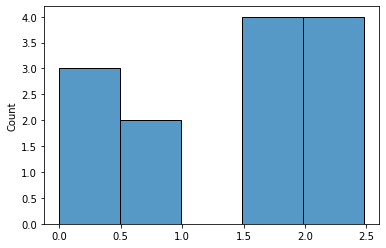

In [56]:
import seaborn as sns
sns.histplot(score_init[change_log == 1] - score_best[change_log == 1])

<Axes: ylabel='Count'>

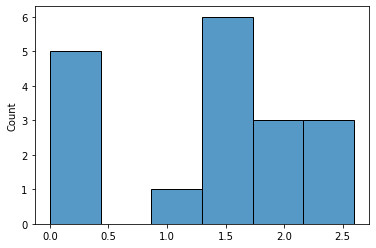

In [57]:
import seaborn as sns
sns.histplot(score_init[change_log == 2] - score_best[change_log == 2])

In [35]:
batch["label"].item()

0

In [61]:
import itertools
for x in itertools.permutations([1, 2, 3]):
    print(x)

(1, 2, 3)
(1, 3, 2)
(2, 1, 3)
(2, 3, 1)
(3, 1, 2)
(3, 2, 1)


In [62]:
pd.read_csv("/data/yongkang/TU/SOTAB/CTA_training_small_gt.csv")

,table_name,column_index,label
0,Product_michaelirvine.com_September2020_CTA.js...,4,currency
1,Product_michaelirvine.com_September2020_CTA.js...,6,Date
2,Product_heavenlybia.com_September2020_CTA.json.gz,3,currency
3,Product_heavenlybia.com_September2020_CTA.json.gz,5,Date
4,Product_magpieandlondon.com_September2020_CTA....,3,price
...,...,...,...
32999,MusicRecording_journey-north.com_September2020...,3,MusicAlbum
33000,MusicRecording_journey-north.com_September2020...,4,MusicArtistAT
33001,SportsEvent_4smenssoccer.com_September2020_CTA...,2,SportsTeam
33002,SportsEvent_4smenssoccer.com_September2020_CTA...,0,SportsEvent/name


In [2]:
import pandas as pd
df = pd.read_csv("/data/yongkang/TU/SOTAB/comma_train_sotab.csv")

In [3]:
df

,table_id,column_index,label,data
0,Book_1carpetcleaning.co.uk_September2020_CTA.j...,0,5,"Homer William Bedell Stanford W. Stanford, Dav..."
1,Book_1carpetcleaning.co.uk_September2020_CTA.j...,1,10,Unlimited [Historical Fiction Book] ↠ The Odys...
2,Book_1carpetcleaning.co.uk_September2020_CTA.j...,2,36,"Paperback, Hardcover, Paperback, None, Paperba..."
3,Book_1carpetcleaning.co.uk_September2020_CTA.j...,3,-1,"2020-06-27T15:00:54+00:00, 2020-06-01T00:07:00..."
4,Book_1carpetcleaning.co.uk_September2020_CTA.j...,4,-1,"418, 309, 139, 491, 461, 272, 211, 365, 153, 2..."
...,...,...,...,...
91315,TVEpisode_yidio.com_September2020_CTA.json.gz,1,19,In the hope that Griffin has left materials an...
91316,TVEpisode_yidio.com_September2020_CTA.json.gz,2,35,"BANANA FISH, None, None, None, None, None, Non..."
91317,TVEpisode_yidio.com_September2020_CTA.json.gz,3,-1,"1.0, nan, nan, nan, nan, nan, nan, nan, nan, n..."
91318,TVEpisode_yidio.com_September2020_CTA.json.gz,4,33,"None, 2019-11-06, 2019-10-23, 2019-10-23, 1986..."


In [4]:
df.columns

Index(['table_id', 'column_index', 'label', 'data'], dtype='object')

In [5]:
df.columns = ['table_id', 'col_idx', 'class_id', 'data']

In [6]:
df

,table_id,col_idx,class_id,data
0,Book_1carpetcleaning.co.uk_September2020_CTA.j...,0,5,"Homer William Bedell Stanford W. Stanford, Dav..."
1,Book_1carpetcleaning.co.uk_September2020_CTA.j...,1,10,Unlimited [Historical Fiction Book] ↠ The Odys...
2,Book_1carpetcleaning.co.uk_September2020_CTA.j...,2,36,"Paperback, Hardcover, Paperback, None, Paperba..."
3,Book_1carpetcleaning.co.uk_September2020_CTA.j...,3,-1,"2020-06-27T15:00:54+00:00, 2020-06-01T00:07:00..."
4,Book_1carpetcleaning.co.uk_September2020_CTA.j...,4,-1,"418, 309, 139, 491, 461, 272, 211, 365, 153, 2..."
...,...,...,...,...
91315,TVEpisode_yidio.com_September2020_CTA.json.gz,1,19,In the hope that Griffin has left materials an...
91316,TVEpisode_yidio.com_September2020_CTA.json.gz,2,35,"BANANA FISH, None, None, None, None, None, Non..."
91317,TVEpisode_yidio.com_September2020_CTA.json.gz,3,-1,"1.0, nan, nan, nan, nan, nan, nan, nan, nan, n..."
91318,TVEpisode_yidio.com_September2020_CTA.json.gz,4,33,"None, 2019-11-06, 2019-10-23, 2019-10-23, 1986..."


In [7]:
tokenizer

NameError: name 'tokenizer' is not defined

In [14]:
# from functools import reduce
# import operator
# random_sample = False
# max_unlabeled = 8

# data_list = []

# df['class_id'] = df['class_id'].astype(int)
# df.drop(df[(df['data'].isna()) & (df['class_id'] == -1)].index, inplace=True)
# df['col_idx'] = df['col_idx'].astype(int)
# df['data'] = df['data'].astype(str)

# num_tables = len(df.groupby("table_id"))
 

# # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
# total_num_cols = 0
# for i, (index, group_df) in enumerate(df.groupby("table_id")):
#     #     break
#     labeled_columns = group_df[group_df['class_id'] > -1]
#     unlabeled_columns = group_df[group_df['class_id'] == -1]
#     num_unlabeled = min(max(max_unlabeled-len(labeled_columns), 0), len(unlabeled_columns))
#     unlabeled_columns = unlabeled_columns.sample(num_unlabeled) if random_sample else unlabeled_columns[0:num_unlabeled]
#     # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns.sample(min(10-len(labeled_columns), len(unlabeled_columns)))])
#     # group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns[0:min(max(10-len(labeled_columns), 0), len(unlabeled_columns))]])
#     group_df = pd.concat([group_df[group_df['class_id'] > -1], unlabeled_columns]) # TODO
#     group_df.sort_values(by=['col_idx'], inplace=True)

#     if max_length <= 128:
#         cur_maxlen = min(max_length, 512 // len(list(group_df["class_id"].values)) - 1)
#     else:
#         cur_maxlen = max(1, max_length // len(list(group_df["class_id"].values)) - 1)
        
#     token_ids_list = group_df["data"].apply(lambda x: tokenizer.encode(
#         tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
#         )
#     token_ids = torch.LongTensor(reduce(operator.add,
#                                         token_ids_list)).to(device)
#     cls_index_list = [0] + np.cumsum(
#         np.array([len(x) for x in token_ids_list])).tolist()[:-1]
#     for cls_index in cls_index_list:
#         assert token_ids[
#             cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
#     cls_indexes = torch.LongTensor(cls_index_list).to(device)
#     class_ids = torch.LongTensor(
#         group_df["class_id"].values).to(device)
#     data_list.append(
#         [index,
#             len(group_df), token_ids, class_ids, cls_indexes])
# table_df = pd.DataFrame(data_list,
#                                 columns=[
#                                     "table_id", "num_col", "data_tensor",
#                                     "label_tensor", "cls_indexes"
#                                 ])

In [64]:
base_dirpath = "/data/yongkang/TU/SOTAB"
df = pd.read_csv(os.path.join(base_dirpath, "CTA_training_small_gt.csv"))

In [65]:
table_files = [f for f in os.listdir(os.path.join(base_dirpath, data_folder)) if f in gt_df['table_name'].values]

NameError: name 'data_folder' is not defined

In [450]:
batch["data"].T.shape

torch.Size([1, 64])

In [454]:
cls_indexes.shape

torch.Size([1, 2])

In [477]:
# Save target training embeddings
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
num_single_fail = 0
num_good_context = 0
# training_batches = []
# training_embeddings = []
# training_data = []
# training_col_mask = []
training_labels = []
class_context = defaultdict(list)
for batch_idx, batch in enumerate(train_dataloader_iter):
    target_col_mask = batch["target_col_mask"].T
    if 1 in target_col_mask:
        cls_indexes = torch.tensor([0, 0]).reshape(1, -1).to(device)
        # logits_temp, embs = model(batch["data"].T[target_col_mask==0].reshape(1, -1), cls_indexes=cls_indexes, get_enc=True)  
        # training_embeddings.append(embs.detach().cpu())
        # training_data.append(batch["data"].T.cpu())
        # training_col_mask.append(target_col_mask.cpu())
        training_labels.append(batch["label"].item())

        

In [457]:
len(training_embeddings)

3463

In [458]:
training_embeddings[0].shape

torch.Size([768])

In [459]:
training_embeddings_all = torch.vstack(training_embeddings)

In [460]:
output = F.cosine_similarity(training_embeddings[0].reshape(-1), training_embeddings_all)

In [463]:
output.topk(5)

torch.return_types.topk(
values=tensor([1.0000, 0.9984, 0.9981, 0.9971, 0.9967]),
indices=tensor([   0, 2614, 2017, 2702,  160]))

In [467]:
target_embs.shape

torch.Size([768])

In [474]:
sim_values, sim_indices = F.cosine_similarity(target_embs.reshape(-1), training_embeddings_all).topk(5)

In [475]:
sim_values

tensor([0.6808, 0.6634, 0.6417, 0.6390, 0.6309])

In [478]:
[training_labels[i] for i in sim_indices]

[0, 57, 3, 0, 0]

In [ ]:
training_data 
training_col_mask

In [508]:
num_cols_test = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    num_cols_test.append(batch["target_col_mask"].max().item()+1)

In [509]:
print(np.mean(num_cols_test))

6.908755760368663


<Axes: ylabel='Count'>

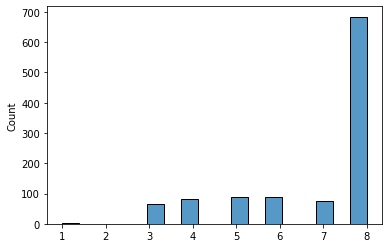

In [511]:
import seaborn as sns
sns.histplot(num_cols_test)

In [493]:
num_cols_train = []
for batch_idx, batch in enumerate(train_dataloader_iter):
    num_cols_train.append(batch["target_col_mask"].max().item()+1)

<Axes: ylabel='Count'>

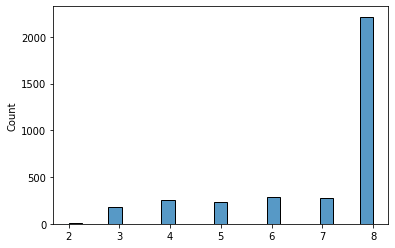

In [512]:
import seaborn as sns
sns.histplot(num_cols_train)

In [494]:
print(np.mean(num_cols_train))

6.977476176725383


In [490]:
alpha = 0.125
class_weights = (1.0 / class_freq) ** alpha

# Normalize the weights
class_weights /= class_weights.sum()

for k in [5]:
    for msp_threshold in [0.99]:
        for threshold in [0.9]:
            for debias_threshold in [0.8]:
                print(f"*********************K:{k}; Threshold: {threshold}; msp: {msp_threshold}, debias: {debias_threshold}****************************")
                model = model.to(device)
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits, target_embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
                    target_embs = target_embs.detach().cpu()
                    logits =  reweight_logits(logits.detach().cpu(), class_weights)
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    max_msp = 0
                    if 1 not in target_col_mask and msp_init < threshold:
                        sim_values, sim_indices = F.cosine_similarity(target_embs.reshape(-1), training_embeddings_all).topk(k)
                        print(batch_idx, target_col_mask.unique().tolist())
                        for sim_i in sim_indices:
                            new_data = training_data[sim_i].to(device)
                            new_target_col_mask = training_col_mask[sim_i].to(device)
                            col_idx_set = new_target_col_mask.unique().tolist()
                            print("Sim", sim_i, "Table", col_idx_set)
                            debias_classes = []
                            assert -1 not in col_idx_set
                            for r in range(1, len(col_idx_set) + 1):
                                for subset in itertools.combinations(col_idx_set, r):
                                    # if 0 not in subset:
                                    #     continue
                                    for x in itertools.permutations(subset):
                                        new_batch_data = []
                                        for col_i in x:
                                            if col_i == 0:
                                                if len(new_batch_data) == 0:
                                                    cls_indexes_value = 0
                                                else:
                                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                                new_batch_data.append(batch["data"].T.reshape(-1))
                                            else:
                                                new_batch_data.append(new_data[new_target_col_mask==col_i].to(device))
                                        if 0 not in x:
                                            cls_indexes_value = 0
                                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                        logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                        msp_temp = logits_temp.max().item()
                                        predict_temp = logits_temp.argmax().item()
                                        if len(x) == 1 and 0 in x:
                                            predict_target = predict_temp
                                            msp_target = msp_temp
                                        # print(x, msp_temp, predict_temp)
                                        if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                            debias_classes.append(predict_temp)
                                            continue
                                        if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                            max_msp = msp_temp
                                            best_msp_perm = x
                                            msp_predict = predict_temp
                                            logits_msp = logits_temp.clone()
                        break
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)

                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

                        

*********************K:5; Threshold: 0.9; msp: 0.99, debias: 0.8****************************
2 [0]
Sim tensor(3175) Table [0, 1, 2, 3, 4, 5, 6]
Sim tensor(3188) Table [0, 1, 2, 3, 4, 5, 6, 7]
Sim tensor(2787) Table [0, 1, 2, 3, 4, 5, 6, 7]
Sim tensor(1264) Table [0, 1, 2, 3, 4, 5, 6, 7]
Sim tensor(3197) Table [0, 1, 2, 3, 4, 5, 6, 7]
ts_micro_f1=1.0000, ts_macro_f1=1.0000


IndexError: The shape of the mask [3] at index 0 does not match the shape of the indexed tensor [2] at index 0

In [488]:
alpha = 0.125
class_weights = (1.0 / class_freq) ** alpha

# Normalize the weights
class_weights /= class_weights.sum()

for k in [5,3, 1, 10]:
    for msp_threshold in [0.8, 0.9]:
        for threshold in [ 0.8, 0.9]:
            for debias_threshold in [0.8, 0.9, 1.0]:
                print(f"*********************K:{k}; Threshold: {threshold}; msp: {msp_threshold}, debias: {debias_threshold}****************************")
                model = model.to(device)
                ft_embs_test = []
                labels_test = []
                logits_test = []
                log = defaultdict(list)
                num_cols = []
                for batch_idx, batch in enumerate(test_dataloader_iter):
                    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
                    target_col_mask = batch["target_col_mask"].T
                    logits, target_embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
                    target_embs = target_embs.detach().cpu()
                    logits =  reweight_logits(logits.detach().cpu(), class_weights)
                    msp_init = logits.max().item()
                    num_cols.append(batch["target_col_mask"].max().item())
                    max_msp = 0
                    if 1 not in target_col_mask and msp_init < threshold:
                        sim_values, sim_indices = F.cosine_similarity(target_embs.reshape(-1), training_embeddings_all).topk(k)
                        
                        for sim_i in sim_indices:
                            new_data = training_data[sim_i].to(device)
                            new_target_col_mask = training_col_mask[sim_i].to(device)
                            col_idx_set = new_target_col_mask.unique().tolist()
                            debias_classes = []
                            assert -1 not in col_idx_set
                            for r in range(1, len(col_idx_set) + 1):
                                for subset in itertools.combinations(col_idx_set, r):
                                    # if 0 not in subset:
                                    #     continue
                                    for x in itertools.permutations(subset):
                                        new_batch_data = []
                                        for col_i in x:
                                            if col_i == 0:
                                                if len(new_batch_data) == 0:
                                                    cls_indexes_value = 0
                                                else:
                                                    cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                                                new_batch_data.append(batch["data"].T.reshape(-1))
                                            else:
                                                new_batch_data.append(new_data[new_target_col_mask==col_i].to(device))
                                        if 0 not in x:
                                            cls_indexes_value = 0
                                        new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
                                        cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
                                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                                        logits_temp = reweight_logits(logits_temp.detach().cpu(), class_weights)
                                        msp_temp = logits_temp.max().item()
                                        predict_temp = logits_temp.argmax().item()
                                        if len(x) == 1 and 0 in x:
                                            predict_target = predict_temp
                                            msp_target = msp_temp
                                        # print(x, msp_temp, predict_temp)
                                        if 0 not in x and msp_temp > debias_threshold and (predict_temp != predict_target):
                                            debias_classes.append(predict_temp)
                                            continue
                                        if msp_temp > max_msp and 0 in x and predict_temp not in debias_classes:
                                            max_msp = msp_temp
                                            best_msp_perm = x
                                            msp_predict = predict_temp
                                            logits_msp = logits_temp.clone()
                    if max_msp > msp_threshold:
                        logits = logits_msp.clone()
                    labels_test.append(batch["label"].cpu())
                    logits_test.append(logits.detach().cpu())
                labels_test = torch.cat(labels_test, dim=0)
                logits_test = torch.stack(logits_test, dim=0)
                preds_test = torch.argmax(logits_test, dim=1)
                num_cols = torch.tensor(num_cols)

                from sklearn.metrics import confusion_matrix, f1_score
                mask = num_cols > 0
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach().numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
                ts_pred_list = logits_test.argmax(
                                            1).cpu().detach()[~mask].numpy().tolist()
                ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="micro")
                ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                                    ts_pred_list,
                                    average="macro")
                print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

                        
            

*********************K:5; Threshold: 0.8; msp: 0.8, debias: 0.8****************************


KeyboardInterrupt: 

In [484]:
batch["data"].T.shape

torch.Size([1, 62])

In [482]:
for data in new_batch_data:
    print(data.shape)

torch.Size([1, 62])
torch.Size([64])


In [483]:
x

(0, 1)

In [118]:
# Save good context
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
num_single_fail = 0
num_good_context = 0
class_context = defaultdict(list)
for batch_idx, batch in enumerate(train_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    label_i = batch["label"].item()
    if 1 in target_col_mask:
        new_batch_data = batch["data"].T[target_col_mask==0].reshape([1, -1]) # Target column only
        cls_indexes = torch.tensor([[0, 0]]).to(device)
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        if logits.argmax().item() != label_i:
            num_single_fail += 1
            for col_i in target_col_mask.unique():
                if col_i == 0 or col_i == -1:
                    continue
                new_batch_data = torch.cat([batch["data"].T[target_col_mask==0].reshape([1, -1]), batch["data"].T[target_col_mask==col_i].reshape([1, -1])], dim=1)
                cls_indexes = torch.tensor([[0, 0]]).to(device)
                logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                if logits_temp.argmax().item() == batch["label"].item():
                    context_i = batch["data"].T[target_col_mask==col_i].reshape([1, -1]).detach().cpu()
                    class_context[label_i].append(context_i)


In [78]:
num_single_fail

2393

In [119]:
num_class_context = {k: len(v) for k, v in class_context.items()}

In [123]:
# MSP add
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
class_corrected ={k: 0 for k in class_context.keys()}
class_mistakes = {k: 0 for k in class_context.keys()}

for threshold in [ 0.8, 0.9]:
    print(f"*********************Threshold: {threshold}****************************")
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    log = defaultdict(list)
    num_cols = []
    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        msp_init = msp_max = F.softmax(logits).max().item()
        num_cols.append(batch["target_col_mask"].max().item())
        label_i = batch["label"].item()
        if batch["target_col_mask"].max().item() == 0:
            if msp_init < threshold:
                for class_i in class_context.keys():          
                    for temp_col in class_context[class_i]:
                        new_batch_data = torch.cat([batch["data"].T[target_col_mask==0].reshape([1, -1]),temp_col.to(device)], dim=1)
                        cls_indexes = torch.tensor([[0, 0]]).to(device)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        msp_temp = F.softmax(logits_temp).max().item()
                        if msp_temp > msp_max:
                            logits = logits_temp.clone()
                            msp_max = msp_temp
            
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)




    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

*********************Threshold: 0.5****************************


/tmp/ipykernel_4054970/861392142.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = msp_max = F.softmax(logits).max().item()
/tmp/ipykernel_4054970/861392142.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4618, ts_macro_f1=0.1841
ts_micro_f1=0.4229, ts_macro_f1=0.1781
ts_micro_f1=0.5059, ts_macro_f1=0.1581
*********************Threshold: 0.6****************************


/tmp/ipykernel_4054970/861392142.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = msp_max = F.softmax(logits).max().item()
/tmp/ipykernel_4054970/861392142.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4590, ts_macro_f1=0.1832
ts_micro_f1=0.4229, ts_macro_f1=0.1781
ts_micro_f1=0.5000, ts_macro_f1=0.1499
*********************Threshold: 0.7****************************


/tmp/ipykernel_4054970/861392142.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = msp_max = F.softmax(logits).max().item()
/tmp/ipykernel_4054970/861392142.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4562, ts_macro_f1=0.1828
ts_micro_f1=0.4229, ts_macro_f1=0.1781
ts_micro_f1=0.4941, ts_macro_f1=0.1483
*********************Threshold: 0.8****************************


/tmp/ipykernel_4054970/861392142.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = msp_max = F.softmax(logits).max().item()
/tmp/ipykernel_4054970/861392142.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4544, ts_macro_f1=0.1766
ts_micro_f1=0.4229, ts_macro_f1=0.1781
ts_micro_f1=0.4902, ts_macro_f1=0.1365
*********************Threshold: 0.9****************************


/tmp/ipykernel_4054970/861392142.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = msp_max = F.softmax(logits).max().item()
/tmp/ipykernel_4054970/861392142.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


ts_micro_f1=0.4544, ts_macro_f1=0.1729
ts_micro_f1=0.4229, ts_macro_f1=0.1781
ts_micro_f1=0.4902, ts_macro_f1=0.1251
*********************Threshold: 1.0****************************


/tmp/ipykernel_4054970/861392142.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_init = msp_max = F.softmax(logits).max().item()
/tmp/ipykernel_4054970/861392142.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  msp_temp = F.softmax(logits_temp).max().item()


KeyboardInterrupt: 

In [ ]:
# Cheat add
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
class_corrected ={k: 0 for k in class_context.keys()}
class_mistakes = {k: 0 for k in class_context.keys()}
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    num_cols.append(batch["target_col_mask"].max().item())
    label_i = batch["label"].item()
    if batch["target_col_mask"].max().item() == 0:
        if logits.argmax().item() != label_i:
            class_mistakes[label_i] += 1
            for temp_col in class_context[label_i]:
                new_batch_data = torch.cat([batch["data"].T[target_col_mask==0].reshape([1, -1]),temp_col.to(device)], dim=1)
                cls_indexes = torch.tensor([[0, 0]]).to(device)
                logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                if logits_temp.argmax().item() == batch["label"].item():
                    logits = logits_temp.clone()
                    class_corrected[label_i] += 1
                    break
                
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)




from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))